### Analysis and plotting for Fig 3 of Ong et al. 2025 "Transient Antarctic Slope Current Response to Climate Change including Meltwater"
* Thermal wind balance transport estimation -- using new 600m isoabth boundary between ASC and ACoC
* Based on salinity and temperature difference, see Sohail et al. 2024

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np

import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
import glob
import os

In [2]:
import matplotlib.dates as mdates
import datetime
import pandas as pd

In [3]:
%matplotlib inline

In [4]:
from matplotlib import rc
rc('font', **{'size':25})
rc('text', usetex=False)
rc('xtick', labelsize=25) #20 
rc('ytick', labelsize=25) #20
rc('axes', titlesize=25)    # fontsize of the axes title
rc('axes', labelsize=25) #24    # fontsize of the x and y labels

In [5]:
session=cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'

In [6]:
import dask.config
from dask.distributed import Client,LocalCluster

c = Client()
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43123,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:36041,Total threads: 2
Dashboard: /proxy/37029/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:41005,


2024-12-04 10:23:12,790 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-12-04 10:23:14,860 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-12-04 10:23:18,877 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2024-12-04 10:23:22,760 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2024-12-04 10:23:26,795 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2024-12-04 10:23:30,810 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-12-04 10:23:34,814 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-12-04 10:24:07,007 - distributed.utils_perf - WARNING - full garbage collections took

In [8]:
# location limits of dataset 
lat_lim = slice(-79, -60) #slice(-70, -65)
lon_lim = slice(-279.99,80)

In [9]:
exp_ctrl= '01deg_jra55v13_ryf9091'
exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'
exp_wthp= '01deg_jra55v13_ryf9091_qian_wthp'

#### SET EXPT HERE -- for Fig 2 we focus on the experiment with meltwater perturbation
expt = exp_wthmp


In [10]:
# We will use an annual average from 10 year in the RYF run
start_time_mw='2110-01-31 00:00:00' 
end_time_mw='2159-12-31 00:00:00'
flex_period = slice(start_time_mw , end_time_mw)

In [11]:
# importing bathymetry/grid data

In [12]:
hu = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='hu', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(yu_ocean = slice(-79,-60)).chunk({ 'yu_ocean':250, 'xu_ocean':1200})

In [13]:
ht = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='ht', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(yt_ocean = slice(-79,-60)).chunk({ 'yt_ocean':250, 'xt_ocean':1200})
ht_region = ht.sel( yt_ocean = lat_lim)

In [14]:
area_t = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_t', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(xt_ocean= lon_lim, yt_ocean = lat_lim)


In [15]:
# Import edges of st_ocean and add lat/lon dimensions:  , start_time=start_time_mw, end_time=end_time_mw,
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean': ht.yt_ocean, 'xt_ocean': ht.xt_ocean}, axis=[1, 2])


# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))


In [16]:
hu.load()

<xarray.DataArray 'hu' (yu_ocean: 440, xu_ocean: 3600)> Size: 6MB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [1931.0061, 1857.9861, 1785.2361, ..., 2235.639 , 2171.7917,
        2056.375 ],
       [1931.0061, 1857.9861, 1785.2361, ..., 2235.639 , 2171.7917,
        2062.0557],
       [1979.5555, 1882.7916, 1777.5416, ..., 2225.014 , 2179.8057,
        2082.9443]], dtype=float32)
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 6MB nan nan nan ... 79.8 79.9 80.0
    geolat_c  (yu_ocean, xu_ocean) float32 6MB nan nan nan ... -60.02 -60.02
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

In [17]:
# defining B-grid using xgcm
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
ocean_grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

In [18]:
# NEEDload coordinates and grid specifications
geolat_t = cc.querying.getvar(expt, 'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt, 'geolon_t', session=session, n=1)

dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

In [19]:
#sea_level_lim = sea_level.sel( xt_ocean= lon_lim, yt_ocean=lat_lim, time = flex_period)

# coordinates
lat_t = geolat_t.sel( xt_ocean= lon_lim,yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean= lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)

In [20]:
## need to run seperately or it will crash
import xgcm
coordinates = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])

In [21]:
vel = xr.merge([hu,coordinates, ht, ocean_grid.sel(xt_ocean= lon_lim,xu_ocean= lon_lim, yt_ocean=lat_lim, yu_ocean = lat_lim).isel(time = 0)],compat='override')# time is flex_period before

In [22]:
vel.coords['xt_ocean'].attrs.update(axis='X')
vel.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5, periodic=True)
vel.coords['yt_ocean'].attrs.update(axis='Y')
vel.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
metrics = {
    ('X',): ['dxt', 'dxu'], # X distances
    ('Y',): ['dyt', 'dyu'], # Y distances
    ('X', 'Y'): ['area_t', 'area_u'] # Areas
}

In [23]:
grid = xgcm.Grid(vel, periodic=['X'], metrics = metrics,boundary='extend')
grid

<xgcm.Grid>
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
X Axis (periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center

In [24]:
## import mask with clusters to define the analysis continental shelf and slope regions (~<2500m depth)
cluster_mask_access = xr.open_mfdataset('/home/561/qo9901/Antarctic-Eddy-Res-Compare/largest_3cluster_mask_xr_accessom201.nc')
cluster_mask_access = cluster_mask_access.assign_coords(xu_ocean = ('xu_ocean', hu.xu_ocean.data), yu_ocean = ('yu_ocean', hu.yu_ocean.data))

### interpolate to t grid
cluster_mask_access = grid.interp(cluster_mask_access.__xarray_dataarray_variable__, axis = ['X','Y'])
cluster_mask_access = cluster_mask_access> 0.25

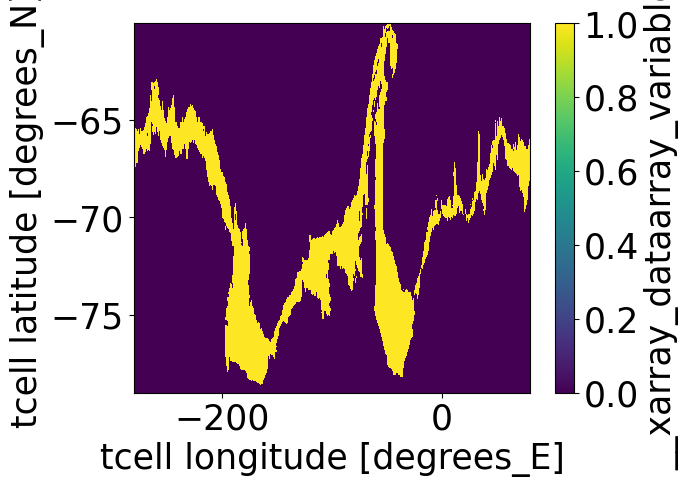

In [25]:
cluster_mask_access.plot()

In [27]:
cluster_mask_shelfwcanyons = ~xr.open_mfdataset('/home/561/qo9901/MW-perturb-ASC/nc_files/600misobath_sans_canyons_cluster_mask_xr_accessom201.nc')
## note inverse in cluster_mask_shelfwcanyons
cluster_mask_shelfwcanyons= cluster_mask_shelfwcanyons.assign_coords(xu_ocean = ('xu_ocean', hu.xu_ocean.data), yu_ocean = ('yu_ocean', hu.yu_ocean.data))
# cluster_mask_shelfwcanyons == True: Shelf 
cluster_mask_shelfwcanyons_t = grid.interp(cluster_mask_shelfwcanyons.__xarray_dataarray_variable__, axis = ['X','Y'])
cluster_mask_shelfwcanyons_t = cluster_mask_shelfwcanyons_t> 0.25

## skip if only plotting -- Making the boundary contours
* ASC_N_boundary_mask_da: northern edge of ASC
* ACoC_S_boundary_mask_da: southern edge of ACoC
* boundary_mask_da: boundary between shelf and slope regions


In [28]:
# ASC_N_boundary_mask_da: northern edge of ASC
# ACoC_S_boundary_mask_da: southern edge of ACoC
from scipy.ndimage import binary_erosion

# Step 1: Dilate the boolean array
eroded = binary_erosion(cluster_mask_access)

# Step 2: Find the boundary by taking the difference
ACoC_S_boundary_mask = eroded ^ cluster_mask_access # XOR operation to find the boundary

# Convert the boundary mask back to xarray DataArray
ACoC_S_boundary_mask_da = xr.DataArray(ACoC_S_boundary_mask, \
                                dims=cluster_mask_access.dims,\
                                coords=cluster_mask_access.coords)\
                            .where(cluster_mask_shelfwcanyons_t == True).where(ht<800)
#removes very shallow area overlapping with N

# Step 2: Find the boundary by taking the difference
ASC_N_boundary_mask = eroded ^ cluster_mask_access# XOR operation to find the boundary

# Convert the boundary mask back to xarray DataArray
ASC_N_boundary_mask_da = xr.DataArray(ASC_N_boundary_mask, \
                                dims=cluster_mask_access.dims,\
                                coords=cluster_mask_access.coords)\
                        .where(cluster_mask_shelfwcanyons_t == False) 
#NB no need for cluster_mask_access at ASC_N, or else a bunch of points get removed

eroded_da =  xr.DataArray(eroded, \
                                dims=cluster_mask_shelfwcanyons_t.dims,\
                                coords=cluster_mask_shelfwcanyons_t.coords)

In [29]:
cluster_mask_shelfwcanyons_t.values

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

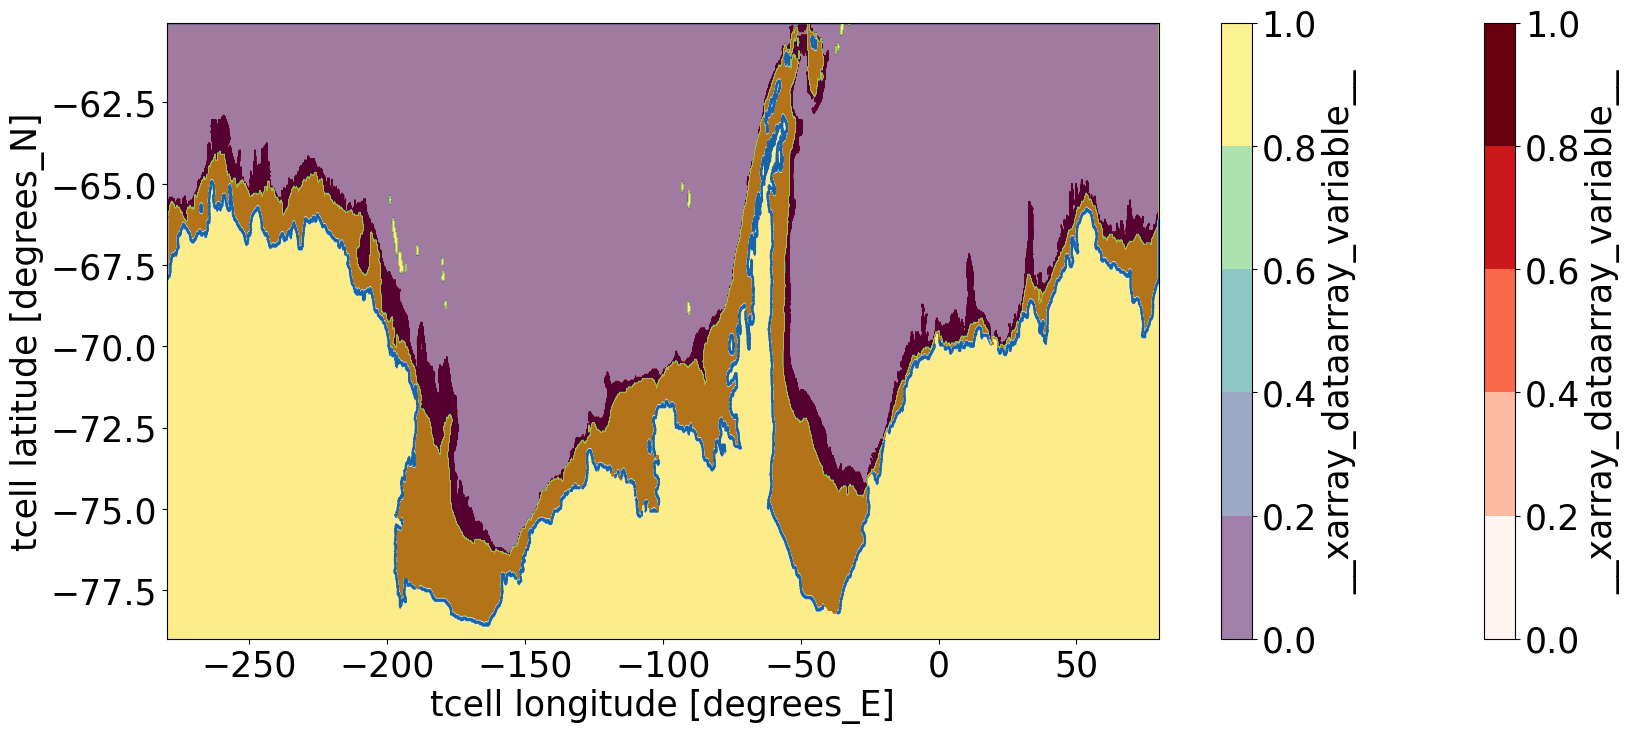

In [30]:
plt.figure(figsize = (20,8))
cluster_mask_access.plot.contourf(cmap ='Reds')
cluster_mask_shelfwcanyons_t.plot.contourf(alpha = 0.5)
ACoC_S_boundary_mask_da.where(cluster_mask_shelfwcanyons_t == True).plot.contour(cmap = 'Blues')


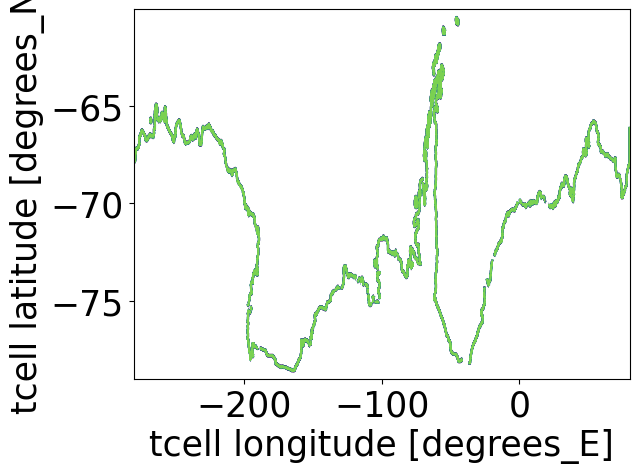

In [31]:
ACoC_S_boundary_mask_da.plot.contour(cmap = 'Blues')
ACoC_S_boundary_mask_da.where(ht<800).plot.contour()

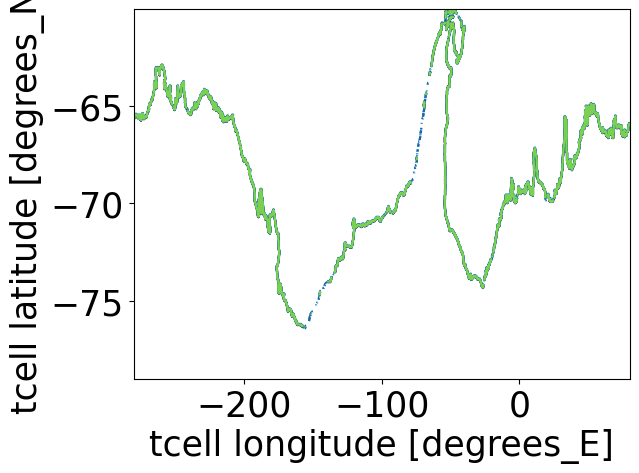

In [32]:
ASC_N_boundary_mask_da.plot.contour(cmap = 'Blues')
ASC_N_boundary_mask_da.where(cluster_mask_access == True).plot.contour()


In [33]:
from scipy.ndimage import binary_dilation
#boundary_mask_da: boundary between shelf and slope regions

# Step 1: Dilate the boolean array
dilated = binary_dilation(cluster_mask_shelfwcanyons_t)

# Step 2: Find the boundary by taking the difference
boundary_mask = dilated ^ cluster_mask_shelfwcanyons_t  # XOR operation to find the boundary

# Convert the boundary mask back to xarray DataArray
boundary_mask_da = xr.DataArray(boundary_mask, \
                                dims=cluster_mask_shelfwcanyons_t.dims,\
                                coords=cluster_mask_shelfwcanyons_t.coords)
dilated_da =  xr.DataArray(dilated, \
                                dims=cluster_mask_shelfwcanyons_t.dims,\
                                coords=cluster_mask_shelfwcanyons_t.coords)

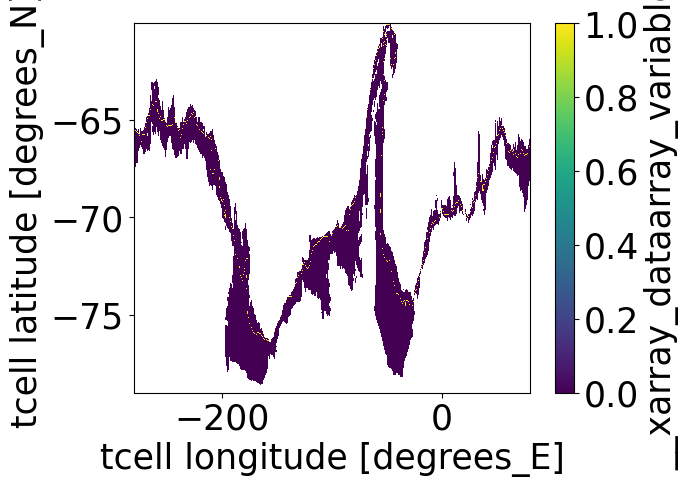

In [35]:
boundary_mask_da.where(cluster_mask_access == True).plot()

In [39]:
## get indices following true boundary
bound = boundary_mask_da.where(cluster_mask_access == True).compute().values
bound_idx = np.where(bound ==1)#.squeeze()

In [40]:
## get indices following true boundary
bound_N = ASC_N_boundary_mask_da.where(cluster_mask_access == True).compute().values
bound_N_idx = np.where(bound_N ==1)

In [41]:
## get indices following true boundary
bound_S = ACoC_S_boundary_mask_da.where(cluster_mask_access == True).compute().values
bound_S_idx = np.where(bound_S ==1)

In [42]:
bound_idx #[0] is latitude, [1] is longitude

(array([ 61,  61,  61, ..., 438, 438, 438]),
 array([1242, 1243, 1244, ..., 2333, 2334, 2335]))

## skip if only plotting -- making field of distance in km from each grid cell to the contour boundaries
* distance_to_contour.nc: dist. to boundary between ASC, ACoC
* distance_to_contour_N.nc: dist. to boundary on northern ASC edge
* distance_to_contour_S.nc: dist. to boundary on southern ACoC edge

In [43]:
from dask import compute, delayed

In [44]:
from scipy.spatial import cKDTree
from geopy.distance import geodesic

# Function to compute the geodesic distance between two lat-lon points in km
@delayed
def compute_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km
    

# Function to calculate distances of all grid points to the contour
def calculate_distance_to_contour(mask, lats, lons):
    # Find contour (boundary) points from the mask
    contour_points = np.array(np.where(mask == 1)).T
    
    # Create a k-d tree for fast nearest-neighbor lookup
    tree = cKDTree(contour_points)
    
    # Prepare array to store distances
    distance_map = np.full(lats.shape, np.inf)
    
    # Iterate over all points in the grid
    for i in range(lats.shape[0]):
        for j in range(lats.shape[1]):
            # Find the nearest contour point
            _, nearest_idx = tree.query([i, j])
            contour_lat = lats[contour_points[nearest_idx, 0], contour_points[nearest_idx, 1]]
            contour_lon = lons[contour_points[nearest_idx, 0], contour_points[nearest_idx, 1]]
            
            # Compute the geodesic distance
            distance_map[i, j] = compute_distance(lats[i, j], lons[i, j], contour_lat, contour_lon)
            if j % 100: print(i,j)
    
    return distance_map

# Function to calculate the average temperature within N km of the contour
@delayed
def area_avg_temperature_near_contour(temp, mask, lats, lons, N):
    # Calculate the distance of all points to the contour
    distance_to_contour = calculate_distance_to_contour(mask, lats, lons)
    
    # Select grid points within N km of the contour
    within_N_km = distance_to_contour <= N
    '''
    # Calculate the average temperature within N km
    avg_temp = np.mean(temp[within_N_km])
     return avg_temp

    '''
    # Extract temperatures and areas within N km
    temp_within_N_km = temp[within_N_km]

    areas_within_N_km = area_t[within_N_km]
    
    # Calculate the area-weighted average temperature
    weighted_avg_temp = np.sum(temp_within_N_km * areas_within_N_km) / np.sum(areas_within_N_km)
    
    return weighted_avg_temp

# Example usage:
# temp: 2D numpy array with temperature data
# mask: 2D numpy array with contour mask (1s and 0s)
# lats, lons: 2D arrays of latitudes and longitudes
# N: distance threshold in km (e.g., 50 km)



In [45]:
lon_grid, lat_grid = np.meshgrid(area_t.xt_ocean.data, area_t.yt_ocean.data)

In [46]:
# Function to calculate distances of all grid points to the contour
def calculate_distance_to_contour(mask, lats, lons):
    # Find contour (boundary) points from the mask
    contour_points = np.array(np.where(mask == 1)).T
    
    # Create a k-d tree for fast nearest-neighbor lookup
    tree = cKDTree(contour_points)
    
    # Prepare array to store distances
    distance_map = [] #np.full(lats.shape, np.inf)
    
    # Iterate over all points in the grid
    for i in range(lats.shape[0]):
        delayed_results = []
        for j in range(lats.shape[1]):
            # Find the nearest contour point
            _, nearest_idx = tree.query([i, j])
            contour_lat = lats[contour_points[nearest_idx, 0], contour_points[nearest_idx, 1]]
            contour_lon = lons[contour_points[nearest_idx, 0], contour_points[nearest_idx, 1]]
            
            # Compute the geodesic distance
            delayed_results.append(compute_distance(lats[i, j], lons[i, j], contour_lat, contour_lon))
            if j % 100 == 0 : print(i,j)
        distance_map_j = compute(*delayed_results)
        distance_map.append(distance_map_j)
    
    return distance_map, distance_map_j


In [47]:
%%time
distance_map, distance_map_j = calculate_distance_to_contour(bound, lat_grid, lon_grid)

0 0
0 100
0 200
0 300
0 400
0 500
0 600
0 700
0 800
0 900
0 1000
0 1100
0 1200
0 1300
0 1400
0 1500
0 1600
0 1700
0 1800
0 1900
0 2000
0 2100
0 2200
0 2300
0 2400
0 2500
0 2600
0 2700
0 2800
0 2900
0 3000
0 3100
0 3200
0 3300
0 3400
0 3500
1 0
1 100
1 200
1 300
1 400
1 500
1 600
1 700
1 800
1 900
1 1000
1 1100
1 1200
1 1300
1 1400
1 1500
1 1600
1 1700
1 1800
1 1900
1 2000
1 2100
1 2200
1 2300
1 2400
1 2500
1 2600
1 2700
1 2800
1 2900
1 3000
1 3100
1 3200
1 3300
1 3400
1 3500
2 0
2 100
2 200
2 300
2 400
2 500
2 600
2 700
2 800
2 900
2 1000
2 1100
2 1200
2 1300
2 1400
2 1500
2 1600
2 1700
2 1800
2 1900
2 2000
2 2100
2 2200
2 2300
2 2400
2 2500
2 2600
2 2700
2 2800
2 2900
2 3000
2 3100
2 3200
2 3300
2 3400
2 3500
3 0
3 100
3 200
3 300
3 400
3 500
3 600
3 700
3 800
3 900
3 1000
3 1100
3 1200
3 1300
3 1400
3 1500
3 1600
3 1700
3 1800
3 1900
3 2000
3 2100
3 2200
3 2300
3 2400
3 2500
3 2600
3 2700
3 2800
3 2900
3 3000
3 3100
3 3200
3 3300
3 3400
3 3500
4 0
4 100
4 200
4 300
4 400
4 500
4 600


2024-12-04 10:23:01,246 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


36 0
36 100
36 200
36 300
36 400
36 500
36 600
36 700
36 800
36 900
36 1000
36 1100
36 1200
36 1300
36 1400
36 1500
36 1600
36 1700
36 1800
36 1900
36 2000
36 2100
36 2200
36 2300
36 2400
36 2500
36 2600
36 2700
36 2800
36 2900
36 3000
36 3100
36 3200
36 3300
36 3400
36 3500


2024-12-04 10:23:05,175 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-12-04 10:23:08,684 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


37 0
37 100
37 200
37 300
37 400
37 500
37 600
37 700
37 800
37 900
37 1000
37 1100
37 1200
37 1300
37 1400
37 1500
37 1600
37 1700
37 1800
37 1900
37 2000
37 2100
37 2200
37 2300
37 2400
37 2500
37 2600
37 2700
37 2800
37 2900
37 3000
37 3100
37 3200
37 3300
37 3400
37 3500
38 0
38 100
38 200
38 300
38 400
38 500
38 600
38 700
38 800
38 900
38 1000
38 1100
38 1200
38 1300
38 1400
38 1500
38 1600
38 1700
38 1800
38 1900
38 2000
38 2100
38 2200
38 2300
38 2400
38 2500
38 2600
38 2700
38 2800
38 2900
38 3000
38 3100
38 3200
38 3300
38 3400
38 3500
39 0
39 100
39 200
39 300
39 400
39 500
39 600
39 700
39 800
39 900
39 1000
39 1100
39 1200
39 1300
39 1400
39 1500
39 1600
39 1700
39 1800
39 1900
39 2000
39 2100
39 2200
39 2300
39 2400
39 2500
39 2600
39 2700
39 2800
39 2900
39 3000
39 3100
39 3200
39 3300
39 3400
39 3500
40 0
40 100
40 200
40 300
40 400
40 500
40 600
40 700
40 800
40 900
40 1000
40 1100
40 1200
40 1300
40 1400
40 1500
40 1600
40 1700
40 1800
40 1900
40 2000
40 2100
40 2200


2024-12-04 10:23:38,823 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


45 0
45 100
45 200
45 300
45 400
45 500
45 600
45 700
45 800
45 900
45 1000
45 1100
45 1200
45 1300
45 1400
45 1500
45 1600
45 1700
45 1800
45 1900
45 2000
45 2100
45 2200
45 2300
45 2400
45 2500
45 2600
45 2700
45 2800
45 2900
45 3000
45 3100
45 3200
45 3300
45 3400
45 3500


2024-12-04 10:23:43,200 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


46 0
46 100
46 200
46 300
46 400
46 500
46 600
46 700
46 800
46 900
46 1000
46 1100
46 1200
46 1300
46 1400
46 1500
46 1600
46 1700
46 1800
46 1900
46 2000
46 2100
46 2200
46 2300
46 2400
46 2500
46 2600
46 2700
46 2800
46 2900
46 3000
46 3100
46 3200
46 3300
46 3400
46 3500


2024-12-04 10:23:47,190 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


47 0
47 100
47 200
47 300
47 400
47 500
47 600
47 700
47 800
47 900
47 1000
47 1100
47 1200
47 1300
47 1400
47 1500
47 1600
47 1700
47 1800
47 1900
47 2000
47 2100
47 2200
47 2300
47 2400
47 2500
47 2600
47 2700
47 2800
47 2900
47 3000
47 3100
47 3200
47 3300
47 3400
47 3500


2024-12-04 10:23:51,261 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


48 0
48 100
48 200
48 300
48 400
48 500
48 600
48 700
48 800
48 900
48 1000
48 1100
48 1200
48 1300
48 1400
48 1500
48 1600
48 1700
48 1800
48 1900
48 2000
48 2100
48 2200
48 2300
48 2400
48 2500
48 2600
48 2700
48 2800
48 2900
48 3000
48 3100
48 3200
48 3300
48 3400
48 3500


2024-12-04 10:23:55,147 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


49 0
49 100
49 200
49 300
49 400
49 500
49 600
49 700
49 800
49 900
49 1000


2024-12-04 10:23:59,187 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


49 1100
49 1200
49 1300
49 1400
49 1500
49 1600
49 1700
49 1800
49 1900
49 2000
49 2100
49 2200
49 2300
49 2400
49 2500
49 2600
49 2700
49 2800
49 2900
49 3000
49 3100
49 3200
49 3300
49 3400
49 3500


2024-12-04 10:24:02,877 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


50 0
50 100
50 200
50 300
50 400
50 500
50 600
50 700
50 800
50 900
50 1000
50 1100
50 1200
50 1300
50 1400
50 1500
50 1600
50 1700
50 1800
50 1900
50 2000
50 2100
50 2200
50 2300
50 2400
50 2500
50 2600
50 2700
50 2800
50 2900
50 3000
50 3100
50 3200
50 3300
50 3400
50 3500
51 0
51 100
51 200
51 300
51 400
51 500
51 600
51 700
51 800
51 900
51 1000
51 1100
51 1200
51 1300
51 1400
51 1500
51 1600
51 1700
51 1800
51 1900
51 2000
51 2100
51 2200
51 2300
51 2400
51 2500
51 2600
51 2700
51 2800
51 2900
51 3000
51 3100
51 3200
51 3300
51 3400
51 3500
52 0
52 100
52 200
52 300
52 400
52 500
52 600
52 700
52 800
52 900
52 1000
52 1100
52 1200
52 1300
52 1400
52 1500
52 1600
52 1700
52 1800
52 1900
52 2000
52 2100
52 2200
52 2300
52 2400
52 2500
52 2600
52 2700
52 2800
52 2900
52 3000
52 3100
52 3200
52 3300
52 3400
52 3500
53 0
53 100
53 200
53 300
53 400
53 500
53 600
53 700
53 800
53 900
53 1000
53 1100
53 1200
53 1300
53 1400
53 1500
53 1600
53 1700
53 1800
53 1900
53 2000
53 2100
53 2200


2024-12-04 10:25:01,456 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


64 0
64 100
64 200
64 300
64 400
64 500
64 600
64 700
64 800
64 900
64 1000
64 1100
64 1200
64 1300
64 1400
64 1500
64 1600
64 1700
64 1800
64 1900
64 2000
64 2100
64 2200
64 2300
64 2400
64 2500
64 2600
64 2700
64 2800
64 2900
64 3000
64 3100
64 3200
64 3300
64 3400
64 3500


2024-12-04 10:25:05,553 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


65 0
65 100
65 200
65 300
65 400
65 500
65 600
65 700
65 800
65 900
65 1000
65 1100
65 1200
65 1300
65 1400
65 1500
65 1600
65 1700
65 1800
65 1900
65 2000
65 2100
65 2200
65 2300
65 2400
65 2500
65 2600
65 2700
65 2800
65 2900
65 3000
65 3100
65 3200
65 3300
65 3400
65 3500


2024-12-04 10:25:09,626 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


66 0
66 100
66 200
66 300
66 400
66 500
66 600
66 700
66 800
66 900
66 1000
66 1100
66 1200
66 1300
66 1400
66 1500
66 1600
66 1700
66 1800
66 1900
66 2000
66 2100
66 2200
66 2300
66 2400
66 2500
66 2600
66 2700
66 2800
66 2900
66 3000
66 3100
66 3200
66 3300
66 3400
66 3500


2024-12-04 10:25:13,930 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


67 0
67 100
67 200
67 300
67 400
67 500
67 600
67 700
67 800
67 900
67 1000
67 1100
67 1200
67 1300
67 1400
67 1500
67 1600
67 1700
67 1800
67 1900
67 2000
67 2100
67 2200
67 2300
67 2400
67 2500
67 2600
67 2700
67 2800
67 2900
67 3000
67 3100
67 3200
67 3300
67 3400
67 3500
68 0
68 100
68 200
68 300
68 400
68 500
68 600
68 700
68 800
68 900
68 1000
68 1100
68 1200
68 1300
68 1400
68 1500
68 1600
68 1700
68 1800
68 1900
68 2000
68 2100
68 2200
68 2300
68 2400
68 2500
68 2600
68 2700
68 2800
68 2900
68 3000
68 3100
68 3200
68 3300
68 3400
68 3500
69 0
69 100
69 200


2024-12-04 10:25:22,160 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


69 300
69 400
69 500
69 600
69 700
69 800
69 900
69 1000
69 1100
69 1200
69 1300
69 1400
69 1500
69 1600
69 1700
69 1800
69 1900
69 2000
69 2100
69 2200
69 2300
69 2400
69 2500
69 2600
69 2700
69 2800
69 2900
69 3000
69 3100
69 3200
69 3300
69 3400
69 3500
70 0
70 100
70 200
70 300
70 400
70 500
70 600
70 700
70 800
70 900
70 1000
70 1100
70 1200
70 1300
70 1400
70 1500
70 1600
70 1700
70 1800
70 1900
70 2000
70 2100
70 2200
70 2300
70 2400
70 2500
70 2600
70 2700
70 2800
70 2900
70 3000
70 3100
70 3200
70 3300
70 3400
70 3500
71 0
71 100
71 200
71 300
71 400
71 500
71 600
71 700
71 800
71 900
71 1000
71 1100
71 1200
71 1300
71 1400
71 1500
71 1600
71 1700
71 1800
71 1900
71 2000
71 2100
71 2200
71 2300
71 2400
71 2500
71 2600
71 2700
71 2800
71 2900
71 3000
71 3100
71 3200
71 3300
71 3400
71 3500
72 0
72 100
72 200
72 300
72 400
72 500
72 600
72 700
72 800
72 900
72 1000
72 1100
72 1200
72 1300
72 1400
72 1500
72 1600
72 1700
72 1800
72 1900
72 2000
72 2100
72 2200
72 2300
72 2400
72 

2024-12-04 10:25:46,409 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


75 600
75 700
75 800
75 900
75 1000
75 1100
75 1200
75 1300
75 1400
75 1500
75 1600
75 1700
75 1800
75 1900
75 2000
75 2100
75 2200
75 2300
75 2400
75 2500
75 2600
75 2700
75 2800
75 2900
75 3000
75 3100
75 3200
75 3300
75 3400
75 3500
76 0
76 100
76 200
76 300
76 400
76 500


2024-12-04 10:25:50,730 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


76 600
76 700
76 800
76 900
76 1000
76 1100
76 1200
76 1300
76 1400
76 1500
76 1600
76 1700
76 1800
76 1900
76 2000
76 2100
76 2200
76 2300
76 2400
76 2500
76 2600
76 2700
76 2800
76 2900
76 3000
76 3100
76 3200
76 3300
76 3400
76 3500
77 0
77 100
77 200
77 300
77 400
77 500
77 600
77 700
77 800
77 900
77 1000
77 1100
77 1200
77 1300


2024-12-04 10:25:54,893 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


77 1400
77 1500
77 1600
77 1700
77 1800
77 1900
77 2000
77 2100
77 2200
77 2300
77 2400
77 2500
77 2600
77 2700
77 2800
77 2900
77 3000
77 3100
77 3200
77 3300
77 3400
77 3500
78 0
78 100
78 200
78 300
78 400
78 500
78 600
78 700
78 800
78 900
78 1000
78 1100
78 1200


2024-12-04 10:25:59,046 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


78 1300
78 1400
78 1500
78 1600
78 1700
78 1800
78 1900
78 2000
78 2100
78 2200
78 2300
78 2400
78 2500
78 2600
78 2700
78 2800
78 2900
78 3000
78 3100
78 3200
78 3300
78 3400
78 3500
79 0
79 100
79 200
79 300
79 400
79 500
79 600
79 700
79 800
79 900
79 1000
79 1100
79 1200
79 1300
79 1400
79 1500
79 1600
79 1700
79 1800
79 1900
79 2000
79 2100


2024-12-04 10:26:03,316 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


79 2200
79 2300
79 2400
79 2500
79 2600
79 2700
79 2800
79 2900
79 3000
79 3100
79 3200
79 3300
79 3400
79 3500
80 0
80 100
80 200
80 300
80 400
80 500
80 600
80 700
80 800
80 900
80 1000
80 1100
80 1200
80 1300
80 1400
80 1500
80 1600
80 1700
80 1800
80 1900
80 2000
80 2100
80 2200
80 2300
80 2400
80 2500
80 2600
80 2700
80 2800


2024-12-04 10:26:07,569 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


80 2900
80 3000
80 3100
80 3200
80 3300
80 3400
80 3500
81 0
81 100
81 200
81 300
81 400
81 500
81 600
81 700
81 800
81 900
81 1000
81 1100
81 1200
81 1300
81 1400
81 1500
81 1600
81 1700
81 1800
81 1900
81 2000
81 2100
81 2200
81 2300
81 2400
81 2500
81 2600
81 2700
81 2800
81 2900
81 3000
81 3100
81 3200
81 3300
81 3400
81 3500


2024-12-04 10:26:11,835 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


82 0
82 100
82 200
82 300
82 400
82 500
82 600
82 700
82 800
82 900
82 1000
82 1100
82 1200
82 1300
82 1400
82 1500
82 1600
82 1700
82 1800
82 1900
82 2000
82 2100
82 2200
82 2300
82 2400
82 2500
82 2600
82 2700
82 2800
82 2900
82 3000
82 3100
82 3200
82 3300
82 3400
82 3500


2024-12-04 10:26:16,262 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


83 0
83 100
83 200
83 300
83 400
83 500
83 600
83 700
83 800
83 900
83 1000
83 1100
83 1200
83 1300
83 1400
83 1500
83 1600
83 1700
83 1800
83 1900
83 2000
83 2100
83 2200
83 2300
83 2400
83 2500
83 2600
83 2700
83 2800
83 2900
83 3000
83 3100
83 3200
83 3300
83 3400
83 3500


2024-12-04 10:26:20,436 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


84 0
84 100
84 200
84 300
84 400
84 500
84 600
84 700
84 800
84 900
84 1000
84 1100
84 1200
84 1300
84 1400
84 1500
84 1600
84 1700
84 1800
84 1900
84 2000
84 2100
84 2200
84 2300
84 2400
84 2500
84 2600
84 2700
84 2800
84 2900
84 3000
84 3100
84 3200
84 3300
84 3400
84 3500
85 0
85 100
85 200
85 300
85 400
85 500
85 600
85 700
85 800
85 900
85 1000
85 1100
85 1200
85 1300
85 1400
85 1500
85 1600
85 1700
85 1800
85 1900
85 2000
85 2100
85 2200
85 2300
85 2400
85 2500
85 2600
85 2700
85 2800
85 2900
85 3000
85 3100
85 3200
85 3300
85 3400
85 3500
86 0
86 100
86 200
86 300
86 400
86 500
86 600
86 700
86 800
86 900
86 1000
86 1100
86 1200
86 1300
86 1400
86 1500
86 1600
86 1700
86 1800
86 1900
86 2000
86 2100
86 2200
86 2300
86 2400
86 2500
86 2600
86 2700
86 2800
86 2900
86 3000
86 3100
86 3200
86 3300
86 3400
86 3500


2024-12-04 10:26:35,641 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


87 0
87 100
87 200
87 300
87 400
87 500
87 600
87 700
87 800
87 900
87 1000
87 1100
87 1200
87 1300
87 1400
87 1500
87 1600
87 1700
87 1800
87 1900
87 2000
87 2100
87 2200
87 2300
87 2400
87 2500
87 2600
87 2700
87 2800
87 2900
87 3000
87 3100
87 3200
87 3300
87 3400
87 3500
88 0
88 100
88 200
88 300
88 400
88 500
88 600
88 700
88 800
88 900
88 1000
88 1100
88 1200
88 1300
88 1400
88 1500
88 1600
88 1700
88 1800
88 1900
88 2000
88 2100
88 2200
88 2300
88 2400
88 2500
88 2600
88 2700
88 2800
88 2900
88 3000
88 3100
88 3200
88 3300
88 3400
88 3500
89 0
89 100
89 200
89 300
89 400
89 500
89 600
89 700
89 800
89 900
89 1000
89 1100
89 1200
89 1300
89 1400
89 1500
89 1600
89 1700
89 1800
89 1900
89 2000
89 2100
89 2200


2024-12-04 10:26:45,689 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


89 2300
89 2400
89 2500
89 2600
89 2700
89 2800
89 2900
89 3000
89 3100
89 3200
89 3300
89 3400
89 3500
90 0
90 100
90 200
90 300
90 400
90 500
90 600
90 700
90 800
90 900
90 1000
90 1100
90 1200
90 1300
90 1400
90 1500
90 1600
90 1700
90 1800
90 1900
90 2000
90 2100
90 2200
90 2300
90 2400
90 2500
90 2600
90 2700
90 2800
90 2900
90 3000
90 3100
90 3200
90 3300
90 3400
90 3500


2024-12-04 10:26:50,234 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


91 0
91 100
91 200
91 300
91 400
91 500
91 600
91 700
91 800
91 900
91 1000
91 1100
91 1200
91 1300
91 1400
91 1500
91 1600
91 1700
91 1800
91 1900
91 2000
91 2100
91 2200
91 2300
91 2400
91 2500
91 2600
91 2700
91 2800
91 2900
91 3000
91 3100
91 3200
91 3300
91 3400
91 3500


2024-12-04 10:26:54,508 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


92 0
92 100
92 200
92 300
92 400
92 500
92 600
92 700
92 800
92 900
92 1000
92 1100
92 1200
92 1300
92 1400
92 1500
92 1600
92 1700
92 1800
92 1900
92 2000
92 2100
92 2200
92 2300
92 2400
92 2500
92 2600
92 2700
92 2800
92 2900
92 3000
92 3100
92 3200
92 3300
92 3400
92 3500


2024-12-04 10:26:58,899 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


93 0
93 100
93 200
93 300
93 400
93 500
93 600
93 700
93 800
93 900
93 1000
93 1100
93 1200
93 1300
93 1400
93 1500
93 1600
93 1700
93 1800
93 1900
93 2000
93 2100
93 2200
93 2300
93 2400
93 2500
93 2600
93 2700
93 2800
93 2900
93 3000
93 3100
93 3200
93 3300
93 3400
93 3500
94 0
94 100
94 200
94 300
94 400
94 500
94 600
94 700
94 800
94 900
94 1000
94 1100
94 1200
94 1300
94 1400
94 1500
94 1600
94 1700
94 1800
94 1900
94 2000
94 2100
94 2200
94 2300
94 2400
94 2500
94 2600
94 2700
94 2800
94 2900
94 3000
94 3100
94 3200
94 3300
94 3400
94 3500


2024-12-04 10:27:09,850 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


95 0
95 100
95 200
95 300
95 400
95 500
95 600
95 700
95 800
95 900
95 1000
95 1100
95 1200
95 1300
95 1400
95 1500
95 1600
95 1700
95 1800
95 1900
95 2000
95 2100
95 2200
95 2300
95 2400
95 2500
95 2600
95 2700
95 2800
95 2900
95 3000
95 3100
95 3200
95 3300
95 3400
95 3500
96 0
96 100
96 200
96 300
96 400
96 500
96 600
96 700
96 800
96 900
96 1000
96 1100
96 1200
96 1300
96 1400
96 1500
96 1600


2024-12-04 10:27:14,856 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


96 1700
96 1800
96 1900
96 2000
96 2100
96 2200
96 2300
96 2400
96 2500
96 2600
96 2700
96 2800
96 2900
96 3000
96 3100
96 3200
96 3300
96 3400
96 3500
97 0
97 100
97 200
97 300
97 400
97 500
97 600
97 700
97 800
97 900
97 1000
97 1100
97 1200
97 1300
97 1400
97 1500
97 1600
97 1700
97 1800
97 1900
97 2000
97 2100
97 2200
97 2300
97 2400
97 2500
97 2600
97 2700
97 2800
97 2900
97 3000
97 3100
97 3200
97 3300
97 3400
97 3500


2024-12-04 10:27:19,315 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


98 0
98 100
98 200
98 300
98 400
98 500
98 600
98 700
98 800
98 900
98 1000
98 1100
98 1200
98 1300
98 1400
98 1500
98 1600
98 1700
98 1800
98 1900
98 2000
98 2100
98 2200
98 2300
98 2400
98 2500
98 2600
98 2700
98 2800
98 2900
98 3000
98 3100
98 3200
98 3300
98 3400
98 3500


2024-12-04 10:27:23,601 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


99 0
99 100
99 200
99 300
99 400
99 500
99 600
99 700
99 800
99 900
99 1000
99 1100
99 1200
99 1300
99 1400
99 1500
99 1600
99 1700
99 1800
99 1900
99 2000
99 2100
99 2200
99 2300
99 2400
99 2500
99 2600
99 2700
99 2800
99 2900
99 3000
99 3100
99 3200
99 3300
99 3400
99 3500
100 0
100 100
100 200
100 300
100 400
100 500
100 600
100 700
100 800
100 900
100 1000
100 1100
100 1200
100 1300
100 1400
100 1500
100 1600
100 1700
100 1800
100 1900
100 2000
100 2100
100 2200
100 2300
100 2400
100 2500
100 2600
100 2700
100 2800
100 2900
100 3000
100 3100
100 3200
100 3300
100 3400
100 3500
101 0
101 100
101 200
101 300
101 400
101 500
101 600
101 700
101 800
101 900
101 1000
101 1100
101 1200
101 1300
101 1400
101 1500
101 1600
101 1700
101 1800
101 1900
101 2000
101 2100
101 2200
101 2300
101 2400
101 2500
101 2600
101 2700
101 2800
101 2900
101 3000
101 3100
101 3200
101 3300
101 3400
101 3500
102 0
102 100
102 200
102 300
102 400
102 500
102 600
102 700
102 800
102 900
102 1000
102 1100
102 

2024-12-04 10:27:44,538 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


104 0
104 100
104 200
104 300
104 400
104 500
104 600
104 700
104 800
104 900
104 1000
104 1100
104 1200
104 1300
104 1400
104 1500
104 1600
104 1700
104 1800
104 1900
104 2000
104 2100
104 2200
104 2300
104 2400
104 2500
104 2600
104 2700
104 2800
104 2900
104 3000
104 3100
104 3200
104 3300
104 3400
104 3500


2024-12-04 10:27:48,977 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


105 0
105 100
105 200
105 300
105 400
105 500
105 600
105 700
105 800
105 900
105 1000
105 1100
105 1200
105 1300
105 1400
105 1500
105 1600
105 1700
105 1800
105 1900
105 2000
105 2100
105 2200
105 2300
105 2400
105 2500
105 2600
105 2700
105 2800
105 2900
105 3000
105 3100
105 3200
105 3300
105 3400
105 3500
106 0
106 100
106 200
106 300
106 400
106 500
106 600
106 700
106 800
106 900
106 1000
106 1100
106 1200
106 1300
106 1400
106 1500
106 1600
106 1700
106 1800
106 1900
106 2000
106 2100
106 2200
106 2300
106 2400
106 2500
106 2600
106 2700
106 2800
106 2900
106 3000
106 3100
106 3200
106 3300
106 3400
106 3500
107 0
107 100
107 200
107 300
107 400
107 500
107 600
107 700
107 800
107 900
107 1000
107 1100
107 1200
107 1300
107 1400
107 1500
107 1600
107 1700
107 1800
107 1900
107 2000
107 2100
107 2200
107 2300
107 2400
107 2500
107 2600
107 2700
107 2800
107 2900
107 3000
107 3100
107 3200
107 3300
107 3400
107 3500
108 0
108 100
108 200
108 300
108 400
108 500
108 600
108 700
10

2024-12-04 10:28:09,702 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


110 0
110 100
110 200
110 300
110 400
110 500
110 600
110 700
110 800
110 900
110 1000
110 1100
110 1200
110 1300
110 1400
110 1500
110 1600
110 1700
110 1800
110 1900
110 2000
110 2100
110 2200
110 2300
110 2400
110 2500
110 2600
110 2700
110 2800
110 2900
110 3000
110 3100
110 3200
110 3300
110 3400
110 3500


2024-12-04 10:28:14,078 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


111 0
111 100
111 200
111 300
111 400
111 500
111 600
111 700
111 800
111 900
111 1000
111 1100
111 1200
111 1300
111 1400
111 1500
111 1600
111 1700
111 1800
111 1900
111 2000
111 2100
111 2200
111 2300
111 2400
111 2500
111 2600
111 2700
111 2800
111 2900
111 3000
111 3100
111 3200
111 3300
111 3400
111 3500
112 0
112 100
112 200
112 300
112 400
112 500
112 600
112 700
112 800
112 900
112 1000
112 1100
112 1200
112 1300
112 1400
112 1500
112 1600
112 1700
112 1800
112 1900
112 2000
112 2100
112 2200
112 2300
112 2400
112 2500
112 2600
112 2700
112 2800
112 2900
112 3000
112 3100
112 3200
112 3300
112 3400
112 3500
113 0
113 100
113 200
113 300
113 400
113 500
113 600
113 700
113 800
113 900
113 1000
113 1100
113 1200
113 1300
113 1400
113 1500
113 1600
113 1700
113 1800
113 1900
113 2000
113 2100
113 2200
113 2300
113 2400
113 2500
113 2600
113 2700
113 2800
113 2900
113 3000
113 3100
113 3200
113 3300
113 3400
113 3500
114 0
114 100
114 200
114 300
114 400
114 500
114 600
114 700
11

2024-12-04 10:28:34,341 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


116 0
116 100
116 200
116 300
116 400
116 500
116 600
116 700
116 800
116 900
116 1000
116 1100
116 1200
116 1300
116 1400
116 1500
116 1600
116 1700
116 1800
116 1900
116 2000
116 2100
116 2200
116 2300
116 2400
116 2500
116 2600
116 2700
116 2800
116 2900
116 3000
116 3100
116 3200
116 3300
116 3400
116 3500


2024-12-04 10:28:38,873 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


117 0
117 100
117 200
117 300
117 400
117 500
117 600
117 700
117 800
117 900
117 1000
117 1100
117 1200
117 1300
117 1400
117 1500
117 1600
117 1700
117 1800
117 1900
117 2000
117 2100
117 2200
117 2300
117 2400
117 2500
117 2600
117 2700
117 2800
117 2900
117 3000
117 3100
117 3200
117 3300
117 3400
117 3500
118 0
118 100
118 200
118 300
118 400
118 500
118 600
118 700
118 800
118 900
118 1000
118 1100
118 1200
118 1300
118 1400
118 1500
118 1600
118 1700
118 1800
118 1900
118 2000
118 2100
118 2200
118 2300
118 2400
118 2500
118 2600
118 2700
118 2800
118 2900
118 3000
118 3100
118 3200
118 3300
118 3400
118 3500
119 0
119 100
119 200
119 300
119 400
119 500
119 600
119 700
119 800
119 900
119 1000
119 1100
119 1200
119 1300
119 1400
119 1500
119 1600
119 1700
119 1800
119 1900
119 2000
119 2100
119 2200
119 2300
119 2400
119 2500
119 2600
119 2700
119 2800
119 2900
119 3000
119 3100
119 3200
119 3300
119 3400
119 3500
120 0
120 100
120 200
120 300


2024-12-04 10:28:54,505 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


120 400
120 500
120 600
120 700
120 800
120 900
120 1000
120 1100
120 1200
120 1300
120 1400
120 1500
120 1600
120 1700
120 1800
120 1900
120 2000
120 2100
120 2200
120 2300
120 2400
120 2500
120 2600
120 2700
120 2800
120 2900
120 3000
120 3100
120 3200
120 3300
120 3400
120 3500
121 0
121 100
121 200
121 300
121 400
121 500
121 600
121 700
121 800
121 900
121 1000
121 1100
121 1200
121 1300
121 1400
121 1500
121 1600
121 1700
121 1800
121 1900
121 2000
121 2100
121 2200
121 2300
121 2400
121 2500
121 2600
121 2700
121 2800
121 2900
121 3000
121 3100
121 3200
121 3300
121 3400
121 3500


2024-12-04 10:28:59,338 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


122 0
122 100
122 200
122 300
122 400
122 500
122 600
122 700
122 800
122 900
122 1000
122 1100
122 1200
122 1300
122 1400
122 1500
122 1600
122 1700
122 1800
122 1900
122 2000
122 2100
122 2200
122 2300
122 2400
122 2500
122 2600
122 2700
122 2800
122 2900
122 3000
122 3100
122 3200
122 3300
122 3400
122 3500


2024-12-04 10:29:03,694 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


123 0
123 100
123 200
123 300
123 400
123 500
123 600
123 700
123 800
123 900
123 1000
123 1100
123 1200
123 1300
123 1400
123 1500
123 1600
123 1700
123 1800
123 1900
123 2000
123 2100
123 2200
123 2300
123 2400
123 2500
123 2600
123 2700
123 2800
123 2900
123 3000
123 3100
123 3200
123 3300
123 3400
123 3500
124 0
124 100
124 200
124 300
124 400
124 500
124 600
124 700
124 800
124 900
124 1000
124 1100
124 1200
124 1300
124 1400
124 1500
124 1600
124 1700
124 1800
124 1900
124 2000
124 2100
124 2200
124 2300
124 2400
124 2500
124 2600
124 2700
124 2800
124 2900
124 3000
124 3100
124 3200
124 3300
124 3400
124 3500


2024-12-04 10:29:15,026 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


125 0
125 100
125 200
125 300
125 400
125 500
125 600
125 700
125 800
125 900
125 1000
125 1100
125 1200
125 1300
125 1400
125 1500
125 1600
125 1700
125 1800
125 1900
125 2000
125 2100
125 2200
125 2300
125 2400
125 2500
125 2600
125 2700
125 2800
125 2900
125 3000
125 3100
125 3200
125 3300
125 3400
125 3500
126 0
126 100
126 200
126 300
126 400
126 500
126 600
126 700
126 800
126 900
126 1000
126 1100
126 1200
126 1300
126 1400
126 1500
126 1600
126 1700
126 1800
126 1900
126 2000
126 2100
126 2200
126 2300
126 2400
126 2500
126 2600
126 2700
126 2800
126 2900
126 3000
126 3100
126 3200
126 3300
126 3400
126 3500


2024-12-04 10:29:20,164 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


127 0
127 100
127 200
127 300
127 400
127 500
127 600
127 700
127 800
127 900
127 1000
127 1100
127 1200
127 1300
127 1400
127 1500
127 1600
127 1700
127 1800
127 1900
127 2000
127 2100
127 2200
127 2300
127 2400
127 2500
127 2600
127 2700
127 2800
127 2900
127 3000
127 3100
127 3200
127 3300
127 3400
127 3500


2024-12-04 10:29:24,571 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


128 0
128 100
128 200
128 300
128 400
128 500
128 600
128 700
128 800
128 900
128 1000
128 1100
128 1200
128 1300
128 1400
128 1500
128 1600
128 1700
128 1800
128 1900
128 2000
128 2100
128 2200
128 2300
128 2400
128 2500
128 2600
128 2700
128 2800
128 2900
128 3000
128 3100
128 3200
128 3300
128 3400
128 3500
129 0
129 100
129 200
129 300
129 400
129 500
129 600
129 700
129 800
129 900
129 1000
129 1100
129 1200
129 1300
129 1400
129 1500
129 1600
129 1700
129 1800
129 1900
129 2000
129 2100
129 2200
129 2300
129 2400
129 2500
129 2600
129 2700
129 2800
129 2900
129 3000
129 3100
129 3200
129 3300
129 3400
129 3500


2024-12-04 10:29:36,227 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


130 0
130 100
130 200
130 300
130 400
130 500
130 600
130 700
130 800
130 900
130 1000
130 1100
130 1200
130 1300
130 1400
130 1500
130 1600
130 1700
130 1800
130 1900
130 2000
130 2100
130 2200
130 2300
130 2400
130 2500
130 2600
130 2700
130 2800
130 2900
130 3000
130 3100
130 3200
130 3300
130 3400
130 3500
131 0
131 100
131 200
131 300
131 400
131 500
131 600
131 700
131 800
131 900
131 1000
131 1100
131 1200
131 1300
131 1400
131 1500
131 1600
131 1700
131 1800
131 1900
131 2000
131 2100
131 2200
131 2300
131 2400
131 2500
131 2600
131 2700
131 2800
131 2900
131 3000
131 3100
131 3200
131 3300
131 3400
131 3500
132 0
132 100
132 200
132 300
132 400
132 500
132 600
132 700
132 800
132 900
132 1000
132 1100
132 1200
132 1300
132 1400
132 1500
132 1600
132 1700
132 1800
132 1900
132 2000
132 2100
132 2200
132 2300
132 2400
132 2500
132 2600
132 2700
132 2800
132 2900
132 3000
132 3100
132 3200
132 3300
132 3400
132 3500


2024-12-04 10:29:46,318 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


133 0
133 100
133 200
133 300
133 400
133 500
133 600
133 700
133 800
133 900
133 1000
133 1100
133 1200
133 1300
133 1400
133 1500
133 1600
133 1700
133 1800
133 1900
133 2000
133 2100
133 2200
133 2300
133 2400
133 2500
133 2600
133 2700
133 2800
133 2900
133 3000
133 3100
133 3200
133 3300
133 3400
133 3500


2024-12-04 10:29:50,751 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


134 0
134 100
134 200
134 300
134 400
134 500
134 600
134 700
134 800
134 900
134 1000
134 1100
134 1200
134 1300
134 1400
134 1500
134 1600
134 1700
134 1800
134 1900
134 2000
134 2100
134 2200
134 2300
134 2400
134 2500
134 2600
134 2700
134 2800
134 2900
134 3000
134 3100
134 3200
134 3300
134 3400
134 3500
135 0
135 100
135 200
135 300
135 400
135 500
135 600
135 700
135 800
135 900
135 1000
135 1100
135 1200
135 1300
135 1400
135 1500
135 1600
135 1700
135 1800
135 1900
135 2000
135 2100
135 2200
135 2300
135 2400
135 2500
135 2600
135 2700
135 2800
135 2900
135 3000
135 3100
135 3200
135 3300
135 3400
135 3500
136 0
136 100
136 200
136 300
136 400
136 500
136 600


2024-12-04 10:30:02,357 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


136 700
136 800
136 900
136 1000
136 1100
136 1200
136 1300
136 1400
136 1500
136 1600
136 1700
136 1800
136 1900
136 2000
136 2100
136 2200
136 2300
136 2400
136 2500
136 2600
136 2700
136 2800
136 2900
136 3000
136 3100
136 3200
136 3300
136 3400
136 3500
137 0
137 100
137 200
137 300
137 400
137 500
137 600
137 700
137 800
137 900
137 1000
137 1100
137 1200
137 1300
137 1400
137 1500
137 1600
137 1700
137 1800
137 1900
137 2000
137 2100
137 2200
137 2300
137 2400
137 2500
137 2600
137 2700
137 2800
137 2900
137 3000
137 3100
137 3200
137 3300
137 3400
137 3500


2024-12-04 10:30:07,325 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


138 0
138 100
138 200
138 300
138 400
138 500
138 600
138 700
138 800
138 900
138 1000
138 1100
138 1200
138 1300
138 1400
138 1500
138 1600
138 1700
138 1800
138 1900
138 2000
138 2100
138 2200
138 2300
138 2400
138 2500
138 2600
138 2700
138 2800
138 2900
138 3000
138 3100
138 3200
138 3300
138 3400
138 3500


2024-12-04 10:30:12,297 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


139 0
139 100
139 200
139 300
139 400
139 500
139 600
139 700
139 800
139 900
139 1000
139 1100
139 1200
139 1300
139 1400
139 1500
139 1600
139 1700
139 1800
139 1900
139 2000
139 2100
139 2200
139 2300
139 2400
139 2500
139 2600
139 2700
139 2800
139 2900
139 3000
139 3100
139 3200
139 3300
139 3400
139 3500
140 0
140 100
140 200
140 300
140 400
140 500
140 600
140 700
140 800
140 900
140 1000
140 1100
140 1200
140 1300
140 1400
140 1500
140 1600
140 1700
140 1800
140 1900
140 2000
140 2100
140 2200
140 2300
140 2400
140 2500
140 2600
140 2700
140 2800
140 2900
140 3000
140 3100
140 3200
140 3300
140 3400
140 3500
141 0
141 100
141 200
141 300
141 400
141 500
141 600
141 700
141 800
141 900
141 1000
141 1100
141 1200
141 1300
141 1400
141 1500
141 1600
141 1700
141 1800
141 1900
141 2000
141 2100
141 2200
141 2300
141 2400
141 2500
141 2600
141 2700
141 2800
141 2900
141 3000
141 3100
141 3200
141 3300
141 3400
141 3500
142 0
142 100
142 200
142 300
142 400
142 500
142 600
142 700
14

2024-12-04 10:30:34,185 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


144 0
144 100
144 200
144 300
144 400
144 500
144 600
144 700
144 800
144 900
144 1000
144 1100
144 1200
144 1300
144 1400
144 1500
144 1600
144 1700
144 1800
144 1900
144 2000
144 2100
144 2200
144 2300
144 2400
144 2500
144 2600
144 2700
144 2800
144 2900
144 3000
144 3100
144 3200
144 3300
144 3400
144 3500


2024-12-04 10:30:38,822 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


145 0
145 100
145 200
145 300
145 400
145 500
145 600
145 700
145 800
145 900
145 1000
145 1100
145 1200
145 1300
145 1400
145 1500
145 1600
145 1700
145 1800
145 1900
145 2000
145 2100
145 2200
145 2300
145 2400
145 2500
145 2600
145 2700
145 2800
145 2900
145 3000
145 3100
145 3200
145 3300
145 3400
145 3500
146 0
146 100
146 200
146 300
146 400
146 500
146 600
146 700
146 800
146 900
146 1000
146 1100
146 1200
146 1300
146 1400
146 1500
146 1600
146 1700
146 1800
146 1900
146 2000
146 2100
146 2200
146 2300
146 2400
146 2500
146 2600
146 2700
146 2800
146 2900
146 3000
146 3100
146 3200
146 3300
146 3400
146 3500


2024-12-04 10:30:50,795 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


147 0
147 100
147 200
147 300
147 400
147 500
147 600
147 700
147 800
147 900
147 1000
147 1100
147 1200
147 1300
147 1400
147 1500
147 1600
147 1700
147 1800
147 1900
147 2000
147 2100
147 2200
147 2300
147 2400
147 2500
147 2600
147 2700
147 2800
147 2900
147 3000
147 3100
147 3200
147 3300
147 3400
147 3500
148 0
148 100
148 200
148 300
148 400
148 500
148 600
148 700
148 800
148 900
148 1000
148 1100
148 1200
148 1300
148 1400
148 1500
148 1600
148 1700
148 1800
148 1900
148 2000
148 2100
148 2200
148 2300
148 2400
148 2500
148 2600
148 2700
148 2800
148 2900
148 3000
148 3100
148 3200
148 3300
148 3400
148 3500


2024-12-04 10:30:56,447 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


149 0
149 100
149 200
149 300
149 400
149 500
149 600
149 700
149 800
149 900
149 1000
149 1100
149 1200
149 1300
149 1400
149 1500
149 1600
149 1700
149 1800
149 1900
149 2000
149 2100
149 2200
149 2300
149 2400
149 2500
149 2600
149 2700
149 2800
149 2900
149 3000
149 3100
149 3200
149 3300
149 3400
149 3500


2024-12-04 10:31:01,275 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


150 0
150 100
150 200
150 300
150 400
150 500
150 600
150 700
150 800
150 900
150 1000
150 1100
150 1200
150 1300
150 1400
150 1500
150 1600
150 1700
150 1800
150 1900
150 2000
150 2100
150 2200
150 2300
150 2400
150 2500
150 2600
150 2700
150 2800
150 2900
150 3000
150 3100
150 3200
150 3300
150 3400
150 3500
151 0
151 100
151 200
151 300
151 400
151 500
151 600
151 700
151 800
151 900
151 1000
151 1100
151 1200
151 1300
151 1400
151 1500
151 1600
151 1700
151 1800
151 1900
151 2000
151 2100
151 2200
151 2300
151 2400
151 2500
151 2600
151 2700
151 2800
151 2900
151 3000
151 3100
151 3200
151 3300
151 3400
151 3500


2024-12-04 10:31:13,487 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


152 0
152 100
152 200
152 300
152 400
152 500
152 600
152 700
152 800
152 900
152 1000
152 1100
152 1200
152 1300
152 1400
152 1500
152 1600
152 1700
152 1800
152 1900
152 2000
152 2100
152 2200
152 2300
152 2400
152 2500
152 2600
152 2700
152 2800
152 2900
152 3000
152 3100
152 3200
152 3300
152 3400
152 3500
153 0
153 100
153 200
153 300
153 400
153 500
153 600
153 700
153 800
153 900
153 1000
153 1100
153 1200
153 1300
153 1400
153 1500
153 1600
153 1700
153 1800
153 1900
153 2000
153 2100
153 2200
153 2300
153 2400
153 2500
153 2600
153 2700
153 2800
153 2900
153 3000
153 3100
153 3200
153 3300
153 3400
153 3500


2024-12-04 10:31:19,152 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


154 0
154 100
154 200
154 300
154 400
154 500
154 600
154 700
154 800
154 900
154 1000
154 1100
154 1200
154 1300
154 1400
154 1500
154 1600
154 1700
154 1800
154 1900
154 2000
154 2100
154 2200
154 2300
154 2400
154 2500
154 2600
154 2700
154 2800
154 2900
154 3000
154 3100
154 3200
154 3300
154 3400
154 3500
155 0
155 100
155 200
155 300
155 400
155 500
155 600
155 700
155 800
155 900
155 1000
155 1100
155 1200
155 1300
155 1400
155 1500
155 1600
155 1700
155 1800
155 1900
155 2000
155 2100
155 2200
155 2300
155 2400
155 2500
155 2600
155 2700
155 2800
155 2900
155 3000
155 3100
155 3200
155 3300
155 3400
155 3500


2024-12-04 10:31:31,706 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


156 0
156 100
156 200
156 300
156 400
156 500
156 600
156 700
156 800
156 900
156 1000
156 1100
156 1200
156 1300
156 1400
156 1500
156 1600
156 1700
156 1800
156 1900
156 2000
156 2100
156 2200
156 2300
156 2400
156 2500
156 2600
156 2700
156 2800
156 2900
156 3000
156 3100
156 3200
156 3300
156 3400
156 3500
157 0
157 100
157 200
157 300
157 400
157 500
157 600
157 700
157 800
157 900
157 1000
157 1100
157 1200
157 1300
157 1400
157 1500
157 1600
157 1700
157 1800
157 1900
157 2000
157 2100
157 2200
157 2300
157 2400
157 2500
157 2600
157 2700
157 2800
157 2900
157 3000
157 3100
157 3200
157 3300
157 3400
157 3500


2024-12-04 10:31:37,166 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


158 0
158 100
158 200
158 300
158 400
158 500
158 600
158 700
158 800
158 900
158 1000
158 1100
158 1200
158 1300
158 1400
158 1500
158 1600
158 1700
158 1800
158 1900
158 2000
158 2100
158 2200
158 2300
158 2400
158 2500
158 2600
158 2700
158 2800
158 2900
158 3000
158 3100
158 3200
158 3300
158 3400
158 3500
159 0
159 100
159 200
159 300
159 400
159 500
159 600
159 700
159 800
159 900
159 1000
159 1100
159 1200
159 1300
159 1400
159 1500
159 1600
159 1700
159 1800
159 1900
159 2000
159 2100
159 2200
159 2300
159 2400
159 2500
159 2600
159 2700
159 2800
159 2900
159 3000
159 3100
159 3200
159 3300
159 3400
159 3500
160 0
160 100
160 200
160 300
160 400
160 500
160 600
160 700
160 800
160 900
160 1000


2024-12-04 10:31:49,982 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


160 1100
160 1200
160 1300
160 1400
160 1500
160 1600
160 1700
160 1800
160 1900
160 2000
160 2100
160 2200
160 2300
160 2400
160 2500
160 2600
160 2700
160 2800
160 2900
160 3000
160 3100
160 3200
160 3300
160 3400
160 3500
161 0
161 100
161 200
161 300
161 400
161 500
161 600
161 700
161 800
161 900
161 1000
161 1100
161 1200
161 1300
161 1400
161 1500
161 1600
161 1700
161 1800
161 1900
161 2000
161 2100
161 2200
161 2300
161 2400
161 2500
161 2600
161 2700
161 2800
161 2900
161 3000
161 3100
161 3200
161 3300
161 3400
161 3500


2024-12-04 10:31:55,272 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


162 0
162 100
162 200
162 300
162 400
162 500
162 600
162 700
162 800
162 900
162 1000
162 1100
162 1200
162 1300
162 1400
162 1500
162 1600
162 1700
162 1800
162 1900
162 2000
162 2100
162 2200
162 2300
162 2400
162 2500
162 2600
162 2700
162 2800
162 2900
162 3000
162 3100
162 3200
162 3300
162 3400
162 3500
163 0
163 100
163 200
163 300
163 400
163 500
163 600
163 700
163 800
163 900
163 1000
163 1100
163 1200
163 1300
163 1400
163 1500
163 1600
163 1700
163 1800
163 1900
163 2000
163 2100
163 2200
163 2300
163 2400
163 2500
163 2600
163 2700
163 2800
163 2900
163 3000
163 3100
163 3200
163 3300
163 3400
163 3500
164 0
164 100
164 200
164 300
164 400
164 500
164 600
164 700
164 800
164 900
164 1000
164 1100
164 1200
164 1300
164 1400
164 1500
164 1600
164 1700
164 1800
164 1900
164 2000
164 2100
164 2200
164 2300
164 2400
164 2500
164 2600
164 2700
164 2800
164 2900
164 3000
164 3100
164 3200
164 3300
164 3400
164 3500


2024-12-04 10:32:08,472 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


165 0
165 100
165 200
165 300
165 400
165 500
165 600
165 700
165 800
165 900
165 1000
165 1100
165 1200
165 1300
165 1400
165 1500
165 1600
165 1700
165 1800
165 1900
165 2000
165 2100
165 2200
165 2300
165 2400
165 2500
165 2600
165 2700
165 2800
165 2900
165 3000
165 3100
165 3200
165 3300
165 3400
165 3500


2024-12-04 10:32:13,340 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


166 0
166 100
166 200
166 300
166 400
166 500
166 600
166 700
166 800
166 900
166 1000
166 1100
166 1200
166 1300
166 1400
166 1500
166 1600
166 1700
166 1800
166 1900
166 2000
166 2100
166 2200
166 2300
166 2400
166 2500
166 2600
166 2700
166 2800
166 2900
166 3000
166 3100
166 3200
166 3300
166 3400
166 3500


2024-12-04 10:32:21,167 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


167 0
167 100
167 200
167 300
167 400
167 500
167 600
167 700
167 800
167 900
167 1000
167 1100
167 1200
167 1300
167 1400
167 1500
167 1600
167 1700
167 1800
167 1900
167 2000
167 2100
167 2200
167 2300
167 2400
167 2500
167 2600
167 2700
167 2800
167 2900
167 3000
167 3100
167 3200
167 3300
167 3400
167 3500
168 0
168 100
168 200
168 300
168 400
168 500
168 600
168 700
168 800
168 900
168 1000
168 1100
168 1200
168 1300
168 1400
168 1500
168 1600
168 1700
168 1800
168 1900
168 2000
168 2100
168 2200
168 2300
168 2400
168 2500
168 2600
168 2700
168 2800
168 2900
168 3000
168 3100
168 3200
168 3300
168 3400
168 3500


2024-12-04 10:32:27,277 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


169 0
169 100
169 200
169 300
169 400
169 500
169 600
169 700
169 800
169 900
169 1000
169 1100
169 1200
169 1300
169 1400
169 1500
169 1600
169 1700
169 1800
169 1900
169 2000
169 2100
169 2200
169 2300
169 2400
169 2500
169 2600
169 2700
169 2800
169 2900
169 3000
169 3100
169 3200
169 3300
169 3400
169 3500
170 0
170 100
170 200
170 300
170 400
170 500
170 600
170 700
170 800
170 900
170 1000
170 1100
170 1200
170 1300
170 1400
170 1500
170 1600
170 1700
170 1800
170 1900
170 2000
170 2100
170 2200
170 2300
170 2400
170 2500
170 2600
170 2700
170 2800
170 2900
170 3000
170 3100
170 3200
170 3300
170 3400
170 3500
171 0
171 100
171 200
171 300
171 400
171 500
171 600
171 700
171 800
171 900
171 1000
171 1100
171 1200
171 1300
171 1400
171 1500
171 1600
171 1700
171 1800
171 1900
171 2000
171 2100
171 2200
171 2300
171 2400


2024-12-04 10:32:40,118 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


171 2500
171 2600
171 2700
171 2800
171 2900
171 3000
171 3100
171 3200
171 3300
171 3400
171 3500
172 0
172 100
172 200
172 300
172 400
172 500
172 600
172 700
172 800
172 900
172 1000
172 1100
172 1200
172 1300
172 1400
172 1500
172 1600
172 1700
172 1800
172 1900
172 2000
172 2100
172 2200
172 2300
172 2400
172 2500
172 2600
172 2700
172 2800
172 2900
172 3000
172 3100
172 3200
172 3300
172 3400
172 3500


2024-12-04 10:32:45,262 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


173 0
173 100
173 200
173 300
173 400
173 500
173 600
173 700
173 800
173 900
173 1000
173 1100
173 1200
173 1300
173 1400
173 1500
173 1600
173 1700
173 1800
173 1900
173 2000
173 2100
173 2200
173 2300
173 2400
173 2500
173 2600
173 2700
173 2800
173 2900
173 3000
173 3100
173 3200
173 3300
173 3400
173 3500
174 0
174 100
174 200
174 300
174 400
174 500
174 600
174 700
174 800
174 900
174 1000
174 1100
174 1200
174 1300
174 1400
174 1500
174 1600
174 1700
174 1800
174 1900
174 2000
174 2100
174 2200
174 2300
174 2400
174 2500
174 2600
174 2700
174 2800
174 2900
174 3000
174 3100
174 3200
174 3300
174 3400
174 3500
175 0
175 100
175 200
175 300
175 400
175 500
175 600
175 700
175 800
175 900
175 1000
175 1100
175 1200
175 1300
175 1400
175 1500
175 1600
175 1700
175 1800
175 1900
175 2000
175 2100
175 2200
175 2300
175 2400
175 2500
175 2600
175 2700
175 2800
175 2900
175 3000
175 3100
175 3200
175 3300
175 3400
175 3500


2024-12-04 10:32:58,808 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


176 0
176 100
176 200
176 300
176 400
176 500
176 600
176 700
176 800
176 900
176 1000
176 1100
176 1200
176 1300
176 1400
176 1500
176 1600
176 1700
176 1800
176 1900
176 2000
176 2100
176 2200
176 2300
176 2400
176 2500
176 2600
176 2700
176 2800
176 2900
176 3000
176 3100
176 3200
176 3300
176 3400
176 3500
177 0
177 100
177 200
177 300
177 400
177 500
177 600
177 700
177 800
177 900
177 1000
177 1100
177 1200
177 1300
177 1400
177 1500
177 1600
177 1700
177 1800
177 1900
177 2000
177 2100
177 2200
177 2300
177 2400
177 2500
177 2600
177 2700
177 2800
177 2900
177 3000
177 3100
177 3200
177 3300
177 3400
177 3500
178 0
178 100
178 200
178 300
178 400
178 500
178 600
178 700
178 800
178 900
178 1000
178 1100
178 1200
178 1300


2024-12-04 10:33:11,948 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


178 1400
178 1500
178 1600
178 1700
178 1800
178 1900
178 2000
178 2100
178 2200
178 2300
178 2400
178 2500
178 2600
178 2700
178 2800
178 2900
178 3000
178 3100
178 3200
178 3300
178 3400
178 3500
179 0
179 100
179 200
179 300
179 400
179 500
179 600
179 700
179 800
179 900
179 1000
179 1100
179 1200
179 1300
179 1400
179 1500
179 1600
179 1700
179 1800
179 1900
179 2000
179 2100
179 2200
179 2300
179 2400
179 2500
179 2600
179 2700
179 2800
179 2900
179 3000
179 3100
179 3200
179 3300
179 3400
179 3500


2024-12-04 10:33:17,229 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


180 0
180 100
180 200
180 300
180 400
180 500
180 600
180 700
180 800
180 900
180 1000
180 1100
180 1200
180 1300
180 1400
180 1500
180 1600
180 1700
180 1800
180 1900
180 2000
180 2100
180 2200
180 2300
180 2400
180 2500
180 2600
180 2700
180 2800
180 2900
180 3000
180 3100
180 3200
180 3300
180 3400
180 3500
181 0
181 100
181 200
181 300
181 400
181 500
181 600
181 700
181 800
181 900
181 1000
181 1100
181 1200
181 1300
181 1400
181 1500
181 1600
181 1700
181 1800
181 1900
181 2000
181 2100
181 2200
181 2300
181 2400
181 2500
181 2600
181 2700
181 2800
181 2900
181 3000
181 3100
181 3200
181 3300
181 3400
181 3500
182 0
182 100
182 200
182 300
182 400
182 500
182 600
182 700
182 800
182 900
182 1000
182 1100
182 1200
182 1300
182 1400
182 1500
182 1600
182 1700
182 1800
182 1900
182 2000
182 2100
182 2200
182 2300
182 2400
182 2500
182 2600
182 2700
182 2800
182 2900
182 3000
182 3100
182 3200
182 3300
182 3400
182 3500


2024-12-04 10:33:31,153 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


183 0
183 100
183 200
183 300
183 400
183 500
183 600
183 700
183 800
183 900
183 1000
183 1100
183 1200
183 1300
183 1400
183 1500
183 1600
183 1700
183 1800
183 1900
183 2000
183 2100
183 2200
183 2300
183 2400
183 2500
183 2600
183 2700
183 2800
183 2900
183 3000
183 3100
183 3200
183 3300
183 3400
183 3500
184 0
184 100
184 200
184 300
184 400
184 500
184 600
184 700
184 800
184 900
184 1000
184 1100
184 1200
184 1300
184 1400
184 1500
184 1600
184 1700
184 1800
184 1900
184 2000
184 2100
184 2200
184 2300
184 2400
184 2500
184 2600
184 2700
184 2800
184 2900
184 3000
184 3100
184 3200
184 3300
184 3400
184 3500
185 0
185 100
185 200
185 300
185 400
185 500
185 600
185 700
185 800
185 900
185 1000
185 1100
185 1200
185 1300
185 1400
185 1500


2024-12-04 10:33:44,400 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


185 1600
185 1700
185 1800
185 1900
185 2000
185 2100
185 2200
185 2300
185 2400
185 2500
185 2600
185 2700
185 2800
185 2900
185 3000
185 3100
185 3200
185 3300
185 3400
185 3500
186 0
186 100
186 200
186 300
186 400
186 500
186 600
186 700
186 800
186 900
186 1000
186 1100
186 1200
186 1300
186 1400
186 1500
186 1600
186 1700
186 1800
186 1900
186 2000
186 2100
186 2200
186 2300
186 2400
186 2500
186 2600
186 2700
186 2800
186 2900
186 3000
186 3100
186 3200
186 3300
186 3400
186 3500


2024-12-04 10:33:49,565 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


187 0
187 100
187 200
187 300
187 400
187 500
187 600
187 700
187 800
187 900
187 1000
187 1100
187 1200
187 1300
187 1400
187 1500
187 1600
187 1700
187 1800
187 1900
187 2000
187 2100
187 2200
187 2300
187 2400
187 2500
187 2600
187 2700
187 2800
187 2900
187 3000
187 3100
187 3200
187 3300
187 3400
187 3500
188 0
188 100
188 200
188 300
188 400
188 500
188 600
188 700
188 800
188 900
188 1000
188 1100
188 1200
188 1300
188 1400
188 1500
188 1600
188 1700
188 1800
188 1900
188 2000
188 2100
188 2200
188 2300
188 2400
188 2500
188 2600
188 2700
188 2800
188 2900
188 3000
188 3100
188 3200
188 3300
188 3400
188 3500
189 0
189 100
189 200
189 300
189 400
189 500
189 600
189 700
189 800
189 900
189 1000
189 1100
189 1200
189 1300
189 1400
189 1500
189 1600
189 1700
189 1800
189 1900
189 2000
189 2100
189 2200
189 2300
189 2400
189 2500
189 2600
189 2700
189 2800
189 2900
189 3000
189 3100
189 3200
189 3300
189 3400
189 3500


2024-12-04 10:34:03,128 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


190 0
190 100
190 200
190 300
190 400
190 500
190 600
190 700
190 800
190 900
190 1000
190 1100
190 1200
190 1300
190 1400
190 1500
190 1600
190 1700
190 1800
190 1900
190 2000
190 2100
190 2200
190 2300
190 2400
190 2500
190 2600
190 2700
190 2800
190 2900
190 3000
190 3100
190 3200
190 3300
190 3400
190 3500
191 0
191 100
191 200
191 300
191 400
191 500
191 600
191 700
191 800
191 900
191 1000
191 1100
191 1200
191 1300
191 1400
191 1500
191 1600
191 1700
191 1800
191 1900
191 2000
191 2100
191 2200
191 2300
191 2400
191 2500
191 2600
191 2700
191 2800
191 2900
191 3000
191 3100
191 3200
191 3300
191 3400
191 3500


2024-12-04 10:34:15,895 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


192 0
192 100
192 200
192 300
192 400
192 500
192 600
192 700
192 800
192 900
192 1000
192 1100
192 1200
192 1300
192 1400
192 1500
192 1600
192 1700
192 1800
192 1900
192 2000
192 2100
192 2200
192 2300
192 2400
192 2500
192 2600
192 2700
192 2800
192 2900
192 3000
192 3100
192 3200
192 3300
192 3400
192 3500
193 0
193 100
193 200
193 300
193 400
193 500
193 600
193 700
193 800
193 900
193 1000
193 1100
193 1200
193 1300
193 1400
193 1500
193 1600
193 1700
193 1800
193 1900
193 2000
193 2100
193 2200
193 2300
193 2400
193 2500
193 2600
193 2700
193 2800
193 2900
193 3000
193 3100
193 3200
193 3300
193 3400
193 3500


2024-12-04 10:34:21,789 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


194 0
194 100
194 200
194 300
194 400
194 500
194 600
194 700
194 800
194 900
194 1000
194 1100
194 1200
194 1300
194 1400
194 1500
194 1600
194 1700
194 1800
194 1900
194 2000
194 2100
194 2200
194 2300
194 2400
194 2500
194 2600
194 2700
194 2800
194 2900
194 3000
194 3100
194 3200
194 3300
194 3400
194 3500
195 0
195 100
195 200
195 300
195 400
195 500
195 600
195 700
195 800
195 900
195 1000
195 1100
195 1200
195 1300
195 1400
195 1500
195 1600
195 1700
195 1800
195 1900
195 2000
195 2100
195 2200
195 2300
195 2400
195 2500
195 2600
195 2700
195 2800
195 2900
195 3000
195 3100
195 3200
195 3300
195 3400
195 3500
196 0
196 100
196 200
196 300
196 400
196 500
196 600
196 700
196 800
196 900
196 1000
196 1100
196 1200
196 1300
196 1400
196 1500
196 1600
196 1700
196 1800
196 1900
196 2000
196 2100
196 2200
196 2300
196 2400
196 2500
196 2600
196 2700
196 2800
196 2900
196 3000
196 3100
196 3200
196 3300
196 3400
196 3500


2024-12-04 10:34:34,987 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


197 0
197 100
197 200
197 300
197 400
197 500
197 600
197 700
197 800
197 900
197 1000
197 1100
197 1200
197 1300
197 1400
197 1500
197 1600
197 1700
197 1800
197 1900
197 2000
197 2100
197 2200
197 2300
197 2400
197 2500
197 2600
197 2700
197 2800
197 2900
197 3000
197 3100
197 3200
197 3300
197 3400
197 3500
198 0
198 100
198 200
198 300
198 400
198 500
198 600
198 700
198 800
198 900
198 1000
198 1100
198 1200
198 1300
198 1400
198 1500
198 1600
198 1700
198 1800
198 1900
198 2000
198 2100
198 2200
198 2300
198 2400
198 2500
198 2600
198 2700
198 2800
198 2900
198 3000
198 3100
198 3200
198 3300
198 3400
198 3500


2024-12-04 10:34:48,150 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


199 0
199 100
199 200
199 300
199 400
199 500
199 600
199 700
199 800
199 900
199 1000
199 1100
199 1200
199 1300
199 1400
199 1500
199 1600
199 1700
199 1800
199 1900
199 2000
199 2100
199 2200
199 2300
199 2400
199 2500
199 2600
199 2700
199 2800
199 2900
199 3000
199 3100
199 3200
199 3300
199 3400
199 3500
200 0
200 100
200 200
200 300
200 400
200 500
200 600
200 700
200 800
200 900
200 1000
200 1100
200 1200
200 1300
200 1400
200 1500
200 1600
200 1700
200 1800
200 1900
200 2000
200 2100
200 2200
200 2300
200 2400
200 2500
200 2600
200 2700
200 2800
200 2900
200 3000
200 3100
200 3200
200 3300
200 3400
200 3500


2024-12-04 10:34:54,333 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


201 0
201 100
201 200
201 300
201 400
201 500
201 600
201 700
201 800
201 900
201 1000
201 1100
201 1200
201 1300
201 1400
201 1500
201 1600
201 1700
201 1800
201 1900
201 2000
201 2100
201 2200
201 2300
201 2400
201 2500
201 2600
201 2700
201 2800
201 2900
201 3000
201 3100
201 3200
201 3300
201 3400
201 3500
202 0
202 100
202 200
202 300
202 400
202 500
202 600
202 700
202 800
202 900
202 1000
202 1100
202 1200
202 1300
202 1400
202 1500
202 1600
202 1700
202 1800
202 1900
202 2000
202 2100
202 2200
202 2300
202 2400
202 2500
202 2600
202 2700
202 2800
202 2900
202 3000
202 3100
202 3200
202 3300
202 3400
202 3500
203 0
203 100
203 200
203 300
203 400
203 500
203 600
203 700
203 800
203 900
203 1000
203 1100
203 1200
203 1300
203 1400
203 1500
203 1600
203 1700
203 1800
203 1900
203 2000
203 2100
203 2200
203 2300
203 2400
203 2500


2024-12-04 10:35:07,932 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


203 2600
203 2700
203 2800
203 2900
203 3000
203 3100
203 3200
203 3300
203 3400
203 3500
204 0
204 100
204 200
204 300
204 400
204 500
204 600
204 700
204 800
204 900
204 1000
204 1100
204 1200
204 1300
204 1400
204 1500
204 1600
204 1700
204 1800
204 1900
204 2000
204 2100
204 2200
204 2300
204 2400
204 2500
204 2600
204 2700
204 2800
204 2900
204 3000
204 3100
204 3200
204 3300
204 3400
204 3500


2024-12-04 10:35:13,399 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


205 0
205 100
205 200
205 300
205 400
205 500
205 600
205 700
205 800
205 900
205 1000
205 1100
205 1200
205 1300
205 1400
205 1500
205 1600
205 1700
205 1800
205 1900
205 2000
205 2100
205 2200
205 2300
205 2400
205 2500
205 2600
205 2700
205 2800
205 2900
205 3000
205 3100
205 3200
205 3300
205 3400
205 3500
206 0
206 100
206 200
206 300
206 400
206 500
206 600
206 700
206 800
206 900
206 1000
206 1100
206 1200
206 1300
206 1400
206 1500
206 1600
206 1700
206 1800
206 1900
206 2000
206 2100
206 2200
206 2300
206 2400
206 2500
206 2600
206 2700
206 2800
206 2900
206 3000
206 3100
206 3200
206 3300
206 3400
206 3500
207 0
207 100
207 200
207 300
207 400
207 500
207 600
207 700
207 800
207 900
207 1000
207 1100
207 1200
207 1300
207 1400
207 1500
207 1600
207 1700
207 1800
207 1900
207 2000
207 2100
207 2200
207 2300
207 2400
207 2500
207 2600
207 2700
207 2800
207 2900
207 3000
207 3100
207 3200
207 3300
207 3400
207 3500


2024-12-04 10:35:27,191 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


208 0
208 100
208 200
208 300
208 400
208 500
208 600
208 700
208 800
208 900
208 1000
208 1100
208 1200
208 1300
208 1400
208 1500
208 1600
208 1700
208 1800
208 1900
208 2000
208 2100
208 2200
208 2300
208 2400
208 2500
208 2600
208 2700
208 2800
208 2900
208 3000
208 3100
208 3200
208 3300
208 3400
208 3500
209 0
209 100
209 200
209 300
209 400
209 500
209 600
209 700
209 800
209 900
209 1000
209 1100
209 1200
209 1300
209 1400
209 1500
209 1600
209 1700
209 1800
209 1900
209 2000
209 2100
209 2200
209 2300
209 2400
209 2500
209 2600
209 2700
209 2800
209 2900
209 3000
209 3100
209 3200
209 3300
209 3400
209 3500


2024-12-04 10:35:40,319 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


210 0
210 100
210 200
210 300
210 400
210 500
210 600
210 700
210 800
210 900
210 1000
210 1100
210 1200
210 1300
210 1400
210 1500
210 1600
210 1700
210 1800
210 1900
210 2000
210 2100
210 2200
210 2300
210 2400
210 2500
210 2600
210 2700
210 2800
210 2900
210 3000
210 3100
210 3200
210 3300
210 3400
210 3500
211 0
211 100
211 200
211 300
211 400
211 500
211 600
211 700
211 800
211 900
211 1000
211 1100
211 1200
211 1300
211 1400
211 1500
211 1600
211 1700
211 1800
211 1900
211 2000
211 2100
211 2200
211 2300
211 2400
211 2500
211 2600
211 2700
211 2800
211 2900
211 3000
211 3100
211 3200
211 3300
211 3400
211 3500


2024-12-04 10:35:46,361 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


212 0
212 100
212 200
212 300
212 400
212 500
212 600
212 700
212 800
212 900
212 1000
212 1100
212 1200
212 1300
212 1400
212 1500
212 1600
212 1700
212 1800
212 1900
212 2000
212 2100
212 2200
212 2300
212 2400
212 2500
212 2600
212 2700
212 2800
212 2900
212 3000
212 3100
212 3200
212 3300
212 3400
212 3500
213 0
213 100
213 200
213 300
213 400
213 500
213 600
213 700
213 800
213 900
213 1000
213 1100
213 1200
213 1300
213 1400
213 1500
213 1600
213 1700
213 1800
213 1900
213 2000
213 2100
213 2200
213 2300
213 2400
213 2500
213 2600
213 2700
213 2800
213 2900
213 3000
213 3100
213 3200
213 3300
213 3400
213 3500
214 0
214 100
214 200
214 300
214 400
214 500
214 600
214 700
214 800
214 900
214 1000
214 1100
214 1200
214 1300
214 1400
214 1500
214 1600
214 1700
214 1800
214 1900
214 2000
214 2100
214 2200
214 2300


2024-12-04 10:35:59,529 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


214 2400
214 2500
214 2600
214 2700
214 2800
214 2900
214 3000
214 3100
214 3200
214 3300
214 3400
214 3500
215 0
215 100
215 200
215 300
215 400
215 500
215 600
215 700
215 800
215 900
215 1000
215 1100
215 1200
215 1300
215 1400
215 1500
215 1600
215 1700
215 1800
215 1900
215 2000
215 2100
215 2200
215 2300
215 2400
215 2500
215 2600
215 2700
215 2800
215 2900
215 3000
215 3100
215 3200
215 3300
215 3400
215 3500
216 0
216 100
216 200
216 300
216 400
216 500
216 600
216 700
216 800
216 900
216 1000
216 1100
216 1200
216 1300
216 1400
216 1500
216 1600
216 1700
216 1800
216 1900
216 2000
216 2100
216 2200
216 2300
216 2400
216 2500
216 2600
216 2700
216 2800
216 2900
216 3000
216 3100
216 3200
216 3300
216 3400
216 3500
217 0
217 100
217 200
217 300
217 400
217 500
217 600
217 700
217 800
217 900
217 1000
217 1100
217 1200
217 1300
217 1400
217 1500
217 1600
217 1700
217 1800
217 1900
217 2000
217 2100
217 2200
217 2300
217 2400
217 2500
217 2600
217 2700
217 2800
217 2900
217 3000
2

2024-12-04 10:36:18,660 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


219 0
219 100
219 200
219 300
219 400
219 500
219 600
219 700
219 800
219 900
219 1000
219 1100
219 1200
219 1300
219 1400
219 1500
219 1600
219 1700
219 1800
219 1900
219 2000
219 2100
219 2200
219 2300
219 2400
219 2500
219 2600
219 2700
219 2800
219 2900
219 3000
219 3100
219 3200
219 3300
219 3400
219 3500
220 0
220 100
220 200
220 300
220 400
220 500
220 600
220 700
220 800
220 900
220 1000
220 1100
220 1200
220 1300
220 1400
220 1500
220 1600
220 1700
220 1800
220 1900
220 2000
220 2100
220 2200
220 2300
220 2400
220 2500
220 2600
220 2700
220 2800
220 2900
220 3000
220 3100
220 3200
220 3300
220 3400
220 3500


2024-12-04 10:36:32,015 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


221 0
221 100
221 200
221 300
221 400
221 500
221 600
221 700
221 800
221 900
221 1000
221 1100
221 1200
221 1300
221 1400
221 1500
221 1600
221 1700
221 1800
221 1900
221 2000
221 2100
221 2200
221 2300
221 2400
221 2500
221 2600
221 2700
221 2800
221 2900
221 3000
221 3100
221 3200
221 3300
221 3400
221 3500
222 0
222 100
222 200
222 300
222 400
222 500
222 600
222 700
222 800
222 900
222 1000
222 1100
222 1200
222 1300
222 1400
222 1500
222 1600
222 1700
222 1800
222 1900
222 2000
222 2100
222 2200
222 2300
222 2400
222 2500
222 2600
222 2700
222 2800
222 2900
222 3000
222 3100
222 3200
222 3300
222 3400
222 3500


2024-12-04 10:36:37,868 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


223 0
223 100
223 200
223 300
223 400
223 500
223 600
223 700
223 800
223 900
223 1000
223 1100
223 1200
223 1300
223 1400
223 1500
223 1600
223 1700
223 1800
223 1900
223 2000
223 2100
223 2200
223 2300
223 2400
223 2500
223 2600
223 2700
223 2800
223 2900
223 3000
223 3100
223 3200
223 3300
223 3400
223 3500
224 0
224 100
224 200
224 300
224 400
224 500
224 600
224 700
224 800
224 900
224 1000
224 1100
224 1200
224 1300
224 1400
224 1500
224 1600
224 1700
224 1800
224 1900
224 2000
224 2100
224 2200
224 2300
224 2400
224 2500
224 2600
224 2700
224 2800
224 2900
224 3000
224 3100
224 3200
224 3300
224 3400
224 3500


2024-12-04 10:36:50,813 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


225 0
225 100
225 200
225 300
225 400
225 500
225 600
225 700
225 800
225 900
225 1000
225 1100
225 1200
225 1300
225 1400
225 1500
225 1600
225 1700
225 1800
225 1900
225 2000
225 2100
225 2200
225 2300
225 2400
225 2500
225 2600
225 2700
225 2800
225 2900
225 3000
225 3100
225 3200
225 3300
225 3400
225 3500
226 0
226 100
226 200
226 300
226 400
226 500
226 600
226 700
226 800
226 900
226 1000
226 1100
226 1200
226 1300
226 1400
226 1500
226 1600
226 1700
226 1800
226 1900
226 2000
226 2100
226 2200
226 2300
226 2400
226 2500
226 2600
226 2700
226 2800
226 2900
226 3000
226 3100
226 3200
226 3300
226 3400
226 3500


2024-12-04 10:36:56,692 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


227 0
227 100
227 200
227 300
227 400
227 500
227 600
227 700
227 800
227 900
227 1000
227 1100
227 1200
227 1300
227 1400
227 1500
227 1600
227 1700
227 1800
227 1900
227 2000
227 2100
227 2200
227 2300
227 2400
227 2500
227 2600
227 2700
227 2800
227 2900
227 3000
227 3100
227 3200
227 3300
227 3400
227 3500
228 0
228 100
228 200
228 300
228 400
228 500
228 600
228 700
228 800
228 900
228 1000
228 1100
228 1200
228 1300
228 1400
228 1500
228 1600
228 1700
228 1800
228 1900
228 2000
228 2100
228 2200
228 2300
228 2400
228 2500
228 2600
228 2700
228 2800
228 2900
228 3000
228 3100
228 3200
228 3300
228 3400
228 3500
229 0
229 100
229 200
229 300
229 400
229 500
229 600
229 700
229 800
229 900
229 1000
229 1100
229 1200
229 1300
229 1400
229 1500
229 1600


2024-12-04 10:37:09,705 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


229 1700
229 1800
229 1900
229 2000
229 2100
229 2200
229 2300
229 2400
229 2500
229 2600
229 2700
229 2800
229 2900
229 3000
229 3100
229 3200
229 3300
229 3400
229 3500
230 0
230 100
230 200
230 300
230 400
230 500
230 600
230 700
230 800
230 900
230 1000
230 1100
230 1200
230 1300
230 1400
230 1500
230 1600
230 1700
230 1800
230 1900
230 2000
230 2100
230 2200
230 2300
230 2400
230 2500
230 2600
230 2700
230 2800
230 2900
230 3000
230 3100
230 3200
230 3300
230 3400
230 3500


2024-12-04 10:37:14,912 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


231 0
231 100
231 200
231 300
231 400
231 500
231 600
231 700
231 800
231 900
231 1000
231 1100
231 1200
231 1300
231 1400
231 1500
231 1600
231 1700
231 1800
231 1900
231 2000
231 2100
231 2200
231 2300
231 2400
231 2500
231 2600
231 2700
231 2800
231 2900
231 3000
231 3100
231 3200
231 3300
231 3400
231 3500
232 0
232 100
232 200
232 300
232 400
232 500
232 600
232 700
232 800
232 900
232 1000
232 1100
232 1200
232 1300
232 1400
232 1500
232 1600
232 1700
232 1800
232 1900
232 2000
232 2100
232 2200
232 2300
232 2400
232 2500
232 2600
232 2700
232 2800
232 2900
232 3000
232 3100
232 3200
232 3300
232 3400
232 3500


2024-12-04 10:37:27,603 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


233 0
233 100
233 200
233 300
233 400
233 500
233 600
233 700
233 800
233 900
233 1000
233 1100
233 1200
233 1300
233 1400
233 1500
233 1600
233 1700
233 1800
233 1900
233 2000
233 2100
233 2200
233 2300
233 2400
233 2500
233 2600
233 2700
233 2800
233 2900
233 3000
233 3100
233 3200
233 3300
233 3400
233 3500
234 0
234 100
234 200
234 300
234 400
234 500
234 600
234 700
234 800
234 900
234 1000
234 1100
234 1200
234 1300
234 1400
234 1500
234 1600
234 1700
234 1800
234 1900
234 2000
234 2100
234 2200
234 2300
234 2400
234 2500
234 2600
234 2700
234 2800
234 2900
234 3000
234 3100
234 3200
234 3300
234 3400
234 3500


2024-12-04 10:37:33,559 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


235 0
235 100
235 200
235 300
235 400
235 500
235 600
235 700
235 800
235 900
235 1000
235 1100
235 1200
235 1300
235 1400
235 1500
235 1600
235 1700
235 1800
235 1900
235 2000
235 2100
235 2200
235 2300
235 2400
235 2500
235 2600
235 2700
235 2800
235 2900
235 3000
235 3100
235 3200
235 3300
235 3400
235 3500


2024-12-04 10:37:38,465 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


236 0
236 100
236 200
236 300
236 400
236 500
236 600
236 700
236 800
236 900
236 1000
236 1100
236 1200
236 1300
236 1400
236 1500
236 1600
236 1700
236 1800
236 1900
236 2000
236 2100
236 2200
236 2300
236 2400
236 2500
236 2600
236 2700
236 2800
236 2900
236 3000
236 3100
236 3200
236 3300
236 3400
236 3500
237 0
237 100
237 200
237 300
237 400
237 500
237 600
237 700
237 800
237 900
237 1000
237 1100
237 1200
237 1300
237 1400
237 1500
237 1600
237 1700
237 1800
237 1900
237 2000
237 2100
237 2200
237 2300
237 2400
237 2500
237 2600
237 2700
237 2800
237 2900
237 3000
237 3100
237 3200
237 3300
237 3400
237 3500
238 0
238 100
238 200
238 300
238 400
238 500
238 600
238 700
238 800
238 900
238 1000
238 1100
238 1200
238 1300
238 1400
238 1500
238 1600
238 1700
238 1800
238 1900
238 2000
238 2100
238 2200
238 2300
238 2400
238 2500
238 2600
238 2700
238 2800
238 2900
238 3000
238 3100
238 3200
238 3300
238 3400
238 3500
239 0
239 100
239 200
239 300
239 400
239 500
239 600
239 700
23

2024-12-04 10:37:56,621 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


240 0
240 100
240 200
240 300
240 400
240 500
240 600
240 700
240 800
240 900
240 1000
240 1100
240 1200
240 1300
240 1400
240 1500
240 1600
240 1700
240 1800
240 1900
240 2000
240 2100
240 2200
240 2300
240 2400
240 2500
240 2600
240 2700
240 2800
240 2900
240 3000
240 3100
240 3200
240 3300
240 3400
240 3500
241 0
241 100
241 200
241 300
241 400
241 500
241 600
241 700
241 800
241 900
241 1000
241 1100
241 1200
241 1300
241 1400
241 1500
241 1600
241 1700
241 1800
241 1900
241 2000
241 2100
241 2200
241 2300
241 2400
241 2500
241 2600
241 2700
241 2800
241 2900
241 3000
241 3100
241 3200
241 3300
241 3400
241 3500
242 0
242 100
242 200
242 300
242 400
242 500
242 600
242 700
242 800
242 900
242 1000
242 1100
242 1200
242 1300
242 1400
242 1500
242 1600
242 1700
242 1800
242 1900
242 2000
242 2100
242 2200
242 2300
242 2400
242 2500
242 2600
242 2700
242 2800
242 2900
242 3000
242 3100
242 3200
242 3300
242 3400
242 3500
243 0
243 100
243 200


2024-12-04 10:38:14,224 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


243 300
243 400
243 500
243 600
243 700
243 800
243 900
243 1000
243 1100
243 1200
243 1300
243 1400
243 1500
243 1600
243 1700
243 1800
243 1900
243 2000
243 2100
243 2200
243 2300
243 2400
243 2500
243 2600
243 2700
243 2800
243 2900
243 3000
243 3100
243 3200
243 3300
243 3400
243 3500
244 0
244 100
244 200
244 300
244 400
244 500
244 600
244 700
244 800
244 900
244 1000
244 1100
244 1200
244 1300
244 1400
244 1500
244 1600
244 1700
244 1800
244 1900
244 2000
244 2100
244 2200
244 2300
244 2400
244 2500
244 2600
244 2700
244 2800
244 2900
244 3000
244 3100
244 3200
244 3300
244 3400
244 3500


2024-12-04 10:38:19,515 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


245 0
245 100
245 200
245 300
245 400
245 500
245 600
245 700
245 800
245 900
245 1000
245 1100
245 1200
245 1300
245 1400
245 1500
245 1600
245 1700
245 1800
245 1900
245 2000
245 2100
245 2200
245 2300
245 2400
245 2500
245 2600
245 2700
245 2800
245 2900
245 3000
245 3100
245 3200
245 3300
245 3400
245 3500


2024-12-04 10:38:24,913 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


246 0
246 100
246 200
246 300
246 400
246 500
246 600
246 700
246 800
246 900
246 1000
246 1100
246 1200
246 1300
246 1400
246 1500
246 1600
246 1700
246 1800
246 1900
246 2000
246 2100
246 2200
246 2300
246 2400
246 2500
246 2600
246 2700
246 2800
246 2900
246 3000
246 3100
246 3200
246 3300
246 3400
246 3500
247 0
247 100
247 200
247 300
247 400
247 500
247 600
247 700
247 800
247 900
247 1000
247 1100
247 1200
247 1300
247 1400
247 1500
247 1600
247 1700
247 1800
247 1900
247 2000
247 2100
247 2200
247 2300
247 2400
247 2500
247 2600
247 2700
247 2800
247 2900
247 3000
247 3100
247 3200
247 3300
247 3400
247 3500


2024-12-04 10:38:37,796 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


248 0
248 100
248 200
248 300
248 400
248 500
248 600
248 700
248 800
248 900
248 1000
248 1100
248 1200
248 1300
248 1400
248 1500
248 1600
248 1700
248 1800
248 1900
248 2000
248 2100
248 2200
248 2300
248 2400
248 2500
248 2600
248 2700
248 2800
248 2900
248 3000
248 3100
248 3200
248 3300
248 3400
248 3500
249 0
249 100
249 200
249 300
249 400
249 500
249 600
249 700
249 800
249 900
249 1000
249 1100
249 1200
249 1300
249 1400
249 1500
249 1600
249 1700
249 1800
249 1900
249 2000
249 2100
249 2200
249 2300
249 2400
249 2500
249 2600
249 2700
249 2800
249 2900
249 3000
249 3100
249 3200
249 3300
249 3400
249 3500


2024-12-04 10:38:43,204 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


250 0
250 100
250 200
250 300
250 400
250 500
250 600
250 700
250 800
250 900
250 1000
250 1100
250 1200
250 1300
250 1400
250 1500
250 1600
250 1700
250 1800
250 1900
250 2000
250 2100
250 2200
250 2300
250 2400
250 2500
250 2600
250 2700
250 2800
250 2900
250 3000
250 3100
250 3200
250 3300
250 3400
250 3500


2024-12-04 10:38:48,205 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


251 0
251 100
251 200
251 300
251 400
251 500
251 600
251 700
251 800
251 900
251 1000
251 1100
251 1200
251 1300
251 1400
251 1500
251 1600
251 1700
251 1800
251 1900
251 2000
251 2100
251 2200
251 2300
251 2400
251 2500
251 2600
251 2700
251 2800
251 2900
251 3000
251 3100
251 3200
251 3300
251 3400
251 3500
252 0
252 100
252 200
252 300
252 400
252 500
252 600
252 700
252 800
252 900
252 1000
252 1100
252 1200
252 1300
252 1400
252 1500
252 1600
252 1700
252 1800
252 1900
252 2000
252 2100
252 2200
252 2300
252 2400
252 2500
252 2600
252 2700
252 2800
252 2900
252 3000
252 3100
252 3200
252 3300
252 3400
252 3500


2024-12-04 10:39:00,739 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


253 0
253 100
253 200
253 300
253 400
253 500
253 600
253 700
253 800
253 900
253 1000
253 1100
253 1200
253 1300
253 1400
253 1500
253 1600
253 1700
253 1800
253 1900
253 2000
253 2100
253 2200
253 2300
253 2400
253 2500
253 2600
253 2700
253 2800
253 2900
253 3000
253 3100
253 3200
253 3300
253 3400
253 3500
254 0
254 100
254 200
254 300
254 400
254 500
254 600
254 700
254 800
254 900
254 1000
254 1100
254 1200
254 1300
254 1400
254 1500
254 1600
254 1700
254 1800
254 1900
254 2000
254 2100
254 2200
254 2300
254 2400


2024-12-04 10:39:06,789 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


254 2500
254 2600
254 2700
254 2800
254 2900
254 3000
254 3100
254 3200
254 3300
254 3400
254 3500
255 0
255 100
255 200
255 300
255 400
255 500
255 600
255 700
255 800
255 900
255 1000
255 1100
255 1200
255 1300
255 1400
255 1500
255 1600
255 1700
255 1800
255 1900
255 2000
255 2100
255 2200
255 2300
255 2400
255 2500
255 2600
255 2700
255 2800
255 2900
255 3000
255 3100
255 3200
255 3300
255 3400
255 3500


2024-12-04 10:39:11,860 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


256 0
256 100
256 200
256 300
256 400
256 500
256 600
256 700
256 800
256 900
256 1000
256 1100
256 1200
256 1300
256 1400
256 1500
256 1600
256 1700
256 1800
256 1900
256 2000
256 2100
256 2200
256 2300
256 2400
256 2500
256 2600
256 2700
256 2800
256 2900
256 3000
256 3100
256 3200
256 3300
256 3400
256 3500


2024-12-04 10:39:16,710 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


257 0
257 100
257 200
257 300
257 400
257 500
257 600
257 700
257 800
257 900
257 1000
257 1100
257 1200
257 1300
257 1400
257 1500
257 1600
257 1700
257 1800
257 1900
257 2000
257 2100
257 2200
257 2300
257 2400
257 2500
257 2600
257 2700
257 2800
257 2900
257 3000
257 3100
257 3200
257 3300
257 3400
257 3500
258 0
258 100
258 200
258 300
258 400
258 500
258 600
258 700
258 800
258 900
258 1000
258 1100
258 1200
258 1300
258 1400
258 1500
258 1600
258 1700
258 1800
258 1900
258 2000
258 2100
258 2200
258 2300
258 2400
258 2500
258 2600
258 2700
258 2800
258 2900
258 3000
258 3100
258 3200
258 3300
258 3400
258 3500


2024-12-04 10:39:29,238 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


259 0
259 100
259 200
259 300
259 400
259 500
259 600
259 700
259 800
259 900
259 1000
259 1100
259 1200
259 1300
259 1400
259 1500
259 1600
259 1700
259 1800
259 1900
259 2000
259 2100
259 2200
259 2300
259 2400
259 2500
259 2600
259 2700
259 2800
259 2900
259 3000
259 3100
259 3200
259 3300
259 3400
259 3500
260 0
260 100
260 200
260 300
260 400
260 500
260 600
260 700
260 800
260 900
260 1000
260 1100
260 1200
260 1300
260 1400
260 1500
260 1600
260 1700
260 1800
260 1900
260 2000
260 2100
260 2200
260 2300
260 2400
260 2500
260 2600
260 2700
260 2800
260 2900
260 3000
260 3100
260 3200
260 3300
260 3400
260 3500


2024-12-04 10:39:34,662 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


261 0
261 100
261 200
261 300
261 400
261 500
261 600
261 700
261 800
261 900
261 1000
261 1100
261 1200
261 1300
261 1400
261 1500
261 1600
261 1700
261 1800
261 1900
261 2000
261 2100
261 2200
261 2300
261 2400
261 2500
261 2600
261 2700
261 2800
261 2900
261 3000
261 3100
261 3200
261 3300
261 3400
261 3500


2024-12-04 10:39:39,634 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


262 0
262 100
262 200
262 300
262 400
262 500
262 600
262 700
262 800
262 900
262 1000
262 1100
262 1200
262 1300
262 1400
262 1500
262 1600
262 1700
262 1800
262 1900
262 2000
262 2100
262 2200
262 2300
262 2400
262 2500
262 2600
262 2700
262 2800
262 2900
262 3000
262 3100
262 3200
262 3300
262 3400
262 3500
263 0
263 100
263 200
263 300
263 400
263 500
263 600
263 700
263 800
263 900
263 1000
263 1100
263 1200
263 1300
263 1400
263 1500
263 1600
263 1700
263 1800
263 1900
263 2000
263 2100
263 2200
263 2300
263 2400
263 2500
263 2600
263 2700
263 2800
263 2900
263 3000
263 3100
263 3200
263 3300
263 3400
263 3500
264 0
264 100
264 200
264 300
264 400
264 500
264 600
264 700
264 800
264 900
264 1000
264 1100
264 1200
264 1300
264 1400
264 1500
264 1600
264 1700
264 1800
264 1900
264 2000
264 2100
264 2200
264 2300
264 2400
264 2500
264 2600
264 2700
264 2800
264 2900
264 3000
264 3100
264 3200
264 3300
264 3400
264 3500
265 0
265 100
265 200
265 300
265 400
265 500
265 600
265 700
26

2024-12-04 10:39:57,584 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


265 2300
265 2400
265 2500
265 2600
265 2700
265 2800
265 2900
265 3000
265 3100
265 3200
265 3300
265 3400
265 3500
266 0
266 100
266 200
266 300
266 400
266 500
266 600
266 700
266 800
266 900
266 1000
266 1100
266 1200
266 1300
266 1400
266 1500
266 1600
266 1700
266 1800
266 1900
266 2000
266 2100
266 2200
266 2300
266 2400
266 2500
266 2600
266 2700
266 2800
266 2900
266 3000
266 3100
266 3200
266 3300
266 3400
266 3500


2024-12-04 10:40:02,630 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


267 0
267 100
267 200
267 300
267 400
267 500
267 600
267 700
267 800
267 900
267 1000
267 1100
267 1200
267 1300
267 1400
267 1500
267 1600
267 1700
267 1800
267 1900
267 2000
267 2100
267 2200
267 2300
267 2400
267 2500
267 2600
267 2700
267 2800
267 2900
267 3000
267 3100
267 3200
267 3300
267 3400
267 3500


2024-12-04 10:40:07,670 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


268 0
268 100
268 200
268 300
268 400
268 500
268 600
268 700
268 800
268 900
268 1000
268 1100
268 1200
268 1300
268 1400
268 1500
268 1600
268 1700
268 1800
268 1900
268 2000
268 2100
268 2200
268 2300
268 2400
268 2500
268 2600
268 2700
268 2800
268 2900
268 3000
268 3100
268 3200
268 3300
268 3400
268 3500
269 0
269 100
269 200
269 300
269 400
269 500
269 600
269 700
269 800
269 900
269 1000
269 1100
269 1200
269 1300
269 1400
269 1500
269 1600
269 1700
269 1800
269 1900
269 2000
269 2100
269 2200
269 2300
269 2400
269 2500
269 2600
269 2700
269 2800
269 2900
269 3000
269 3100
269 3200
269 3300
269 3400
269 3500
270 0
270 100
270 200
270 300
270 400
270 500
270 600
270 700
270 800
270 900
270 1000
270 1100
270 1200
270 1300
270 1400
270 1500
270 1600
270 1700
270 1800
270 1900
270 2000
270 2100
270 2200
270 2300
270 2400
270 2500
270 2600
270 2700
270 2800
270 2900
270 3000
270 3100
270 3200
270 3300
270 3400
270 3500
271 0
271 100
271 200
271 300
271 400


2024-12-04 10:40:25,591 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


271 500
271 600
271 700
271 800
271 900
271 1000
271 1100
271 1200
271 1300
271 1400
271 1500
271 1600
271 1700
271 1800
271 1900
271 2000
271 2100
271 2200
271 2300
271 2400
271 2500
271 2600
271 2700
271 2800
271 2900
271 3000
271 3100
271 3200
271 3300
271 3400
271 3500
272 0
272 100
272 200
272 300
272 400
272 500
272 600
272 700
272 800
272 900
272 1000
272 1100
272 1200
272 1300
272 1400
272 1500
272 1600
272 1700
272 1800
272 1900
272 2000
272 2100
272 2200
272 2300
272 2400
272 2500
272 2600
272 2700
272 2800
272 2900
272 3000
272 3100
272 3200
272 3300
272 3400
272 3500


2024-12-04 10:40:30,843 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


273 0
273 100
273 200
273 300
273 400
273 500
273 600
273 700
273 800
273 900
273 1000
273 1100
273 1200
273 1300
273 1400
273 1500
273 1600
273 1700
273 1800
273 1900
273 2000
273 2100
273 2200
273 2300
273 2400
273 2500
273 2600
273 2700
273 2800
273 2900
273 3000
273 3100
273 3200
273 3300
273 3400
273 3500


2024-12-04 10:40:35,740 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


274 0
274 100
274 200
274 300
274 400
274 500
274 600
274 700
274 800
274 900
274 1000
274 1100
274 1200
274 1300
274 1400
274 1500
274 1600
274 1700
274 1800
274 1900
274 2000
274 2100
274 2200
274 2300
274 2400
274 2500
274 2600
274 2700
274 2800
274 2900
274 3000
274 3100
274 3200
274 3300
274 3400
274 3500
275 0
275 100
275 200
275 300
275 400
275 500
275 600
275 700
275 800
275 900
275 1000
275 1100
275 1200
275 1300
275 1400
275 1500
275 1600
275 1700
275 1800
275 1900
275 2000
275 2100
275 2200
275 2300
275 2400
275 2500
275 2600
275 2700
275 2800
275 2900
275 3000
275 3100
275 3200
275 3300
275 3400
275 3500
276 0
276 100
276 200
276 300
276 400
276 500
276 600
276 700
276 800
276 900
276 1000
276 1100
276 1200
276 1300
276 1400
276 1500
276 1600
276 1700
276 1800
276 1900
276 2000
276 2100
276 2200
276 2300
276 2400
276 2500
276 2600
276 2700
276 2800
276 2900
276 3000
276 3100
276 3200
276 3300
276 3400
276 3500


2024-12-04 10:40:53,250 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


277 0
277 100
277 200
277 300
277 400
277 500
277 600
277 700
277 800
277 900
277 1000
277 1100
277 1200
277 1300
277 1400
277 1500
277 1600
277 1700
277 1800
277 1900
277 2000
277 2100
277 2200
277 2300
277 2400
277 2500
277 2600
277 2700
277 2800
277 2900
277 3000
277 3100
277 3200
277 3300
277 3400
277 3500
278 0
278 100
278 200
278 300
278 400
278 500
278 600
278 700
278 800
278 900
278 1000
278 1100
278 1200
278 1300
278 1400
278 1500
278 1600
278 1700
278 1800
278 1900
278 2000
278 2100
278 2200
278 2300
278 2400
278 2500
278 2600
278 2700
278 2800
278 2900
278 3000
278 3100
278 3200
278 3300
278 3400
278 3500


2024-12-04 10:40:59,092 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


279 0
279 100
279 200
279 300
279 400
279 500
279 600
279 700
279 800
279 900
279 1000
279 1100
279 1200
279 1300
279 1400
279 1500
279 1600
279 1700
279 1800
279 1900
279 2000
279 2100
279 2200
279 2300
279 2400
279 2500
279 2600
279 2700
279 2800
279 2900
279 3000
279 3100
279 3200
279 3300
279 3400
279 3500


2024-12-04 10:41:03,894 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


280 0
280 100
280 200
280 300
280 400
280 500
280 600
280 700
280 800
280 900
280 1000
280 1100
280 1200
280 1300
280 1400
280 1500
280 1600
280 1700
280 1800
280 1900
280 2000
280 2100
280 2200
280 2300
280 2400
280 2500
280 2600
280 2700
280 2800
280 2900
280 3000
280 3100
280 3200
280 3300
280 3400
280 3500
281 0
281 100
281 200
281 300
281 400
281 500
281 600
281 700
281 800
281 900
281 1000
281 1100
281 1200
281 1300
281 1400
281 1500
281 1600
281 1700
281 1800
281 1900
281 2000
281 2100
281 2200
281 2300
281 2400
281 2500
281 2600
281 2700
281 2800
281 2900
281 3000
281 3100
281 3200
281 3300
281 3400
281 3500
282 0
282 100
282 200
282 300
282 400
282 500
282 600
282 700
282 800
282 900
282 1000
282 1100
282 1200
282 1300
282 1400
282 1500
282 1600
282 1700
282 1800
282 1900
282 2000
282 2100
282 2200
282 2300
282 2400
282 2500
282 2600
282 2700
282 2800
282 2900
282 3000
282 3100
282 3200
282 3300
282 3400
282 3500
283 0
283 100
283 200
283 300
283 400
283 500
283 600
283 700
28

2024-12-04 10:41:22,010 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


283 1500
283 1600
283 1700
283 1800
283 1900
283 2000
283 2100
283 2200
283 2300
283 2400
283 2500
283 2600
283 2700
283 2800
283 2900
283 3000
283 3100
283 3200
283 3300
283 3400
283 3500
284 0
284 100
284 200
284 300
284 400
284 500
284 600
284 700
284 800
284 900
284 1000
284 1100
284 1200
284 1300
284 1400
284 1500
284 1600
284 1700
284 1800
284 1900
284 2000
284 2100
284 2200
284 2300
284 2400
284 2500
284 2600
284 2700
284 2800
284 2900
284 3000
284 3100
284 3200
284 3300
284 3400
284 3500


2024-12-04 10:41:27,403 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


285 0
285 100
285 200
285 300
285 400
285 500
285 600
285 700
285 800
285 900
285 1000
285 1100
285 1200
285 1300
285 1400
285 1500
285 1600
285 1700
285 1800
285 1900
285 2000
285 2100
285 2200
285 2300
285 2400
285 2500
285 2600
285 2700
285 2800
285 2900
285 3000
285 3100
285 3200
285 3300
285 3400
285 3500


2024-12-04 10:41:32,279 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


286 0
286 100
286 200
286 300
286 400
286 500
286 600
286 700
286 800
286 900
286 1000
286 1100
286 1200
286 1300
286 1400
286 1500
286 1600
286 1700
286 1800
286 1900
286 2000
286 2100
286 2200
286 2300
286 2400
286 2500
286 2600
286 2700
286 2800
286 2900
286 3000
286 3100
286 3200
286 3300
286 3400
286 3500
287 0
287 100
287 200
287 300
287 400
287 500
287 600
287 700
287 800
287 900
287 1000
287 1100
287 1200
287 1300
287 1400
287 1500
287 1600
287 1700
287 1800
287 1900
287 2000
287 2100
287 2200
287 2300
287 2400
287 2500
287 2600
287 2700
287 2800
287 2900
287 3000
287 3100
287 3200
287 3300
287 3400
287 3500
288 0
288 100
288 200
288 300
288 400
288 500
288 600
288 700
288 800
288 900
288 1000
288 1100
288 1200
288 1300
288 1400
288 1500
288 1600
288 1700
288 1800
288 1900
288 2000
288 2100
288 2200
288 2300
288 2400
288 2500
288 2600
288 2700
288 2800
288 2900
288 3000
288 3100
288 3200
288 3300
288 3400
288 3500


2024-12-04 10:41:50,233 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


289 0
289 100
289 200
289 300
289 400
289 500
289 600
289 700
289 800
289 900
289 1000
289 1100
289 1200
289 1300
289 1400
289 1500
289 1600
289 1700
289 1800
289 1900
289 2000
289 2100
289 2200
289 2300
289 2400
289 2500
289 2600
289 2700
289 2800
289 2900
289 3000
289 3100
289 3200
289 3300
289 3400
289 3500
290 0
290 100
290 200
290 300
290 400
290 500
290 600
290 700
290 800
290 900
290 1000
290 1100
290 1200
290 1300
290 1400
290 1500
290 1600
290 1700
290 1800
290 1900
290 2000
290 2100
290 2200
290 2300
290 2400
290 2500
290 2600
290 2700
290 2800
290 2900
290 3000
290 3100
290 3200
290 3300
290 3400
290 3500
291 0
291 100
291 200
291 300
291 400
291 500
291 600
291 700
291 800
291 900
291 1000
291 1100
291 1200
291 1300
291 1400
291 1500
291 1600
291 1700
291 1800
291 1900
291 2000
291 2100
291 2200
291 2300
291 2400
291 2500
291 2600
291 2700
291 2800
291 2900
291 3000
291 3100
291 3200
291 3300
291 3400
291 3500


2024-12-04 10:42:00,666 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


292 0
292 100
292 200
292 300
292 400
292 500
292 600
292 700
292 800
292 900
292 1000
292 1100
292 1200
292 1300
292 1400
292 1500
292 1600
292 1700
292 1800
292 1900
292 2000
292 2100
292 2200
292 2300
292 2400
292 2500
292 2600
292 2700
292 2800
292 2900
292 3000
292 3100
292 3200
292 3300
292 3400
292 3500


2024-12-04 10:42:05,776 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


293 0
293 100
293 200
293 300
293 400
293 500
293 600
293 700
293 800
293 900
293 1000
293 1100
293 1200
293 1300
293 1400
293 1500
293 1600
293 1700
293 1800
293 1900
293 2000
293 2100
293 2200
293 2300
293 2400
293 2500
293 2600
293 2700
293 2800
293 2900
293 3000
293 3100
293 3200
293 3300
293 3400
293 3500
294 0
294 100
294 200
294 300
294 400
294 500
294 600
294 700
294 800
294 900
294 1000
294 1100
294 1200
294 1300
294 1400
294 1500
294 1600
294 1700
294 1800
294 1900
294 2000
294 2100
294 2200
294 2300
294 2400
294 2500
294 2600
294 2700
294 2800
294 2900
294 3000
294 3100
294 3200
294 3300
294 3400
294 3500
295 0
295 100
295 200
295 300
295 400
295 500
295 600
295 700
295 800
295 900
295 1000
295 1100
295 1200
295 1300
295 1400
295 1500
295 1600
295 1700
295 1800
295 1900
295 2000
295 2100
295 2200
295 2300
295 2400
295 2500
295 2600
295 2700
295 2800
295 2900
295 3000
295 3100
295 3200
295 3300
295 3400
295 3500
296 0


2024-12-04 10:42:23,562 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


296 100
296 200
296 300
296 400
296 500
296 600
296 700
296 800
296 900
296 1000
296 1100
296 1200
296 1300
296 1400
296 1500
296 1600
296 1700
296 1800
296 1900
296 2000
296 2100
296 2200
296 2300
296 2400
296 2500
296 2600
296 2700
296 2800
296 2900
296 3000
296 3100
296 3200
296 3300
296 3400
296 3500
297 0
297 100
297 200
297 300
297 400
297 500
297 600
297 700
297 800
297 900
297 1000
297 1100
297 1200
297 1300
297 1400
297 1500
297 1600
297 1700
297 1800
297 1900
297 2000
297 2100
297 2200
297 2300
297 2400
297 2500
297 2600
297 2700
297 2800
297 2900
297 3000
297 3100
297 3200
297 3300
297 3400
297 3500


2024-12-04 10:42:29,169 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


298 0
298 100
298 200
298 300
298 400
298 500
298 600
298 700
298 800
298 900
298 1000
298 1100
298 1200
298 1300
298 1400
298 1500
298 1600
298 1700
298 1800
298 1900
298 2000
298 2100
298 2200
298 2300
298 2400
298 2500
298 2600
298 2700
298 2800
298 2900
298 3000
298 3100
298 3200
298 3300
298 3400
298 3500


2024-12-04 10:42:34,193 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


299 0
299 100
299 200
299 300
299 400
299 500
299 600
299 700
299 800
299 900
299 1000
299 1100
299 1200
299 1300
299 1400
299 1500
299 1600
299 1700
299 1800
299 1900
299 2000
299 2100
299 2200
299 2300
299 2400
299 2500
299 2600
299 2700
299 2800
299 2900
299 3000
299 3100
299 3200
299 3300
299 3400
299 3500
300 0
300 100
300 200
300 300
300 400
300 500
300 600
300 700
300 800
300 900
300 1000
300 1100
300 1200
300 1300
300 1400
300 1500
300 1600
300 1700
300 1800
300 1900
300 2000
300 2100
300 2200
300 2300
300 2400
300 2500
300 2600
300 2700
300 2800
300 2900
300 3000
300 3100
300 3200
300 3300
300 3400
300 3500
301 0
301 100
301 200
301 300
301 400
301 500
301 600
301 700
301 800
301 900
301 1000
301 1100
301 1200
301 1300
301 1400
301 1500
301 1600
301 1700
301 1800
301 1900
301 2000
301 2100
301 2200
301 2300
301 2400
301 2500
301 2600
301 2700
301 2800
301 2900
301 3000
301 3100
301 3200
301 3300
301 3400
301 3500
302 0
302 100
302 200
302 300
302 400
302 500
302 600
302 700
30

2024-12-04 10:42:53,561 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


303 0
303 100
303 200
303 300
303 400
303 500
303 600
303 700
303 800
303 900
303 1000
303 1100
303 1200
303 1300
303 1400
303 1500
303 1600
303 1700
303 1800
303 1900
303 2000
303 2100
303 2200
303 2300
303 2400
303 2500
303 2600
303 2700
303 2800
303 2900
303 3000
303 3100
303 3200
303 3300
303 3400
303 3500


2024-12-04 10:42:58,667 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


304 0
304 100
304 200
304 300
304 400
304 500
304 600
304 700
304 800
304 900
304 1000
304 1100
304 1200
304 1300
304 1400
304 1500
304 1600
304 1700
304 1800
304 1900
304 2000
304 2100
304 2200
304 2300
304 2400
304 2500
304 2600
304 2700
304 2800
304 2900
304 3000
304 3100
304 3200
304 3300
304 3400
304 3500
305 0
305 100
305 200
305 300
305 400
305 500
305 600
305 700
305 800
305 900
305 1000
305 1100
305 1200
305 1300
305 1400
305 1500
305 1600
305 1700
305 1800
305 1900
305 2000
305 2100
305 2200
305 2300
305 2400
305 2500
305 2600
305 2700
305 2800
305 2900
305 3000
305 3100
305 3200
305 3300
305 3400
305 3500
306 0
306 100
306 200
306 300
306 400
306 500
306 600
306 700
306 800
306 900
306 1000
306 1100
306 1200
306 1300
306 1400
306 1500
306 1600
306 1700
306 1800
306 1900
306 2000
306 2100
306 2200
306 2300
306 2400
306 2500
306 2600
306 2700
306 2800
306 2900
306 3000
306 3100
306 3200
306 3300
306 3400
306 3500
307 0
307 100
307 200
307 300
307 400
307 500
307 600
307 700
30

2024-12-04 10:43:22,096 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


309 0
309 100
309 200
309 300
309 400
309 500
309 600
309 700
309 800
309 900
309 1000
309 1100
309 1200
309 1300
309 1400
309 1500
309 1600
309 1700
309 1800
309 1900
309 2000
309 2100
309 2200
309 2300
309 2400
309 2500
309 2600
309 2700
309 2800
309 2900
309 3000
309 3100
309 3200
309 3300
309 3400
309 3500


2024-12-04 10:43:27,293 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


310 0
310 100
310 200
310 300
310 400
310 500
310 600
310 700
310 800
310 900
310 1000
310 1100
310 1200
310 1300
310 1400
310 1500
310 1600
310 1700
310 1800
310 1900
310 2000
310 2100
310 2200
310 2300
310 2400
310 2500
310 2600
310 2700
310 2800
310 2900
310 3000
310 3100
310 3200
310 3300
310 3400
310 3500
311 0
311 100
311 200
311 300
311 400
311 500
311 600
311 700
311 800
311 900
311 1000
311 1100
311 1200
311 1300
311 1400
311 1500
311 1600
311 1700
311 1800
311 1900
311 2000
311 2100
311 2200
311 2300
311 2400
311 2500
311 2600
311 2700
311 2800
311 2900
311 3000
311 3100
311 3200
311 3300
311 3400
311 3500
312 0
312 100
312 200
312 300
312 400
312 500
312 600
312 700
312 800
312 900
312 1000
312 1100
312 1200
312 1300
312 1400
312 1500
312 1600
312 1700
312 1800
312 1900
312 2000
312 2100
312 2200
312 2300
312 2400
312 2500
312 2600
312 2700
312 2800
312 2900
312 3000
312 3100
312 3200
312 3300
312 3400
312 3500
313 0
313 100
313 200
313 300
313 400
313 500
313 600
313 700
31

2024-12-04 10:43:45,417 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


313 2200
313 2300
313 2400
313 2500
313 2600
313 2700
313 2800
313 2900
313 3000
313 3100
313 3200
313 3300
313 3400
313 3500
314 0
314 100
314 200
314 300
314 400
314 500
314 600
314 700
314 800
314 900
314 1000
314 1100
314 1200
314 1300
314 1400
314 1500
314 1600
314 1700
314 1800
314 1900
314 2000
314 2100
314 2200
314 2300
314 2400
314 2500
314 2600
314 2700
314 2800
314 2900
314 3000
314 3100
314 3200
314 3300
314 3400
314 3500


2024-12-04 10:43:50,594 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


315 0
315 100
315 200
315 300
315 400
315 500
315 600
315 700
315 800
315 900
315 1000
315 1100
315 1200
315 1300
315 1400
315 1500
315 1600
315 1700
315 1800
315 1900
315 2000
315 2100
315 2200
315 2300
315 2400
315 2500
315 2600
315 2700
315 2800
315 2900
315 3000
315 3100
315 3200
315 3300
315 3400
315 3500


2024-12-04 10:43:55,557 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


316 0
316 100
316 200
316 300
316 400
316 500
316 600
316 700
316 800
316 900
316 1000
316 1100
316 1200
316 1300
316 1400
316 1500
316 1600
316 1700
316 1800
316 1900
316 2000
316 2100
316 2200
316 2300
316 2400
316 2500
316 2600
316 2700
316 2800
316 2900
316 3000
316 3100
316 3200
316 3300
316 3400
316 3500
317 0
317 100
317 200
317 300
317 400
317 500
317 600
317 700
317 800
317 900
317 1000
317 1100
317 1200
317 1300
317 1400
317 1500
317 1600
317 1700
317 1800
317 1900
317 2000
317 2100
317 2200
317 2300
317 2400
317 2500
317 2600
317 2700
317 2800
317 2900
317 3000
317 3100
317 3200
317 3300
317 3400
317 3500
318 0
318 100
318 200
318 300
318 400
318 500
318 600
318 700
318 800
318 900
318 1000
318 1100
318 1200
318 1300
318 1400
318 1500
318 1600
318 1700
318 1800
318 1900
318 2000
318 2100
318 2200
318 2300
318 2400
318 2500
318 2600
318 2700
318 2800
318 2900
318 3000
318 3100
318 3200
318 3300


2024-12-04 10:44:08,802 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


318 3400
318 3500
319 0
319 100
319 200
319 300
319 400
319 500
319 600
319 700
319 800
319 900
319 1000
319 1100
319 1200
319 1300
319 1400
319 1500
319 1600
319 1700
319 1800
319 1900
319 2000
319 2100
319 2200
319 2300
319 2400
319 2500
319 2600
319 2700
319 2800
319 2900
319 3000
319 3100
319 3200
319 3300
319 3400
319 3500


2024-12-04 10:44:13,901 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


320 0
320 100
320 200
320 300
320 400
320 500
320 600
320 700
320 800
320 900
320 1000
320 1100
320 1200
320 1300
320 1400
320 1500
320 1600
320 1700
320 1800
320 1900
320 2000
320 2100
320 2200
320 2300
320 2400
320 2500
320 2600
320 2700
320 2800
320 2900
320 3000
320 3100
320 3200
320 3300
320 3400
320 3500
321 0
321 100
321 200
321 300
321 400
321 500
321 600
321 700
321 800
321 900
321 1000
321 1100
321 1200
321 1300
321 1400
321 1500
321 1600
321 1700
321 1800
321 1900
321 2000
321 2100
321 2200
321 2300
321 2400
321 2500
321 2600
321 2700
321 2800
321 2900
321 3000
321 3100
321 3200
321 3300
321 3400
321 3500
322 0
322 100
322 200
322 300
322 400
322 500
322 600
322 700
322 800
322 900
322 1000
322 1100
322 1200
322 1300
322 1400
322 1500
322 1600
322 1700
322 1800
322 1900
322 2000
322 2100
322 2200
322 2300
322 2400
322 2500
322 2600
322 2700
322 2800
322 2900
322 3000
322 3100
322 3200
322 3300
322 3400
322 3500
323 0
323 100
323 200
323 300
323 400
323 500
323 600
323 700
32

2024-12-04 10:44:31,852 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


323 1600
323 1700
323 1800
323 1900
323 2000
323 2100
323 2200
323 2300
323 2400
323 2500
323 2600
323 2700
323 2800
323 2900
323 3000
323 3100
323 3200
323 3300
323 3400
323 3500
324 0
324 100
324 200
324 300
324 400
324 500
324 600
324 700
324 800
324 900
324 1000
324 1100
324 1200
324 1300
324 1400
324 1500
324 1600
324 1700
324 1800
324 1900
324 2000
324 2100
324 2200
324 2300
324 2400
324 2500
324 2600
324 2700
324 2800
324 2900
324 3000
324 3100
324 3200
324 3300
324 3400
324 3500


2024-12-04 10:44:37,283 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


325 0
325 100
325 200
325 300
325 400
325 500
325 600
325 700
325 800
325 900
325 1000
325 1100
325 1200
325 1300
325 1400
325 1500
325 1600
325 1700
325 1800
325 1900
325 2000
325 2100
325 2200
325 2300
325 2400
325 2500
325 2600
325 2700
325 2800
325 2900
325 3000
325 3100
325 3200
325 3300
325 3400
325 3500
326 0
326 100
326 200
326 300
326 400
326 500
326 600
326 700
326 800
326 900
326 1000
326 1100
326 1200
326 1300
326 1400
326 1500
326 1600
326 1700
326 1800
326 1900
326 2000
326 2100
326 2200
326 2300
326 2400
326 2500
326 2600
326 2700
326 2800
326 2900
326 3000
326 3100
326 3200
326 3300
326 3400
326 3500
327 0
327 100
327 200
327 300
327 400
327 500
327 600
327 700
327 800
327 900
327 1000
327 1100
327 1200
327 1300
327 1400
327 1500
327 1600
327 1700
327 1800
327 1900
327 2000
327 2100
327 2200
327 2300
327 2400
327 2500
327 2600
327 2700
327 2800
327 2900
327 3000
327 3100
327 3200
327 3300
327 3400
327 3500
328 0
328 100
328 200
328 300
328 400
328 500
328 600
328 700
32

2024-12-04 10:45:01,215 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


330 0
330 100
330 200
330 300
330 400
330 500
330 600
330 700
330 800
330 900
330 1000
330 1100
330 1200
330 1300
330 1400
330 1500
330 1600
330 1700
330 1800
330 1900
330 2000
330 2100
330 2200
330 2300
330 2400
330 2500
330 2600
330 2700
330 2800
330 2900
330 3000
330 3100
330 3200
330 3300
330 3400
330 3500


2024-12-04 10:45:06,183 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


331 0
331 100
331 200
331 300
331 400
331 500
331 600
331 700
331 800
331 900
331 1000
331 1100
331 1200
331 1300
331 1400
331 1500
331 1600
331 1700
331 1800
331 1900
331 2000
331 2100
331 2200
331 2300
331 2400
331 2500
331 2600
331 2700
331 2800
331 2900
331 3000
331 3100
331 3200
331 3300
331 3400
331 3500
332 0
332 100
332 200
332 300
332 400
332 500
332 600
332 700
332 800
332 900
332 1000
332 1100
332 1200
332 1300
332 1400
332 1500
332 1600
332 1700
332 1800
332 1900
332 2000
332 2100
332 2200
332 2300
332 2400
332 2500
332 2600
332 2700
332 2800
332 2900
332 3000
332 3100
332 3200
332 3300
332 3400
332 3500
333 0
333 100
333 200
333 300
333 400
333 500
333 600
333 700
333 800
333 900
333 1000
333 1100
333 1200
333 1300
333 1400
333 1500
333 1600
333 1700
333 1800
333 1900
333 2000
333 2100
333 2200
333 2300
333 2400
333 2500
333 2600
333 2700
333 2800
333 2900
333 3000
333 3100
333 3200
333 3300
333 3400
333 3500
334 0
334 100
334 200
334 300
334 400
334 500
334 600
334 700
33

2024-12-04 10:45:24,342 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


335 0
335 100
335 200
335 300
335 400
335 500
335 600
335 700
335 800
335 900
335 1000
335 1100
335 1200
335 1300
335 1400
335 1500
335 1600
335 1700
335 1800
335 1900
335 2000
335 2100
335 2200
335 2300
335 2400
335 2500
335 2600
335 2700
335 2800
335 2900
335 3000
335 3100
335 3200
335 3300
335 3400
335 3500


2024-12-04 10:45:29,399 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


336 0
336 100
336 200
336 300
336 400
336 500
336 600
336 700
336 800
336 900
336 1000
336 1100
336 1200
336 1300
336 1400
336 1500
336 1600
336 1700
336 1800
336 1900
336 2000
336 2100
336 2200
336 2300
336 2400
336 2500
336 2600
336 2700
336 2800
336 2900
336 3000
336 3100
336 3200
336 3300
336 3400
336 3500
337 0
337 100
337 200
337 300
337 400
337 500
337 600
337 700
337 800
337 900
337 1000
337 1100
337 1200
337 1300
337 1400
337 1500
337 1600
337 1700
337 1800
337 1900
337 2000
337 2100
337 2200
337 2300
337 2400
337 2500
337 2600
337 2700
337 2800
337 2900
337 3000
337 3100
337 3200
337 3300
337 3400
337 3500
338 0
338 100
338 200
338 300
338 400
338 500
338 600
338 700
338 800
338 900
338 1000
338 1100
338 1200
338 1300
338 1400
338 1500
338 1600
338 1700
338 1800
338 1900
338 2000
338 2100
338 2200
338 2300
338 2400
338 2500
338 2600
338 2700
338 2800
338 2900
338 3000
338 3100
338 3200
338 3300


2024-12-04 10:45:42,803 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


338 3400
338 3500
339 0
339 100
339 200
339 300
339 400
339 500
339 600
339 700
339 800
339 900
339 1000
339 1100
339 1200
339 1300
339 1400
339 1500
339 1600
339 1700
339 1800
339 1900
339 2000
339 2100
339 2200
339 2300
339 2400
339 2500
339 2600
339 2700
339 2800
339 2900
339 3000
339 3100
339 3200
339 3300
339 3400
339 3500


2024-12-04 10:45:47,941 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


340 0
340 100
340 200
340 300
340 400
340 500
340 600
340 700
340 800
340 900
340 1000
340 1100
340 1200
340 1300
340 1400
340 1500
340 1600
340 1700
340 1800
340 1900
340 2000
340 2100
340 2200
340 2300
340 2400
340 2500
340 2600
340 2700
340 2800
340 2900
340 3000
340 3100
340 3200
340 3300
340 3400
340 3500
341 0
341 100
341 200
341 300
341 400
341 500
341 600
341 700
341 800
341 900
341 1000
341 1100
341 1200
341 1300
341 1400
341 1500
341 1600
341 1700
341 1800
341 1900
341 2000
341 2100
341 2200
341 2300
341 2400
341 2500
341 2600
341 2700
341 2800
341 2900
341 3000
341 3100
341 3200
341 3300
341 3400
341 3500
342 0
342 100
342 200
342 300
342 400
342 500
342 600
342 700
342 800
342 900
342 1000
342 1100
342 1200
342 1300
342 1400
342 1500
342 1600
342 1700
342 1800
342 1900
342 2000
342 2100
342 2200
342 2300
342 2400
342 2500
342 2600
342 2700
342 2800
342 2900
342 3000
342 3100
342 3200
342 3300
342 3400
342 3500
343 0
343 100
343 200
343 300
343 400
343 500
343 600
343 700
34

2024-12-04 10:46:05,896 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


343 1700
343 1800
343 1900
343 2000
343 2100
343 2200
343 2300
343 2400
343 2500
343 2600
343 2700
343 2800
343 2900
343 3000
343 3100
343 3200
343 3300
343 3400
343 3500
344 0
344 100
344 200
344 300
344 400
344 500
344 600
344 700
344 800
344 900
344 1000
344 1100
344 1200
344 1300
344 1400
344 1500
344 1600
344 1700
344 1800
344 1900
344 2000
344 2100
344 2200
344 2300
344 2400
344 2500
344 2600
344 2700
344 2800
344 2900
344 3000
344 3100
344 3200
344 3300
344 3400
344 3500


2024-12-04 10:46:11,348 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


345 0
345 100
345 200
345 300
345 400
345 500
345 600
345 700
345 800
345 900
345 1000
345 1100
345 1200
345 1300
345 1400
345 1500
345 1600
345 1700
345 1800
345 1900
345 2000
345 2100
345 2200
345 2300
345 2400
345 2500
345 2600
345 2700
345 2800
345 2900
345 3000
345 3100
345 3200
345 3300
345 3400
345 3500
346 0
346 100
346 200
346 300
346 400
346 500
346 600
346 700
346 800
346 900
346 1000
346 1100
346 1200
346 1300
346 1400
346 1500
346 1600
346 1700
346 1800
346 1900
346 2000
346 2100
346 2200
346 2300
346 2400
346 2500
346 2600
346 2700
346 2800
346 2900
346 3000
346 3100
346 3200
346 3300
346 3400
346 3500
347 0
347 100
347 200
347 300
347 400
347 500
347 600
347 700
347 800
347 900
347 1000
347 1100
347 1200
347 1300
347 1400
347 1500
347 1600
347 1700
347 1800
347 1900
347 2000
347 2100
347 2200
347 2300
347 2400
347 2500
347 2600
347 2700
347 2800
347 2900
347 3000
347 3100
347 3200
347 3300
347 3400
347 3500
348 0
348 100
348 200
348 300
348 400
348 500
348 600
348 700
34

2024-12-04 10:46:28,969 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


348 2000
348 2100
348 2200
348 2300
348 2400
348 2500
348 2600
348 2700
348 2800
348 2900
348 3000
348 3100
348 3200
348 3300
348 3400
348 3500
349 0
349 100
349 200
349 300
349 400
349 500
349 600
349 700
349 800
349 900
349 1000
349 1100
349 1200
349 1300
349 1400
349 1500
349 1600
349 1700
349 1800
349 1900
349 2000
349 2100
349 2200
349 2300
349 2400
349 2500
349 2600
349 2700
349 2800
349 2900
349 3000
349 3100
349 3200
349 3300
349 3400
349 3500


2024-12-04 10:46:34,283 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


350 0
350 100
350 200
350 300
350 400
350 500
350 600
350 700
350 800
350 900
350 1000
350 1100
350 1200
350 1300
350 1400
350 1500
350 1600
350 1700
350 1800
350 1900
350 2000
350 2100
350 2200
350 2300
350 2400
350 2500
350 2600
350 2700
350 2800
350 2900
350 3000
350 3100
350 3200
350 3300
350 3400
350 3500
351 0
351 100
351 200
351 300
351 400
351 500
351 600
351 700
351 800
351 900
351 1000
351 1100
351 1200
351 1300
351 1400
351 1500
351 1600
351 1700
351 1800
351 1900
351 2000
351 2100
351 2200
351 2300
351 2400
351 2500
351 2600
351 2700
351 2800
351 2900
351 3000
351 3100
351 3200
351 3300
351 3400
351 3500


2024-12-04 10:46:46,908 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


352 0
352 100
352 200
352 300
352 400
352 500
352 600
352 700
352 800
352 900
352 1000
352 1100
352 1200
352 1300
352 1400
352 1500
352 1600
352 1700
352 1800
352 1900
352 2000
352 2100
352 2200
352 2300
352 2400
352 2500
352 2600
352 2700
352 2800
352 2900
352 3000
352 3100
352 3200
352 3300
352 3400
352 3500
353 0
353 100
353 200
353 300
353 400
353 500
353 600
353 700
353 800
353 900
353 1000
353 1100
353 1200
353 1300
353 1400
353 1500
353 1600
353 1700
353 1800
353 1900
353 2000
353 2100
353 2200
353 2300
353 2400
353 2500
353 2600
353 2700
353 2800
353 2900
353 3000
353 3100
353 3200
353 3300
353 3400
353 3500


2024-12-04 10:46:52,594 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


354 0
354 100
354 200
354 300
354 400
354 500
354 600
354 700
354 800
354 900
354 1000
354 1100
354 1200
354 1300
354 1400
354 1500
354 1600
354 1700
354 1800
354 1900
354 2000
354 2100
354 2200
354 2300
354 2400
354 2500
354 2600
354 2700
354 2800
354 2900
354 3000
354 3100
354 3200
354 3300
354 3400
354 3500


2024-12-04 10:46:57,793 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


355 0
355 100
355 200
355 300
355 400
355 500
355 600
355 700
355 800
355 900
355 1000
355 1100
355 1200
355 1300
355 1400
355 1500
355 1600
355 1700
355 1800
355 1900
355 2000
355 2100
355 2200
355 2300
355 2400
355 2500
355 2600
355 2700
355 2800
355 2900
355 3000
355 3100
355 3200
355 3300
355 3400
355 3500
356 0
356 100
356 200
356 300
356 400
356 500
356 600
356 700
356 800
356 900
356 1000
356 1100
356 1200
356 1300
356 1400
356 1500
356 1600
356 1700
356 1800
356 1900
356 2000
356 2100
356 2200
356 2300
356 2400
356 2500
356 2600
356 2700
356 2800
356 2900
356 3000
356 3100
356 3200
356 3300
356 3400
356 3500
357 0
357 100
357 200
357 300
357 400
357 500
357 600
357 700
357 800
357 900
357 1000
357 1100
357 1200
357 1300
357 1400
357 1500
357 1600
357 1700
357 1800
357 1900
357 2000
357 2100
357 2200
357 2300
357 2400
357 2500


2024-12-04 10:47:11,074 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


357 2600
357 2700
357 2800
357 2900
357 3000
357 3100
357 3200
357 3300
357 3400
357 3500
358 0
358 100
358 200
358 300
358 400
358 500
358 600
358 700
358 800
358 900
358 1000
358 1100
358 1200
358 1300
358 1400
358 1500
358 1600
358 1700
358 1800
358 1900
358 2000
358 2100
358 2200
358 2300
358 2400
358 2500
358 2600
358 2700
358 2800
358 2900
358 3000
358 3100
358 3200
358 3300
358 3400
358 3500


2024-12-04 10:47:16,373 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


359 0
359 100
359 200
359 300
359 400
359 500
359 600
359 700
359 800
359 900
359 1000
359 1100
359 1200
359 1300
359 1400
359 1500
359 1600
359 1700
359 1800
359 1900
359 2000
359 2100
359 2200
359 2300
359 2400
359 2500
359 2600
359 2700
359 2800
359 2900
359 3000
359 3100
359 3200
359 3300
359 3400
359 3500
360 0
360 100
360 200
360 300
360 400
360 500
360 600
360 700
360 800
360 900
360 1000
360 1100
360 1200
360 1300
360 1400
360 1500
360 1600
360 1700
360 1800
360 1900
360 2000
360 2100
360 2200
360 2300
360 2400
360 2500
360 2600
360 2700
360 2800
360 2900
360 3000
360 3100
360 3200
360 3300
360 3400
360 3500
361 0
361 100
361 200
361 300
361 400
361 500
361 600
361 700
361 800
361 900
361 1000
361 1100
361 1200
361 1300
361 1400
361 1500
361 1600
361 1700
361 1800
361 1900
361 2000
361 2100
361 2200
361 2300
361 2400
361 2500
361 2600
361 2700
361 2800
361 2900
361 3000
361 3100
361 3200
361 3300
361 3400
361 3500
362 0
362 100
362 200
362 300
362 400
362 500
362 600
362 700
36

2024-12-04 10:47:34,519 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


362 3100
362 3200
362 3300
362 3400
362 3500
363 0
363 100
363 200
363 300
363 400
363 500
363 600
363 700
363 800
363 900
363 1000
363 1100
363 1200
363 1300
363 1400
363 1500
363 1600
363 1700
363 1800
363 1900
363 2000
363 2100
363 2200
363 2300
363 2400
363 2500
363 2600
363 2700
363 2800
363 2900
363 3000
363 3100
363 3200
363 3300
363 3400
363 3500


2024-12-04 10:47:39,485 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


364 0
364 100
364 200
364 300
364 400
364 500
364 600
364 700
364 800
364 900
364 1000
364 1100
364 1200
364 1300
364 1400
364 1500
364 1600
364 1700
364 1800
364 1900
364 2000
364 2100
364 2200
364 2300
364 2400
364 2500
364 2600
364 2700
364 2800
364 2900
364 3000
364 3100
364 3200
364 3300
364 3400
364 3500
365 0
365 100
365 200
365 300
365 400
365 500
365 600
365 700
365 800
365 900
365 1000
365 1100
365 1200
365 1300
365 1400
365 1500
365 1600
365 1700
365 1800
365 1900
365 2000
365 2100
365 2200
365 2300
365 2400
365 2500
365 2600
365 2700
365 2800
365 2900
365 3000
365 3100
365 3200
365 3300
365 3400
365 3500


2024-12-04 10:47:51,991 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


366 0
366 100
366 200
366 300
366 400
366 500
366 600
366 700
366 800
366 900
366 1000
366 1100
366 1200
366 1300
366 1400
366 1500
366 1600
366 1700
366 1800
366 1900
366 2000
366 2100
366 2200
366 2300
366 2400
366 2500
366 2600
366 2700
366 2800
366 2900
366 3000
366 3100
366 3200
366 3300
366 3400
366 3500
367 0
367 100
367 200
367 300
367 400
367 500
367 600
367 700
367 800
367 900
367 1000
367 1100
367 1200
367 1300
367 1400
367 1500
367 1600
367 1700
367 1800
367 1900
367 2000
367 2100
367 2200
367 2300
367 2400
367 2500
367 2600
367 2700
367 2800
367 2900
367 3000
367 3100
367 3200
367 3300
367 3400
367 3500


2024-12-04 10:47:57,928 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


368 0
368 100
368 200
368 300
368 400
368 500
368 600
368 700
368 800
368 900
368 1000
368 1100
368 1200
368 1300
368 1400
368 1500
368 1600
368 1700
368 1800
368 1900
368 2000
368 2100
368 2200
368 2300
368 2400
368 2500
368 2600
368 2700
368 2800
368 2900
368 3000
368 3100
368 3200
368 3300
368 3400
368 3500
369 0
369 100
369 200
369 300
369 400
369 500
369 600
369 700
369 800
369 900
369 1000
369 1100
369 1200
369 1300
369 1400
369 1500
369 1600
369 1700
369 1800
369 1900
369 2000
369 2100
369 2200
369 2300
369 2400
369 2500
369 2600
369 2700
369 2800
369 2900
369 3000
369 3100
369 3200
369 3300
369 3400
369 3500


2024-12-04 10:48:10,665 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


370 0
370 100
370 200
370 300
370 400
370 500
370 600
370 700
370 800
370 900
370 1000
370 1100
370 1200
370 1300
370 1400
370 1500
370 1600
370 1700
370 1800
370 1900
370 2000
370 2100
370 2200
370 2300
370 2400
370 2500
370 2600
370 2700
370 2800
370 2900
370 3000
370 3100
370 3200
370 3300
370 3400
370 3500
371 0
371 100
371 200
371 300
371 400
371 500
371 600
371 700
371 800
371 900
371 1000
371 1100
371 1200
371 1300
371 1400
371 1500
371 1600
371 1700
371 1800
371 1900
371 2000
371 2100
371 2200
371 2300
371 2400
371 2500
371 2600
371 2700
371 2800
371 2900
371 3000
371 3100
371 3200
371 3300
371 3400
371 3500


2024-12-04 10:48:16,603 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


372 0
372 100
372 200
372 300
372 400
372 500
372 600
372 700
372 800
372 900
372 1000
372 1100
372 1200
372 1300
372 1400
372 1500
372 1600
372 1700
372 1800
372 1900
372 2000
372 2100
372 2200
372 2300
372 2400
372 2500
372 2600
372 2700
372 2800
372 2900
372 3000
372 3100
372 3200
372 3300
372 3400
372 3500


2024-12-04 10:48:21,540 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


373 0
373 100
373 200
373 300
373 400
373 500
373 600
373 700
373 800
373 900
373 1000
373 1100
373 1200
373 1300
373 1400
373 1500
373 1600
373 1700
373 1800
373 1900
373 2000
373 2100
373 2200
373 2300
373 2400
373 2500
373 2600
373 2700
373 2800
373 2900
373 3000
373 3100
373 3200
373 3300
373 3400
373 3500
374 0
374 100
374 200
374 300
374 400
374 500
374 600
374 700
374 800
374 900
374 1000
374 1100
374 1200
374 1300
374 1400
374 1500
374 1600
374 1700
374 1800
374 1900
374 2000
374 2100
374 2200
374 2300
374 2400
374 2500
374 2600
374 2700
374 2800
374 2900
374 3000
374 3100
374 3200
374 3300
374 3400
374 3500
375 0
375 100
375 200
375 300
375 400
375 500
375 600
375 700
375 800
375 900
375 1000
375 1100
375 1200
375 1300
375 1400
375 1500
375 1600
375 1700
375 1800
375 1900
375 2000
375 2100
375 2200
375 2300
375 2400
375 2500
375 2600
375 2700
375 2800
375 2900
375 3000
375 3100
375 3200
375 3300
375 3400
375 3500
376 0
376 100
376 200
376 300
376 400
376 500
376 600
376 700
37

2024-12-04 10:48:40,870 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


377 0
377 100
377 200
377 300
377 400
377 500
377 600
377 700
377 800
377 900
377 1000
377 1100
377 1200
377 1300
377 1400
377 1500
377 1600
377 1700
377 1800
377 1900
377 2000
377 2100
377 2200
377 2300
377 2400
377 2500
377 2600
377 2700
377 2800
377 2900
377 3000
377 3100
377 3200
377 3300
377 3400
377 3500
378 0
378 100
378 200
378 300
378 400
378 500
378 600
378 700
378 800
378 900
378 1000
378 1100
378 1200
378 1300
378 1400
378 1500
378 1600
378 1700
378 1800
378 1900
378 2000
378 2100
378 2200
378 2300
378 2400
378 2500
378 2600
378 2700
378 2800
378 2900
378 3000
378 3100
378 3200
378 3300
378 3400
378 3500
379 0
379 100
379 200
379 300
379 400
379 500
379 600
379 700
379 800
379 900
379 1000
379 1100
379 1200
379 1300
379 1400
379 1500
379 1600
379 1700
379 1800
379 1900
379 2000
379 2100
379 2200
379 2300


2024-12-04 10:48:54,375 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


379 2400
379 2500
379 2600
379 2700
379 2800
379 2900
379 3000
379 3100
379 3200
379 3300
379 3400
379 3500
380 0
380 100
380 200
380 300
380 400
380 500
380 600
380 700
380 800
380 900
380 1000
380 1100
380 1200
380 1300
380 1400
380 1500
380 1600
380 1700
380 1800
380 1900
380 2000
380 2100
380 2200
380 2300
380 2400
380 2500
380 2600
380 2700
380 2800
380 2900
380 3000
380 3100
380 3200
380 3300
380 3400
380 3500


2024-12-04 10:48:59,931 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


381 0
381 100
381 200
381 300
381 400
381 500
381 600
381 700
381 800
381 900
381 1000
381 1100
381 1200
381 1300
381 1400
381 1500
381 1600
381 1700
381 1800
381 1900
381 2000
381 2100
381 2200
381 2300
381 2400
381 2500
381 2600
381 2700
381 2800
381 2900
381 3000
381 3100
381 3200
381 3300
381 3400
381 3500
382 0
382 100
382 200
382 300
382 400
382 500
382 600
382 700
382 800
382 900
382 1000
382 1100
382 1200
382 1300
382 1400
382 1500
382 1600
382 1700
382 1800
382 1900
382 2000
382 2100
382 2200
382 2300
382 2400
382 2500
382 2600
382 2700
382 2800
382 2900
382 3000
382 3100
382 3200
382 3300
382 3400
382 3500


2024-12-04 10:49:13,007 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


383 0
383 100
383 200
383 300
383 400
383 500
383 600
383 700
383 800
383 900
383 1000
383 1100
383 1200
383 1300
383 1400
383 1500
383 1600
383 1700
383 1800
383 1900
383 2000
383 2100
383 2200
383 2300
383 2400
383 2500
383 2600
383 2700
383 2800
383 2900
383 3000
383 3100
383 3200
383 3300
383 3400
383 3500
384 0
384 100
384 200
384 300
384 400
384 500
384 600
384 700
384 800
384 900
384 1000
384 1100
384 1200
384 1300
384 1400
384 1500
384 1600
384 1700
384 1800
384 1900
384 2000
384 2100
384 2200
384 2300
384 2400
384 2500
384 2600
384 2700
384 2800
384 2900
384 3000
384 3100
384 3200
384 3300
384 3400
384 3500


2024-12-04 10:49:18,893 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


385 0
385 100
385 200
385 300
385 400
385 500
385 600
385 700
385 800
385 900
385 1000
385 1100
385 1200
385 1300
385 1400
385 1500
385 1600
385 1700
385 1800
385 1900
385 2000
385 2100
385 2200
385 2300
385 2400
385 2500
385 2600
385 2700
385 2800
385 2900
385 3000
385 3100
385 3200
385 3300
385 3400
385 3500
386 0
386 100
386 200
386 300
386 400
386 500
386 600
386 700
386 800
386 900
386 1000
386 1100
386 1200
386 1300
386 1400
386 1500
386 1600
386 1700
386 1800
386 1900
386 2000
386 2100
386 2200
386 2300
386 2400
386 2500
386 2600
386 2700
386 2800
386 2900
386 3000
386 3100
386 3200
386 3300
386 3400
386 3500
387 0
387 100
387 200
387 300
387 400
387 500
387 600
387 700
387 800
387 900
387 1000
387 1100
387 1200
387 1300
387 1400
387 1500


2024-12-04 10:49:32,256 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


387 1600
387 1700
387 1800
387 1900
387 2000
387 2100
387 2200
387 2300
387 2400
387 2500
387 2600
387 2700
387 2800
387 2900
387 3000
387 3100
387 3200
387 3300
387 3400
387 3500
388 0
388 100
388 200
388 300
388 400
388 500
388 600
388 700
388 800
388 900
388 1000
388 1100
388 1200
388 1300
388 1400
388 1500
388 1600
388 1700
388 1800
388 1900
388 2000
388 2100
388 2200
388 2300
388 2400
388 2500
388 2600
388 2700
388 2800
388 2900
388 3000
388 3100
388 3200
388 3300
388 3400
388 3500


2024-12-04 10:49:37,694 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


389 0
389 100
389 200
389 300
389 400
389 500
389 600
389 700
389 800
389 900
389 1000
389 1100
389 1200
389 1300
389 1400
389 1500
389 1600
389 1700
389 1800
389 1900
389 2000
389 2100
389 2200
389 2300
389 2400
389 2500
389 2600
389 2700
389 2800
389 2900
389 3000
389 3100
389 3200
389 3300
389 3400
389 3500
390 0
390 100
390 200
390 300
390 400
390 500
390 600
390 700
390 800
390 900
390 1000
390 1100
390 1200
390 1300
390 1400
390 1500
390 1600
390 1700
390 1800
390 1900
390 2000
390 2100
390 2200
390 2300
390 2400
390 2500
390 2600
390 2700
390 2800
390 2900
390 3000
390 3100
390 3200
390 3300
390 3400
390 3500
391 0
391 100
391 200
391 300
391 400
391 500
391 600
391 700
391 800
391 900
391 1000
391 1100
391 1200
391 1300
391 1400
391 1500
391 1600
391 1700
391 1800
391 1900
391 2000
391 2100
391 2200
391 2300
391 2400
391 2500
391 2600
391 2700
391 2800
391 2900
391 3000
391 3100
391 3200
391 3300
391 3400
391 3500
392 0
392 100
392 200
392 300
392 400
392 500
392 600
392 700
39

2024-12-04 10:49:57,186 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


393 0
393 100
393 200
393 300
393 400
393 500
393 600
393 700
393 800
393 900
393 1000
393 1100
393 1200
393 1300
393 1400
393 1500
393 1600
393 1700
393 1800
393 1900
393 2000
393 2100
393 2200
393 2300
393 2400
393 2500
393 2600
393 2700
393 2800
393 2900
393 3000
393 3100
393 3200
393 3300
393 3400
393 3500
394 0
394 100
394 200
394 300
394 400
394 500
394 600
394 700
394 800
394 900
394 1000
394 1100
394 1200
394 1300
394 1400
394 1500
394 1600
394 1700
394 1800
394 1900
394 2000
394 2100
394 2200
394 2300
394 2400
394 2500
394 2600
394 2700
394 2800
394 2900
394 3000
394 3100
394 3200
394 3300
394 3400
394 3500


2024-12-04 10:50:10,123 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


395 0
395 100
395 200
395 300
395 400
395 500
395 600
395 700
395 800
395 900
395 1000
395 1100
395 1200
395 1300
395 1400
395 1500
395 1600
395 1700
395 1800
395 1900
395 2000
395 2100
395 2200
395 2300
395 2400
395 2500
395 2600
395 2700
395 2800
395 2900
395 3000
395 3100
395 3200
395 3300
395 3400
395 3500
396 0
396 100
396 200
396 300
396 400
396 500
396 600
396 700
396 800
396 900
396 1000
396 1100
396 1200
396 1300
396 1400
396 1500
396 1600
396 1700
396 1800
396 1900
396 2000
396 2100
396 2200
396 2300
396 2400
396 2500
396 2600
396 2700
396 2800
396 2900
396 3000
396 3100
396 3200
396 3300
396 3400
396 3500


2024-12-04 10:50:15,832 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


397 0
397 100
397 200
397 300
397 400
397 500
397 600
397 700
397 800
397 900
397 1000
397 1100
397 1200
397 1300
397 1400
397 1500
397 1600
397 1700
397 1800
397 1900
397 2000
397 2100
397 2200
397 2300
397 2400
397 2500
397 2600
397 2700
397 2800
397 2900
397 3000
397 3100
397 3200
397 3300
397 3400
397 3500
398 0
398 100
398 200
398 300
398 400
398 500
398 600
398 700
398 800
398 900
398 1000
398 1100
398 1200
398 1300
398 1400
398 1500
398 1600
398 1700
398 1800
398 1900
398 2000
398 2100
398 2200
398 2300
398 2400
398 2500
398 2600
398 2700
398 2800
398 2900
398 3000
398 3100
398 3200
398 3300
398 3400
398 3500


2024-12-04 10:50:28,388 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


399 0
399 100
399 200
399 300
399 400
399 500
399 600
399 700
399 800
399 900
399 1000
399 1100
399 1200
399 1300
399 1400
399 1500
399 1600
399 1700
399 1800
399 1900
399 2000
399 2100
399 2200
399 2300
399 2400
399 2500
399 2600
399 2700
399 2800
399 2900
399 3000
399 3100
399 3200
399 3300
399 3400
399 3500
400 0
400 100
400 200
400 300
400 400
400 500
400 600
400 700
400 800
400 900
400 1000
400 1100
400 1200
400 1300
400 1400
400 1500
400 1600
400 1700
400 1800
400 1900
400 2000
400 2100
400 2200
400 2300
400 2400
400 2500
400 2600
400 2700
400 2800
400 2900
400 3000
400 3100
400 3200
400 3300
400 3400
400 3500


2024-12-04 10:50:34,529 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


401 0
401 100
401 200
401 300
401 400
401 500
401 600
401 700
401 800
401 900
401 1000
401 1100
401 1200
401 1300
401 1400
401 1500
401 1600
401 1700
401 1800
401 1900
401 2000
401 2100
401 2200
401 2300
401 2400
401 2500
401 2600
401 2700
401 2800
401 2900
401 3000
401 3100
401 3200
401 3300
401 3400
401 3500
402 0
402 100
402 200
402 300
402 400
402 500
402 600
402 700
402 800
402 900
402 1000
402 1100
402 1200
402 1300
402 1400
402 1500
402 1600
402 1700
402 1800
402 1900
402 2000
402 2100
402 2200
402 2300
402 2400
402 2500
402 2600
402 2700
402 2800
402 2900
402 3000
402 3100
402 3200
402 3300
402 3400
402 3500
403 0
403 100
403 200
403 300
403 400


2024-12-04 10:50:47,912 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


403 500
403 600
403 700
403 800
403 900
403 1000
403 1100
403 1200
403 1300
403 1400
403 1500
403 1600
403 1700
403 1800
403 1900
403 2000
403 2100
403 2200
403 2300
403 2400
403 2500
403 2600
403 2700
403 2800
403 2900
403 3000
403 3100
403 3200
403 3300
403 3400
403 3500
404 0
404 100
404 200
404 300
404 400
404 500
404 600
404 700
404 800
404 900
404 1000
404 1100
404 1200
404 1300
404 1400
404 1500
404 1600
404 1700
404 1800
404 1900
404 2000
404 2100
404 2200
404 2300
404 2400
404 2500
404 2600
404 2700
404 2800
404 2900
404 3000
404 3100
404 3200
404 3300
404 3400
404 3500


2024-12-04 10:50:53,506 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


405 0
405 100
405 200
405 300
405 400
405 500
405 600
405 700
405 800
405 900
405 1000
405 1100
405 1200
405 1300
405 1400
405 1500
405 1600
405 1700
405 1800
405 1900
405 2000
405 2100
405 2200
405 2300
405 2400
405 2500
405 2600
405 2700
405 2800
405 2900
405 3000
405 3100
405 3200
405 3300
405 3400
405 3500
406 0
406 100
406 200
406 300
406 400
406 500
406 600
406 700
406 800
406 900
406 1000
406 1100
406 1200
406 1300
406 1400
406 1500
406 1600
406 1700
406 1800
406 1900
406 2000
406 2100
406 2200
406 2300
406 2400
406 2500
406 2600
406 2700
406 2800
406 2900
406 3000
406 3100
406 3200
406 3300
406 3400
406 3500
407 0
407 100
407 200
407 300
407 400
407 500
407 600
407 700
407 800
407 900
407 1000
407 1100
407 1200
407 1300
407 1400
407 1500
407 1600
407 1700
407 1800
407 1900
407 2000
407 2100
407 2200
407 2300
407 2400
407 2500
407 2600
407 2700
407 2800
407 2900
407 3000


2024-12-04 10:51:07,800 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


407 3100
407 3200
407 3300
407 3400
407 3500
408 0
408 100
408 200
408 300
408 400
408 500
408 600
408 700
408 800
408 900
408 1000
408 1100
408 1200
408 1300
408 1400
408 1500
408 1600
408 1700
408 1800
408 1900
408 2000
408 2100
408 2200
408 2300
408 2400
408 2500
408 2600
408 2700
408 2800
408 2900
408 3000
408 3100
408 3200
408 3300
408 3400
408 3500


2024-12-04 10:51:13,083 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


409 0
409 100
409 200
409 300
409 400
409 500
409 600
409 700
409 800
409 900
409 1000
409 1100
409 1200
409 1300
409 1400
409 1500
409 1600
409 1700
409 1800
409 1900
409 2000
409 2100
409 2200
409 2300
409 2400
409 2500
409 2600
409 2700
409 2800
409 2900
409 3000
409 3100
409 3200
409 3300
409 3400
409 3500
410 0
410 100
410 200
410 300
410 400
410 500
410 600
410 700
410 800
410 900
410 1000
410 1100
410 1200
410 1300
410 1400
410 1500
410 1600
410 1700
410 1800
410 1900
410 2000
410 2100
410 2200
410 2300
410 2400
410 2500
410 2600
410 2700
410 2800
410 2900
410 3000
410 3100
410 3200
410 3300
410 3400
410 3500
411 0
411 100
411 200
411 300
411 400
411 500
411 600
411 700
411 800
411 900
411 1000
411 1100
411 1200
411 1300
411 1400
411 1500
411 1600
411 1700


2024-12-04 10:51:26,542 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


411 1800
411 1900
411 2000
411 2100
411 2200
411 2300
411 2400
411 2500
411 2600
411 2700
411 2800
411 2900
411 3000
411 3100
411 3200
411 3300
411 3400
411 3500
412 0
412 100
412 200
412 300
412 400
412 500
412 600
412 700
412 800
412 900
412 1000
412 1100
412 1200
412 1300
412 1400
412 1500
412 1600
412 1700
412 1800
412 1900
412 2000
412 2100
412 2200
412 2300
412 2400
412 2500
412 2600
412 2700
412 2800
412 2900
412 3000
412 3100
412 3200
412 3300
412 3400
412 3500


2024-12-04 10:51:31,909 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


413 0
413 100
413 200
413 300
413 400
413 500
413 600
413 700
413 800
413 900
413 1000
413 1100
413 1200
413 1300
413 1400
413 1500
413 1600
413 1700
413 1800
413 1900
413 2000
413 2100
413 2200
413 2300
413 2400
413 2500
413 2600
413 2700
413 2800
413 2900
413 3000
413 3100
413 3200
413 3300
413 3400
413 3500
414 0
414 100
414 200
414 300
414 400
414 500
414 600
414 700
414 800
414 900
414 1000
414 1100
414 1200
414 1300
414 1400
414 1500
414 1600
414 1700
414 1800
414 1900
414 2000
414 2100
414 2200
414 2300
414 2400
414 2500
414 2600
414 2700
414 2800
414 2900
414 3000
414 3100
414 3200
414 3300
414 3400
414 3500
415 0
415 100
415 200
415 300
415 400
415 500
415 600
415 700
415 800
415 900
415 1000
415 1100
415 1200
415 1300
415 1400
415 1500
415 1600
415 1700
415 1800
415 1900
415 2000
415 2100
415 2200
415 2300
415 2400
415 2500
415 2600
415 2700
415 2800
415 2900
415 3000
415 3100
415 3200
415 3300
415 3400
415 3500
416 0
416 100
416 200
416 300
416 400
416 500
416 600
416 700
41

2024-12-04 10:51:50,542 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


417 0
417 100
417 200
417 300
417 400
417 500
417 600
417 700
417 800
417 900
417 1000
417 1100
417 1200
417 1300
417 1400
417 1500
417 1600
417 1700
417 1800
417 1900
417 2000
417 2100
417 2200
417 2300
417 2400
417 2500
417 2600
417 2700
417 2800
417 2900
417 3000
417 3100
417 3200
417 3300
417 3400
417 3500
418 0
418 100
418 200
418 300
418 400
418 500
418 600
418 700
418 800
418 900
418 1000
418 1100
418 1200
418 1300
418 1400
418 1500
418 1600
418 1700
418 1800
418 1900
418 2000
418 2100
418 2200
418 2300
418 2400
418 2500
418 2600
418 2700
418 2800
418 2900
418 3000
418 3100
418 3200
418 3300
418 3400
418 3500


2024-12-04 10:52:03,787 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


419 0
419 100
419 200
419 300
419 400
419 500
419 600
419 700
419 800
419 900
419 1000
419 1100
419 1200
419 1300
419 1400
419 1500
419 1600
419 1700
419 1800
419 1900
419 2000
419 2100
419 2200
419 2300
419 2400
419 2500
419 2600
419 2700
419 2800
419 2900
419 3000
419 3100
419 3200
419 3300
419 3400
419 3500
420 0
420 100
420 200
420 300
420 400
420 500
420 600
420 700
420 800
420 900
420 1000
420 1100
420 1200
420 1300
420 1400
420 1500
420 1600
420 1700
420 1800
420 1900
420 2000
420 2100
420 2200
420 2300
420 2400
420 2500
420 2600
420 2700
420 2800
420 2900
420 3000
420 3100
420 3200
420 3300
420 3400
420 3500


2024-12-04 10:52:09,542 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


421 0
421 100
421 200
421 300
421 400
421 500
421 600
421 700
421 800
421 900
421 1000
421 1100
421 1200
421 1300
421 1400
421 1500
421 1600
421 1700
421 1800
421 1900
421 2000
421 2100
421 2200
421 2300
421 2400
421 2500
421 2600
421 2700
421 2800
421 2900
421 3000
421 3100
421 3200
421 3300
421 3400
421 3500
422 0
422 100
422 200
422 300
422 400
422 500
422 600
422 700
422 800
422 900
422 1000
422 1100
422 1200
422 1300
422 1400
422 1500
422 1600
422 1700
422 1800
422 1900
422 2000
422 2100
422 2200
422 2300
422 2400
422 2500
422 2600
422 2700
422 2800
422 2900
422 3000
422 3100
422 3200
422 3300
422 3400
422 3500


2024-12-04 10:52:22,333 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


423 0
423 100
423 200
423 300
423 400
423 500
423 600
423 700
423 800
423 900
423 1000
423 1100
423 1200
423 1300
423 1400
423 1500
423 1600
423 1700
423 1800
423 1900
423 2000
423 2100
423 2200
423 2300
423 2400
423 2500
423 2600
423 2700
423 2800
423 2900
423 3000
423 3100
423 3200
423 3300
423 3400
423 3500
424 0
424 100
424 200
424 300
424 400
424 500
424 600
424 700
424 800
424 900
424 1000
424 1100
424 1200
424 1300
424 1400
424 1500
424 1600
424 1700
424 1800
424 1900
424 2000
424 2100
424 2200
424 2300
424 2400
424 2500
424 2600
424 2700
424 2800
424 2900
424 3000
424 3100
424 3200
424 3300
424 3400
424 3500


2024-12-04 10:52:28,369 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


425 0
425 100
425 200
425 300
425 400
425 500
425 600
425 700
425 800
425 900
425 1000
425 1100
425 1200
425 1300
425 1400
425 1500
425 1600
425 1700
425 1800
425 1900
425 2000
425 2100
425 2200
425 2300
425 2400
425 2500
425 2600
425 2700
425 2800
425 2900
425 3000
425 3100
425 3200
425 3300
425 3400
425 3500
426 0
426 100
426 200
426 300
426 400
426 500
426 600
426 700
426 800
426 900
426 1000
426 1100
426 1200
426 1300
426 1400
426 1500
426 1600
426 1700
426 1800
426 1900
426 2000
426 2100
426 2200
426 2300
426 2400
426 2500
426 2600
426 2700
426 2800
426 2900
426 3000
426 3100
426 3200
426 3300
426 3400
426 3500
427 0
427 100
427 200
427 300
427 400
427 500
427 600
427 700
427 800
427 900
427 1000
427 1100
427 1200
427 1300
427 1400
427 1500
427 1600
427 1700
427 1800
427 1900
427 2000
427 2100
427 2200
427 2300
427 2400
427 2500
427 2600
427 2700
427 2800
427 2900
427 3000
427 3100
427 3200
427 3300
427 3400
427 3500
428 0
428 100
428 200
428 300
428 400
428 500
428 600
428 700
42

2024-12-04 10:52:47,366 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


429 0
429 100
429 200
429 300
429 400
429 500
429 600
429 700
429 800
429 900
429 1000
429 1100
429 1200
429 1300
429 1400
429 1500
429 1600
429 1700
429 1800
429 1900
429 2000
429 2100
429 2200
429 2300
429 2400
429 2500
429 2600
429 2700
429 2800
429 2900
429 3000
429 3100
429 3200
429 3300
429 3400
429 3500
430 0
430 100
430 200
430 300
430 400
430 500
430 600
430 700
430 800
430 900
430 1000
430 1100
430 1200
430 1300
430 1400
430 1500
430 1600
430 1700
430 1800
430 1900
430 2000
430 2100
430 2200
430 2300
430 2400
430 2500
430 2600
430 2700
430 2800
430 2900
430 3000
430 3100
430 3200
430 3300
430 3400
430 3500
431 0
431 100
431 200
431 300
431 400
431 500
431 600
431 700
431 800
431 900
431 1000
431 1100
431 1200
431 1300
431 1400


2024-12-04 10:53:01,220 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


431 1500
431 1600
431 1700
431 1800
431 1900
431 2000
431 2100
431 2200
431 2300
431 2400
431 2500
431 2600
431 2700
431 2800
431 2900
431 3000
431 3100
431 3200
431 3300
431 3400
431 3500
432 0
432 100
432 200
432 300
432 400
432 500
432 600
432 700
432 800
432 900
432 1000
432 1100
432 1200
432 1300
432 1400
432 1500
432 1600
432 1700
432 1800
432 1900
432 2000
432 2100
432 2200
432 2300
432 2400
432 2500
432 2600
432 2700
432 2800
432 2900
432 3000
432 3100
432 3200
432 3300
432 3400
432 3500


2024-12-04 10:53:06,749 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


433 0
433 100
433 200
433 300
433 400
433 500
433 600
433 700
433 800
433 900
433 1000
433 1100
433 1200
433 1300
433 1400
433 1500
433 1600
433 1700
433 1800
433 1900
433 2000
433 2100
433 2200
433 2300
433 2400
433 2500
433 2600
433 2700
433 2800
433 2900
433 3000
433 3100
433 3200
433 3300
433 3400
433 3500
434 0
434 100
434 200
434 300
434 400
434 500
434 600
434 700
434 800
434 900
434 1000
434 1100
434 1200
434 1300
434 1400
434 1500
434 1600
434 1700
434 1800
434 1900
434 2000
434 2100
434 2200
434 2300
434 2400
434 2500
434 2600
434 2700
434 2800
434 2900
434 3000
434 3100
434 3200
434 3300
434 3400
434 3500
435 0
435 100
435 200
435 300
435 400
435 500
435 600
435 700
435 800
435 900
435 1000


2024-12-04 10:53:20,177 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


435 1100
435 1200
435 1300
435 1400
435 1500
435 1600
435 1700
435 1800
435 1900
435 2000
435 2100
435 2200
435 2300
435 2400
435 2500
435 2600
435 2700
435 2800
435 2900
435 3000
435 3100
435 3200
435 3300
435 3400
435 3500
436 0
436 100
436 200
436 300
436 400
436 500
436 600
436 700
436 800
436 900
436 1000
436 1100
436 1200
436 1300
436 1400
436 1500
436 1600
436 1700
436 1800
436 1900
436 2000
436 2100
436 2200
436 2300
436 2400
436 2500
436 2600
436 2700
436 2800
436 2900
436 3000
436 3100
436 3200
436 3300
436 3400
436 3500


2024-12-04 10:53:25,763 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


437 0
437 100
437 200
437 300
437 400
437 500
437 600
437 700
437 800
437 900
437 1000
437 1100
437 1200
437 1300
437 1400
437 1500
437 1600
437 1700
437 1800
437 1900
437 2000
437 2100
437 2200
437 2300
437 2400
437 2500
437 2600
437 2700
437 2800
437 2900
437 3000
437 3100
437 3200
437 3300
437 3400
437 3500
438 0
438 100
438 200
438 300
438 400
438 500
438 600
438 700
438 800
438 900
438 1000
438 1100
438 1200
438 1300
438 1400
438 1500
438 1600
438 1700
438 1800
438 1900
438 2000
438 2100
438 2200
438 2300
438 2400
438 2500
438 2600
438 2700
438 2800
438 2900
438 3000
438 3100
438 3200
438 3300
438 3400
438 3500
439 0
439 100
439 200
439 300
439 400
439 500
439 600
439 700
439 800
439 900
439 1000
439 1100
439 1200
439 1300
439 1400
439 1500
439 1600
439 1700
439 1800
439 1900
439 2000
439 2100
439 2200
439 2300
439 2400
439 2500
439 2600
439 2700
439 2800
439 2900
439 3000
439 3100
439 3200
439 3300
439 3400
439 3500
CPU times: user 31min 40s, sys: 1min 21s, total: 33min 2s
Wall t

In [48]:
distance_to_contour = np.array(distance_map)
distance_to_contour.shape

(440, 3600)

In [49]:
xr.DataArray(distance_to_contour, coords = area_t.coords)

<xarray.DataArray (yt_ocean: 440, xt_ocean: 3600)> Size: 13MB
array([[1456.46793109, 1456.45113741, 1456.44106108, ..., 1359.86890002,
        1360.05264754, 1360.24329785],
       [1451.7520045 , 1451.73509335, 1451.72494654, ..., 1355.16972001,
        1355.35479378, 1355.54681989],
       [1447.03609248, 1447.01906311, 1447.00884537, ..., 1350.47066963,
        1350.65707872, 1350.85049001],
       ...,
       [ 604.63900873,  603.97906299,  603.36103343, ...,  636.84558814,
         636.86553273,  636.92536271],
       [ 610.14775921,  609.492771  ,  608.87939481, ...,  642.39580326,
         642.41560601,  642.47501054],
       [ 615.66553605,  615.01542484,  614.40662618, ...,  647.95436284,
         647.97402595,  648.03301168]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>

In [46]:
xr.DataArray(distance_to_contour, coords = area_t.coords).to_netcdf('distance_to_contour.nc')

In [63]:
%%time
distance_map_N, distance_map_N_j = calculate_distance_to_contour(bound_N, lat_grid, lon_grid)

0 0
0 100
0 200
0 300
0 400
0 500
0 600
0 700
0 800
0 900
0 1000
0 1100
0 1200
0 1300
0 1400
0 1500
0 1600
0 1700
0 1800
0 1900
0 2000
0 2100
0 2200
0 2300
0 2400
0 2500
0 2600
0 2700
0 2800
0 2900
0 3000
0 3100
0 3200
0 3300
0 3400
0 3500
1 0
1 100
1 200
1 300
1 400
1 500
1 600
1 700
1 800
1 900
1 1000
1 1100
1 1200
1 1300
1 1400
1 1500
1 1600
1 1700
1 1800
1 1900
1 2000
1 2100
1 2200
1 2300
1 2400
1 2500
1 2600
1 2700
1 2800
1 2900
1 3000
1 3100
1 3200
1 3300
1 3400
1 3500
2 0
2 100
2 200
2 300
2 400
2 500
2 600
2 700
2 800
2 900
2 1000
2 1100
2 1200
2 1300
2 1400
2 1500
2 1600
2 1700
2 1800
2 1900
2 2000
2 2100
2 2200
2 2300
2 2400
2 2500
2 2600
2 2700
2 2800
2 2900
2 3000
2 3100
2 3200
2 3300
2 3400
2 3500
3 0
3 100
3 200
3 300
3 400
3 500
3 600
3 700
3 800
3 900
3 1000
3 1100
3 1200
3 1300
3 1400
3 1500
3 1600
3 1700
3 1800
3 1900
3 2000
3 2100
3 2200
3 2300
3 2400
3 2500
3 2600
3 2700
3 2800
3 2900
3 3000
3 3100
3 3200
3 3300
3 3400
3 3500
4 0
4 100
4 200
4 300
4 400
4 500
4 600


In [65]:
distance_to_contour_N = np.array(distance_map_N)
xr.DataArray(distance_to_contour_N, coords = area_t.coords).to_netcdf('distance_to_contour_N.nc')

In [85]:
%%time
distance_map_S, distance_map_S_j = calculate_distance_to_contour(bound_S, lat_grid, lon_grid)

0 0
0 100
0 200
0 300
0 400
0 500
0 600
0 700
0 800
0 900
0 1000
0 1100
0 1200
0 1300
0 1400
0 1500
0 1600
0 1700
0 1800
0 1900
0 2000
0 2100
0 2200
0 2300
0 2400
0 2500
0 2600
0 2700
0 2800
0 2900
0 3000
0 3100
0 3200
0 3300
0 3400
0 3500
1 0
1 100
1 200
1 300
1 400
1 500
1 600
1 700
1 800
1 900
1 1000
1 1100
1 1200
1 1300
1 1400
1 1500
1 1600
1 1700
1 1800
1 1900
1 2000
1 2100
1 2200
1 2300
1 2400
1 2500
1 2600
1 2700
1 2800
1 2900
1 3000
1 3100
1 3200
1 3300
1 3400
1 3500
2 0
2 100
2 200
2 300
2 400
2 500
2 600
2 700
2 800
2 900
2 1000
2 1100
2 1200
2 1300
2 1400
2 1500
2 1600
2 1700
2 1800
2 1900
2 2000
2 2100
2 2200
2 2300
2 2400
2 2500
2 2600
2 2700
2 2800
2 2900
2 3000
2 3100
2 3200
2 3300
2 3400
2 3500
3 0
3 100
3 200
3 300
3 400
3 500
3 600
3 700
3 800
3 900
3 1000
3 1100
3 1200
3 1300
3 1400
3 1500
3 1600
3 1700
3 1800
3 1900
3 2000
3 2100
3 2200
3 2300
3 2400
3 2500
3 2600
3 2700
3 2800
3 2900
3 3000
3 3100
3 3200
3 3300
3 3400
3 3500
4 0
4 100
4 200
4 300
4 400
4 500
4 600


In [87]:
distance_to_contour_S = np.array(distance_map_S)
xr.DataArray(distance_to_contour_S, coords = area_t.coords).to_netcdf('distance_to_contour_S.nc')

In [88]:
distance_to_contour_S

array([[1235.04097456, 1235.04097456, 1235.04097456, ..., 1046.31542748,
        1046.69926358, 1047.09085055],
       [1230.32483653, 1230.32483653, 1230.32483653, ..., 1041.6751535 ,
        1042.06214457, 1042.45694837],
       [1225.60871171, 1225.60871171, 1225.60871171, ..., 1037.0355709 ,
        1037.42574464, 1037.82379345],
       ...,
       [ 660.39549392,  660.41457154,  660.47180103, ...,  660.47180103,
         660.41457154,  660.39549392],
       [ 665.94570905,  665.96465684,  666.02149694, ...,  666.02149694,
         665.96465684,  665.94570905],
       [ 671.50426863,  671.52308855,  671.5795451 , ...,  671.5795451 ,
         671.52308855,  671.50426863]])

## skip if only plotting -- importing each boundary and getting vol ave quantities within certain dist of contour

In [27]:
distance_to_contour = xr.open_mfdataset('distance_to_contour.nc').__xarray_dataarray_variable__.values

In [28]:
distance_to_contour_N = xr.open_mfdataset('distance_to_contour_N.nc').__xarray_dataarray_variable__.values

In [29]:
distance_to_contour_S = xr.open_mfdataset('distance_to_contour_S.nc').__xarray_dataarray_variable__.values

In [30]:
# Select grid points within N km of the contour
N = 30 #[km] prev 50
within_N_km = distance_to_contour <= N
within_N_km_N = distance_to_contour_N <= N
within_N_km_S = distance_to_contour_S <= N

within_N_km

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

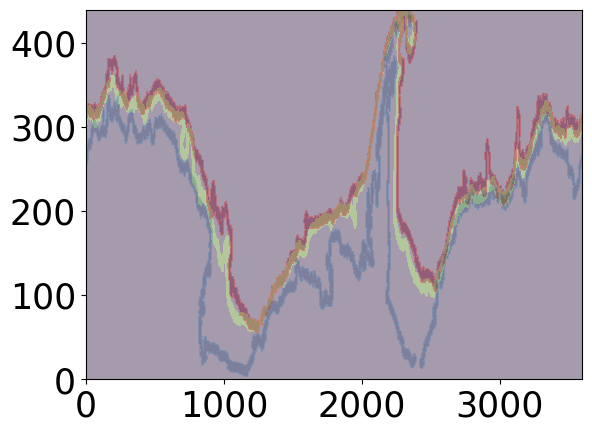

In [31]:
plt.contourf(within_N_km)
plt.contourf(within_N_km_N, alpha = 0.5, cmap = 'Reds')
plt.contourf(within_N_km_S, alpha = 0.25, cmap = 'Blues')

In [32]:
import gc

In [ ]:
@delayed
def area_depth_ave(var_within_N_km,areas_within_N_km):
    #var_t: one time step of 
    return  np.nansum(var_within_N_km * areas_within_N_km) / np.nansum(areas_within_N_km)


def area_ave_quantity_Nkm_range(var_name, within_N_km, time_range):
    #var_grid: 2d quantity
    # Select grid points within N km of the contour
     # within_N_km
    #var_name: str for variable name
      
    ## save temp differences depth-av
    var = cc.querying.getvar(expt=expt, variable= var_name, 
                              session=session, frequency='1 monthly', \
                             chunks = {'time': 100,  'yt_ocean':500, 'xt_ocean':1200})\
            .sel(yt_ocean = slice(-79,-60))#.load()
    var_grid = var * cluster_mask_access
    print(var_grid)
    areas_within_N_km = (area_t*cluster_mask_access).values[within_N_km]
    
    delayed_results = []
    for tt in time_range:
        print(' tt= ', tt)
            
        var_depthav = (var_grid.isel(time = tt)*thickness).sum('st_ocean') / thickness.sum('st_ocean')
        var_within_N_km = var_depthav.values[within_N_km]
        # Calculate the area-weighted average temperature
        results = area_depth_ave(var_within_N_km,areas_within_N_km)
        delayed_results.append(results)
        
    weighted_avg_var = compute(*delayed_results)
    return weighted_avg_var

In [ ]:
from dask import persist

In [46]:
%%time
weighted_avg_temp = area_ave_quantity_Nkm_range('temp', within_N_km,range(50))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  0
 tt=  1
 tt=  2
 tt=  3
 tt=  4
 tt=  5
 tt=  6
 tt=  7
 tt=  8
 tt=  9
 tt=  10
 tt=  11
 tt=  12
 tt=  13
 tt=  14
 tt=  15
 tt=  16
 tt=  17
 tt=  18
 tt=  19
 tt=  20
 tt=  21
 tt=  22
 tt=  23
 tt=  24
 tt=  25
 tt=  26
 tt=  27
 tt=  28
 tt=  29
 tt=  30
 tt=  31
 tt=  32
 tt=  33
 tt=  34
 tt=  35
 tt=  36
 tt=  37
 tt=  38
 tt=  39
 tt=  40
 tt=  41
 tt=  42
 tt=  43
 tt=  44
 tt=  45
 tt=  46
 tt=  47
 tt=  48
 tt=  49
CPU times: user 6min 41s, sy

In [48]:
%%time
weighted_avg_temp_2 = area_ave_quantity_Nkm_range('temp', within_N_km,range(50,200))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  50
 tt=  51
 tt=  52
 tt=  53
 tt=  54
 tt=  55
 tt=  56
 tt=  57
 tt=  58
 tt=  59
 tt=  60
 tt=  61
 tt=  62
 tt=  63
 tt=  64
 tt=  65
 tt=  66
 tt=  67
 tt=  68
 tt=  69
 tt=  70
 tt=  71
 tt=  72
 tt=  73
 tt=  74
 tt=  75
 tt=  76
 tt=  77
 tt=  78
 tt=  79
 tt=  80
 tt=  81
 tt=  82
 tt=  83
 tt=  84
 tt=  85
 tt=  86
 tt=  87
 tt=  88
 tt=  89
 tt=  90
 tt=  91
 tt=  92
 tt=  93
 tt=  94
 tt=  95
 tt=  96
 tt=  97
 tt=  98
 tt=  99
 tt=  100
 tt=  10

In [46]:
%%time 
# with thickness weighting in parallel
weighted_avg_temp_3 = area_ave_quantity_Nkm_range('temp', within_N_km,range(200,250))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  200
 tt=  201
 tt=  202
 tt=  203
 tt=  204
 tt=  205
 tt=  206
 tt=  207
 tt=  208
 tt=  209
 tt=  210
 tt=  211
 tt=  212
 tt=  213
 tt=  214
 tt=  215
 tt=  216
 tt=  217
 tt=  218
 tt=  219
 tt=  220
 tt=  221
 tt=  222
 tt=  223
 tt=  224
 tt=  225
 tt=  226
 tt=  227
 tt=  228
 tt=  229
 tt=  230
 tt=  231
 tt=  232
 tt=  233
 tt=  234
 tt=  235
 tt=  236
 tt=  237
 tt=  238
 tt=  239
 tt=  240
 tt=  241
 tt=  242
 tt=  243
 tt=  244
 tt=  245
 tt=  24

In [55]:
%%time
# - using N = 30km
weighted_avg_temp_30 = area_ave_quantity_Nkm_range('temp', within_N_km,range(200))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  0
 tt=  1
 tt=  2
 tt=  3
 tt=  4
 tt=  5
 tt=  6
 tt=  7
 tt=  8
 tt=  9
 tt=  10
 tt=  11
 tt=  12
 tt=  13
 tt=  14
 tt=  15
 tt=  16
 tt=  17
 tt=  18
 tt=  19
 tt=  20
 tt=  21
 tt=  22
 tt=  23
 tt=  24
 tt=  25
 tt=  26
 tt=  27
 tt=  28
 tt=  29
 tt=  30
 tt=  31
 tt=  32
 tt=  33
 tt=  34
 tt=  35
 tt=  36
 tt=  37
 tt=  38
 tt=  39
 tt=  40
 tt=  41
 tt=  42
 tt=  43
 tt=  44
 tt=  45
 tt=  46
 tt=  47
 tt=  48
 tt=  49
 tt=  50
 tt=  51
 tt=  52
 

In [40]:
%%time
weighted_avg_temp_30_2 = area_ave_quantity_Nkm_range('temp', within_N_km,range(200,600))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  200
 tt=  201
 tt=  202
 tt=  203
 tt=  204
 tt=  205
 tt=  206
 tt=  207
 tt=  208
 tt=  209
 tt=  210
 tt=  211
 tt=  212
 tt=  213
 tt=  214
 tt=  215
 tt=  216
 tt=  217
 tt=  218
 tt=  219
 tt=  220
 tt=  221
 tt=  222
 tt=  223
 tt=  224
 tt=  225
 tt=  226
 tt=  227
 tt=  228
 tt=  229
 tt=  230
 tt=  231
 tt=  232
 tt=  233
 tt=  234
 tt=  235
 tt=  236
 tt=  237
 tt=  238
 tt=  239
 tt=  240
 tt=  241
 tt=  242
 tt=  243
 tt=  244
 tt=  245
 tt=  24

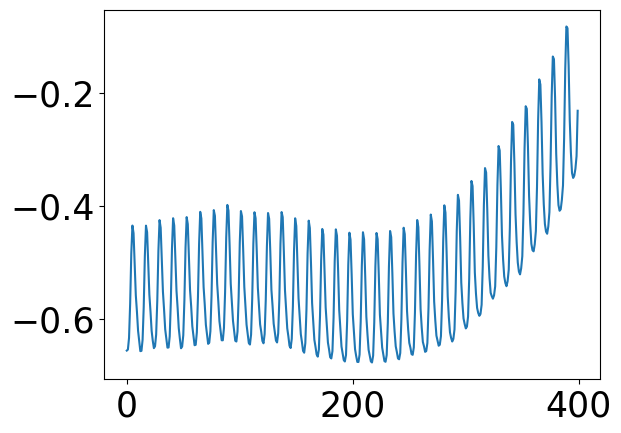

In [42]:
plt.plot(np.array(weighted_avg_temp_30_2) - 273)

In [46]:
xr.DataArray(np.array(weighted_avg_temp_30_2)).to_netcdf('temp_N30_ASC_AcoC_t200_600.nc')

In [ ]:
xr.DataArray(weighted_avg_temp_30).to_netcdf('temp_N30_ASC_AcoC_t0_200.nc')

In [ ]:
%%time
weighted_avg_salt_30 = area_ave_quantity_Nkm_range('salt', within_N_km,range(0,200))

In [48]:
xr.DataArray(np.array(weighted_avg_salt_30)).to_netcdf('salt_N30_ASC_AcoC_t0_200.nc')

In [45]:
%%time
weighted_avg_salt_30_2 = area_ave_quantity_Nkm_range('salt', within_N_km,range(200,400))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  200
 tt=  201
 tt=  202
 tt=  203
 tt=  204
 tt=  205
 tt=  206
 tt=  207
 tt=  208
 tt=  209
 tt=  210
 tt=  211
 tt=  212
 tt=  213
 tt=  214
 tt=  215
 tt=  216
 tt=  217
 tt=  218
 tt=  219
 tt=  220
 tt=  221
 tt=  222
 tt=  223
 tt=  224
 tt=  225
 tt=  226
 tt=  227
 tt=  228
 tt=  229
 tt=  230
 tt=  231
 tt=  232
 tt=  233
 tt=  234
 tt=  235
 tt=  236
 tt=  237
 tt=  238
 tt=  239
 tt=  240
 tt=  241
 tt=  242
 tt=  243
 tt=  244
 tt=  245
 tt=  24

In [46]:
xr.DataArray(np.array(weighted_avg_salt_30_2)).to_netcdf('salt_N30_ASC_AcoC_t200_400.nc')

In [ ]:
%%time
weighted_avg_salt_30_3 = area_ave_quantity_Nkm_range('salt', within_N_km,range(400,600))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  400
 tt=  401
 tt=  402
 tt=  403
 tt=  404
 tt=  405
 tt=  406
 tt=  407
 tt=  408
 tt=  409
 tt=  410
 tt=  411
 tt=  412
 tt=  413
 tt=  414
 tt=  415
 tt=  416
 tt=  417
 tt=  418
 tt=  419
 tt=  420
 tt=  421
 tt=  422
 tt=  423
 tt=  424
 tt=  425
 tt=  426
 tt=  427
 tt=  428
 tt=  429
 tt=  430
 tt=  431
 tt=  432
 tt=  433
 tt=  434
 tt=  435
 tt=  436
 tt=  437
 tt=  438
 tt=  439
 tt=  440
 tt=  441
 tt=  442
 tt=  443
 tt=  444
 tt=  445
 tt=  44

In [ ]:
xr.DataArray(np.array(weighted_avg_salt_30_3)).to_netcdf('salt_N30_ASC_AcoC_t400_600.nc')

In [106]:
%%time
# - using N = 30km
weighted_avg_salt_30 = area_ave_quantity_Nkm_range('salt', within_N_km_N,range(200))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  0
 tt=  1
 tt=  2
 tt=  3
 tt=  4
 tt=  5
 tt=  6
 tt=  7
 tt=  8
 tt=  9
 tt=  10
 tt=  11
 tt=  12
 tt=  13
 tt=  14
 tt=  15
 tt=  16
 tt=  17
 tt=  18
 tt=  19
 tt=  20
 tt=  21
 tt=  22
 tt=  23
 tt=  24
 tt=  25
 tt=  26
 tt=  27
 tt=  28
 tt=  29
 tt=  30
 tt=  31
 tt=  32
 tt=  33
 tt=  34
 tt=  35
 tt=  36
 tt=  37
 tt=  38
 tt=  39
 tt=  40
 tt=  41
 tt=  42
 tt=  43
 tt=  44
 tt=  45
 tt=  46
 tt=  47
 tt=  48
 tt=  49
 tt=  50
 tt=  51
 tt=  52
 

In [107]:
xr.DataArray(np.array(weighted_avg_salt_30)).to_netcdf('salt_N30_ASC_N_t0_200.nc')

In [ ]:
%%time
# - using N = 30km
weighted_avg_salt_30_2 = area_ave_quantity_Nkm_range('salt', within_N_km_N,range(200,400))

In [109]:
xr.DataArray(np.array(weighted_avg_salt_30_2)).to_netcdf('salt_N30_ASC_N_t200_400.nc')

In [39]:
%%time
weighted_avg_salt_30_3 = area_ave_quantity_Nkm_range('salt', within_N_km_N,range(400,600))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  400
 tt=  401
 tt=  402
 tt=  403
 tt=  404
 tt=  405
 tt=  406
 tt=  407
 tt=  408
 tt=  409
 tt=  410
 tt=  411
 tt=  412
 tt=  413
 tt=  414
 tt=  415
 tt=  416
 tt=  417
 tt=  418
 tt=  419
 tt=  420
 tt=  421
 tt=  422
 tt=  423
 tt=  424
 tt=  425
 tt=  426
 tt=  427
 tt=  428
 tt=  429
 tt=  430
 tt=  431
 tt=  432
 tt=  433
 tt=  434
 tt=  435
 tt=  436
 tt=  437
 tt=  438
 tt=  439
 tt=  440
 tt=  441
 tt=  442
 tt=  443
 tt=  444
 tt=  445
 tt=  44

In [40]:
xr.DataArray(np.array(weighted_avg_salt_30_3)).to_netcdf('salt_N30_ASC_N_t400_600.nc')

In [41]:
%%time
# - using N = 30km
weighted_avg_temp_30 = area_ave_quantity_Nkm_range('temp', within_N_km_N,range(200))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  0
 tt=  1
 tt=  2
 tt=  3
 tt=  4
 tt=  5
 tt=  6
 tt=  7
 tt=  8
 tt=  9
 tt=  10
 tt=  11
 tt=  12
 tt=  13
 tt=  14
 tt=  15
 tt=  16
 tt=  17
 tt=  18
 tt=  19
 tt=  20
 tt=  21
 tt=  22
 tt=  23
 tt=  24
 tt=  25
 tt=  26
 tt=  27
 tt=  28
 tt=  29
 tt=  30
 tt=  31
 tt=  32
 tt=  33
 tt=  34
 tt=  35
 tt=  36
 tt=  37
 tt=  38
 tt=  39
 tt=  40
 tt=  41
 tt=  42
 tt=  43
 tt=  44
 tt=  45
 tt=  46
 tt=  47
 tt=  48
 tt=  49
 tt=  50
 tt=  51
 tt=  52
 

In [42]:
xr.DataArray(np.array(weighted_avg_temp_30)).to_netcdf('temp_N30_ASC_N_t0_200.nc')

In [47]:
%%time
# - using N = 30km
weighted_avg_temp_30_2 = area_ave_quantity_Nkm_range('temp', within_N_km_N,range(200,400))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  200
 tt=  201
 tt=  202
 tt=  203
 tt=  204
 tt=  205
 tt=  206
 tt=  207
 tt=  208
 tt=  209
 tt=  210
 tt=  211
 tt=  212
 tt=  213
 tt=  214
 tt=  215
 tt=  216
 tt=  217
 tt=  218
 tt=  219
 tt=  220
 tt=  221
 tt=  222
 tt=  223
 tt=  224
 tt=  225
 tt=  226
 tt=  227
 tt=  228
 tt=  229
 tt=  230
 tt=  231
 tt=  232
 tt=  233
 tt=  234
 tt=  235
 tt=  236
 tt=  237
 tt=  238
 tt=  239
 tt=  240
 tt=  241
 tt=  242
 tt=  243
 tt=  244
 tt=  245
 tt=  24

In [48]:
xr.DataArray(np.array(weighted_avg_temp_30_2)).to_netcdf('temp_N30_ASC_N_t200_400.nc')

In [49]:
%%time
weighted_avg_temp_30_3 = area_ave_quantity_Nkm_range('temp', within_N_km_N,range(400,600))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  400
 tt=  401
 tt=  402
 tt=  403
 tt=  404
 tt=  405
 tt=  406
 tt=  407
 tt=  408
 tt=  409
 tt=  410
 tt=  411
 tt=  412
 tt=  413
 tt=  414
 tt=  415
 tt=  416
 tt=  417
 tt=  418
 tt=  419
 tt=  420
 tt=  421
 tt=  422
 tt=  423
 tt=  424
 tt=  425
 tt=  426
 tt=  427
 tt=  428
 tt=  429
 tt=  430
 tt=  431
 tt=  432
 tt=  433
 tt=  434
 tt=  435
 tt=  436
 tt=  437
 tt=  438
 tt=  439
 tt=  440
 tt=  441
 tt=  442
 tt=  443
 tt=  444
 tt=  445
 tt=  44

In [50]:
xr.DataArray(np.array(weighted_avg_temp_30_3)).to_netcdf('temp_N30_ASC_N_t400_600.nc')

In [ ]:
#ACoC_S

In [38]:
pwd

'/home/561/qo9901'

In [39]:
%%time
# - using N = 30km
weighted_avg_salt_30 = area_ave_quantity_Nkm_range('salt', within_N_km_S,range(200))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  0
 tt=  1
 tt=  2
 tt=  3
 tt=  4
 tt=  5
 tt=  6
 tt=  7
 tt=  8
 tt=  9
 tt=  10
 tt=  11
 tt=  12
 tt=  13
 tt=  14
 tt=  15
 tt=  16
 tt=  17
 tt=  18
 tt=  19
 tt=  20
 tt=  21
 tt=  22
 tt=  23
 tt=  24
 tt=  25
 tt=  26
 tt=  27
 tt=  28
 tt=  29
 tt=  30
 tt=  31
 tt=  32
 tt=  33
 tt=  34
 tt=  35
 tt=  36
 tt=  37
 tt=  38
 tt=  39
 tt=  40
 tt=  41
 tt=  42
 tt=  43
 tt=  44
 tt=  45
 tt=  46
 tt=  47
 tt=  48
 tt=  49
 tt=  50
 tt=  51
 tt=  52
 

In [40]:
xr.DataArray(np.array(weighted_avg_salt_30)).to_netcdf('salt_N30_ACoC_S_t0_200.nc')

In [41]:
%%time
# - using N = 30km
weighted_avg_salt_30_2 = area_ave_quantity_Nkm_range('salt', within_N_km_S,range(200,400))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  200
 tt=  201
 tt=  202
 tt=  203
 tt=  204
 tt=  205
 tt=  206
 tt=  207
 tt=  208
 tt=  209
 tt=  210
 tt=  211
 tt=  212
 tt=  213
 tt=  214
 tt=  215
 tt=  216
 tt=  217
 tt=  218
 tt=  219
 tt=  220
 tt=  221
 tt=  222
 tt=  223
 tt=  224
 tt=  225
 tt=  226
 tt=  227
 tt=  228
 tt=  229
 tt=  230
 tt=  231
 tt=  232
 tt=  233
 tt=  234
 tt=  235
 tt=  236
 tt=  237
 tt=  238
 tt=  239
 tt=  240
 tt=  241
 tt=  242
 tt=  243
 tt=  244
 tt=  245
 tt=  24

In [42]:
xr.DataArray(np.array(weighted_avg_salt_30_2)).to_netcdf('salt_N30_ACoC_S_t200_400.nc')

In [43]:
%%time
weighted_avg_salt_30_3 = area_ave_quantity_Nkm_range('salt', within_N_km_S,range(400,600))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  400
 tt=  401
 tt=  402
 tt=  403
 tt=  404
 tt=  405
 tt=  406
 tt=  407
 tt=  408
 tt=  409
 tt=  410
 tt=  411
 tt=  412
 tt=  413
 tt=  414
 tt=  415
 tt=  416
 tt=  417
 tt=  418
 tt=  419
 tt=  420
 tt=  421
 tt=  422
 tt=  423
 tt=  424
 tt=  425
 tt=  426
 tt=  427
 tt=  428
 tt=  429
 tt=  430
 tt=  431
 tt=  432
 tt=  433
 tt=  434
 tt=  435
 tt=  436
 tt=  437
 tt=  438
 tt=  439
 tt=  440
 tt=  441
 tt=  442
 tt=  443
 tt=  444
 tt=  445
 tt=  44

In [44]:
xr.DataArray(np.array(weighted_avg_salt_30_3)).to_netcdf('salt_N30_ACoC_S_t400_600.nc')

In [45]:
%%time
weighted_avg_temp_30 = area_ave_quantity_Nkm_range('temp', within_N_km_S,range(200))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  0
 tt=  1
 tt=  2
 tt=  3
 tt=  4
 tt=  5
 tt=  6
 tt=  7
 tt=  8
 tt=  9
 tt=  10
 tt=  11
 tt=  12
 tt=  13
 tt=  14
 tt=  15
 tt=  16
 tt=  17
 tt=  18
 tt=  19
 tt=  20
 tt=  21
 tt=  22
 tt=  23
 tt=  24
 tt=  25
 tt=  26
 tt=  27
 tt=  28
 tt=  29
 tt=  30
 tt=  31
 tt=  32
 tt=  33
 tt=  34
 tt=  35
 tt=  36
 tt=  37
 tt=  38
 tt=  39
 tt=  40
 tt=  41
 tt=  42
 tt=  43
 tt=  44
 tt=  45
 tt=  46
 tt=  47
 tt=  48
 tt=  49
 tt=  50
 tt=  51
 tt=  52
 

In [46]:
xr.DataArray(np.array(weighted_avg_temp_30)).to_netcdf('temp_N30_ACoC_S_t0_200.nc')

In [47]:
%%time
# - using N = 30km
weighted_avg_temp_30_2 = area_ave_quantity_Nkm_range('temp', within_N_km_S,range(200,400))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  200
 tt=  201
 tt=  202
 tt=  203
 tt=  204
 tt=  205
 tt=  206
 tt=  207
 tt=  208
 tt=  209
 tt=  210
 tt=  211
 tt=  212
 tt=  213
 tt=  214
 tt=  215
 tt=  216
 tt=  217
 tt=  218
 tt=  219
 tt=  220
 tt=  221
 tt=  222
 tt=  223
 tt=  224
 tt=  225
 tt=  226
 tt=  227
 tt=  228
 tt=  229
 tt=  230
 tt=  231
 tt=  232
 tt=  233
 tt=  234
 tt=  235
 tt=  236
 tt=  237
 tt=  238
 tt=  239
 tt=  240
 tt=  241
 tt=  242
 tt=  243
 tt=  244
 tt=  245
 tt=  24

In [48]:
xr.DataArray(np.array(weighted_avg_temp_30_2)).to_netcdf('temp_N30_ACoC_S_t200_400.nc')

In [ ]:
%%time
weighted_avg_temp_30_3 = area_ave_quantity_Nkm_range('temp', within_N_km_S,range(400,600))

<xarray.DataArray (time: 600, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 285GB
dask.array<mul, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 440, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
 tt=  400
 tt=  401
 tt=  402
 tt=  403
 tt=  404
 tt=  405
 tt=  406
 tt=  407
 tt=  408
 tt=  409
 tt=  410
 tt=  411
 tt=  412
 tt=  413
 tt=  414
 tt=  415
 tt=  416
 tt=  417
 tt=  418
 tt=  419
 tt=  420
 tt=  421
 tt=  422
 tt=  423
 tt=  424
 tt=  425
 tt=  426
 tt=  427
 tt=  428
 tt=  429
 tt=  430
 tt=  431
 tt=  432
 tt=  433
 tt=  434
 tt=  435
 tt=  436
 tt=  437
 tt=  438
 tt=  439
 tt=  440
 tt=  441
 tt=  442
 tt=  443
 tt=  444
 tt=  445
 tt=  44

In [ ]:
xr.DataArray(np.array(weighted_avg_temp_30_3)).to_netcdf('temp_N30_ACoC_S_t400_600.nc')

## Importing to plot

In [24]:
temp_ACoC_S = xr.concat([xr.open_mfdataset('temp_N30_ACoC_S_t0_200.nc'), \
    xr.open_mfdataset('temp_N30_ACoC_S_t200_400.nc'), \
    xr.open_mfdataset('temp_N30_ACoC_S_t400_600.nc')], dim = 'dim_0')
salt_ACoC_S = xr.concat([xr.open_mfdataset('salt_N30_ACoC_S_t0_200.nc'),\
    xr.open_mfdataset('salt_N30_ACoC_S_t200_400.nc'), \
    xr.open_mfdataset('salt_N30_ACoC_S_t400_600.nc')], dim = 'dim_0')

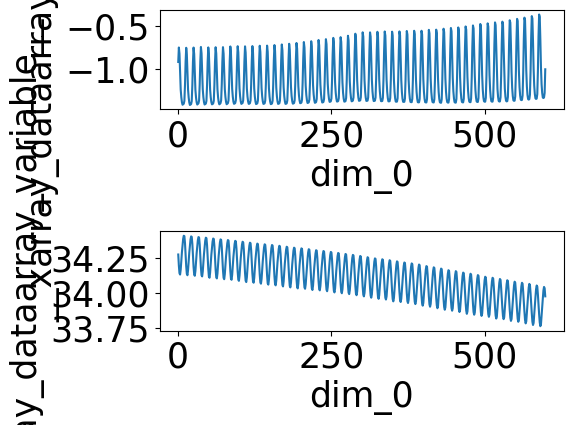

In [25]:
fig, ax = plt.subplots(nrows = 2)
(temp_ACoC_S.__xarray_dataarray_variable__ -273).plot(ax = ax[0])
salt_ACoC_S.__xarray_dataarray_variable__.plot(ax = ax[1])
plt.tight_layout()

In [26]:
temp_ASC_N = xr.concat([xr.open_mfdataset('temp_N30_ASC_N_t0_200.nc'), \
    xr.open_mfdataset('temp_N30_ASC_N_t200_400.nc'), \
    xr.open_mfdataset('temp_N30_ASC_N_t400_600.nc')], dim = 'dim_0')
salt_ASC_N = xr.concat([xr.open_mfdataset('salt_N30_ASC_N_t0_200.nc'),\
    xr.open_mfdataset('salt_N30_ASC_N_t200_400.nc'), \
    xr.open_mfdataset('salt_N30_ASC_N_t400_600.nc')], dim = 'dim_0')

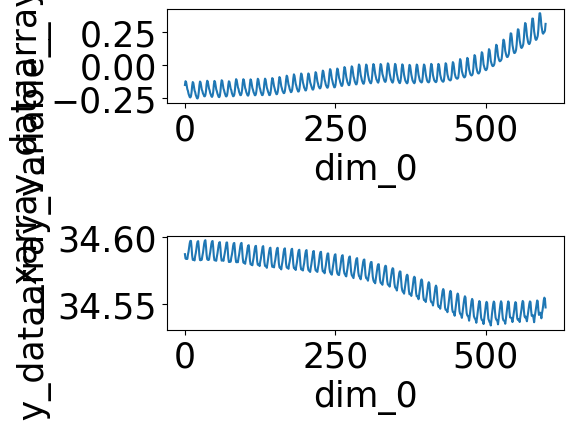

In [27]:
fig, ax = plt.subplots(nrows = 2)
(temp_ASC_N.__xarray_dataarray_variable__ -273).plot(ax = ax[0])
salt_ASC_N.__xarray_dataarray_variable__.plot(ax = ax[1])
plt.tight_layout()

In [28]:
temp_ASC_ACoC = xr.concat([xr.open_mfdataset('temp_N30_ASC_AcoC_t0_200.nc'), \
    xr.open_mfdataset('temp_N30_ASC_AcoC_t200_600.nc')], dim = 'dim_0')
salt_ASC_ACoC = xr.concat([xr.open_mfdataset('salt_N30_ASC_AcoC_t0_200.nc'),\
    xr.open_mfdataset('salt_N30_ASC_AcoC_t200_400.nc'), \
    xr.open_mfdataset('salt_N30_ASC_AcoC_t400_600.nc')], dim = 'dim_0')

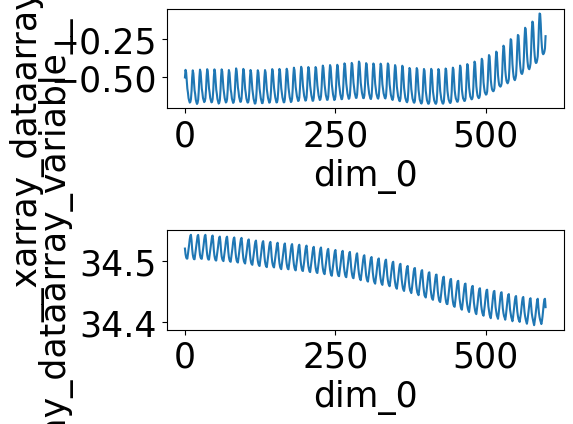

In [29]:
fig, ax = plt.subplots(nrows = 2)
(temp_ASC_ACoC.__xarray_dataarray_variable__ -273).plot(ax = ax[0])
salt_ASC_ACoC.__xarray_dataarray_variable__.plot(ax = ax[1])
plt.tight_layout()

## skip if only plotting --- calculating $\alpha$ and $\beta$ for thermal wind transport calculation

In [37]:
#NB temp - conservative temp
temp = cc.querying.getvar(expt=expt, variable= 'temp', 
                              session=session, frequency='1 monthly', \
                             chunks = {'st_ocean': 80,  'yt_ocean':500, 'xt_ocean':3600})\
            .sel(yt_ocean = slice(-79,-60))* cluster_mask_access
salt = cc.querying.getvar(expt=expt, variable= 'salt', 
                              session=session, frequency='1 monthly', \
                             chunks = {'st_ocean': 80,  'yt_ocean':500, 'xt_ocean':3600})\
            .sel(yt_ocean = slice(-79,-60)) * cluster_mask_access


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3

In [40]:
import gsw

In [43]:
p = gsw.p_from_z(-st_ocean, area_t.yt_ocean)

In [44]:
SA = gsw.SA_from_SP(salt, p, area_t.xt_ocean, area_t.yt_ocean)
## absolute salinity from practical salinity

In [168]:
A = gsw.alpha(SA, temp - 273,p)
alpha_field_xy = (A*thickness).sum('st_ocean')/thickness.sum('st_ocean')
val = (alpha_field_xy*area_t.where(cluster_mask_access == True)).sum(dim = ('xt_ocean','yt_ocean'))\
    /area_t.where(cluster_mask_access == True).sum(dim = ('xt_ocean','yt_ocean'))
val

<xarray.DataArray (time: 600)> Size: 5kB
dask.array<truediv, shape=(600,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00

In [169]:
%%time
val.mean('time').values # depth average alpha for studied region

CPU times: user 4min 9s, sys: 19.3 s, total: 4min 28s
Wall time: 10min 5s


array(5.36631889e-05)

In [170]:
%%time
B = gsw.beta(SA, temp - 273,p)
beta_field_xy = (B*thickness).sum('st_ocean')/thickness.sum('st_ocean')
val_beta = (beta_field_xy*area_t.where(cluster_mask_access == True)).sum(dim = ('xt_ocean','yt_ocean'))\
    /area_t.where(cluster_mask_access == True).sum(dim = ('xt_ocean','yt_ocean'))
val_beta.mean('time').values

CPU times: user 3min 54s, sys: 16.8 s, total: 4min 11s
Wall time: 7min 30s


array(0.00077809)

### skip -- Testing $\alpha$ and $\beta$ for shelf and slope regions 
values do not change much, used depth av $\alpha$ and $\beta$ above for whole study region for simplicity

In [ ]:
%%time
## shelf
A = gsw.alpha(SA, temp - 273,p) *cluster_mask_shelfwcanyons_t
alpha_field_xy = (A*thickness).sum('st_ocean')/thickness.sum('st_ocean')
val = (alpha_field_xy*area_t).sum(dim = ('xt_ocean','yt_ocean'))/area_t.sum(dim = ('xt_ocean','yt_ocean'))
val.mean('time').values

In [ ]:
%%time
# shelf
B = gsw.beta(SA, temp - 273,p) *cluster_mask_shelfwcanyons_t
beta_field_xy = (B*thickness).sum('st_ocean')/thickness.sum('st_ocean')
val_beta = (beta_field_xy*area_t).sum(dim = ('xt_ocean','yt_ocean'))/area_t.sum(dim = ('xt_ocean','yt_ocean'))
val_beta.mean('time').values

In [156]:
%%time
## slope
A = gsw.alpha(SA, temp - 273,p)
alpha_field_xy = (A.where(~cluster_mask_shelfwcanyons_t == True)*thickness).sum('st_ocean')/thickness.sum('st_ocean')
val = (alpha_field_xy*area_t.where(~cluster_mask_shelfwcanyons_t == True).where(cluster_mask_access == True)).sum(dim = ('xt_ocean','yt_ocean'))\
    /area_t.where(~cluster_mask_shelfwcanyons_t == True).where(cluster_mask_access == True).sum(dim = ('xt_ocean','yt_ocean'))
val.mean('time').values

CPU times: user 3min 32s, sys: 17.2 s, total: 3min 49s
Wall time: 8min 28s


array(7.7841671e-05)

In [159]:
%%time
# slope
B = gsw.beta(SA, temp - 273,p)
beta_field_xy = (B.where(~cluster_mask_shelfwcanyons_t == True)*thickness).sum('st_ocean')/thickness.sum('st_ocean')
val_beta = (beta_field_xy*area_t.where(~cluster_mask_shelfwcanyons_t == True).where(cluster_mask_access == True)).sum(dim = ('xt_ocean','yt_ocean'))\
    /area_t.where(~cluster_mask_shelfwcanyons_t == True).where(cluster_mask_access == True).sum(dim = ('xt_ocean','yt_ocean'))
val_beta.mean('time').values

CPU times: user 4min 15s, sys: 19.2 s, total: 4min 34s
Wall time: 9min 32s


array(0.00076975)

## Continue transport calculation using imported data

In [30]:
diff_temp_ASC_t = temp_ASC_ACoC.__xarray_dataarray_variable__ - temp_ASC_N.__xarray_dataarray_variable__
diff_temp_ACoC_t= temp_ACoC_S.__xarray_dataarray_variable__ - temp_ASC_ACoC.__xarray_dataarray_variable__
diff_salt_ASC_t= salt_ASC_ACoC.__xarray_dataarray_variable__ - salt_ASC_N.__xarray_dataarray_variable__
diff_salt_ACoC_t= salt_ACoC_S.__xarray_dataarray_variable__ - salt_ASC_ACoC.__xarray_dataarray_variable__

In [31]:
diff_temp_ASC_t = diff_temp_ASC_t.rename({'dim_0':'time'})
diff_temp_ACoC_t= diff_temp_ACoC_t.rename({'dim_0':'time'})
diff_salt_ASC_t= diff_salt_ASC_t.rename({'dim_0':'time'})
diff_salt_ACoC_t = diff_salt_ACoC_t.rename({'dim_0':'time'})

In [32]:
temp_ASC_ACoC = temp_ASC_ACoC.__xarray_dataarray_variable__.rename({'dim_0':'time'})
temp_ASC_N = temp_ASC_N.__xarray_dataarray_variable__.rename({'dim_0':'time'})
temp_ACoC_S = temp_ACoC_S.__xarray_dataarray_variable__.rename({'dim_0':'time'})
salt_ASC_ACoC = salt_ASC_ACoC.__xarray_dataarray_variable__.rename({'dim_0':'time'})
salt_ASC_N = salt_ASC_N.__xarray_dataarray_variable__.rename({'dim_0':'time'})
salt_ACoC_S = salt_ACoC_S.__xarray_dataarray_variable__.rename({'dim_0':'time'})

In [72]:
# constants
H_ASC = 1000 #[m]
H_ACoC = 200 # [m]
rho = 1035 #[kg/m3]'
alpha = 5.37e-5    # 5.36631889e-05# 3.7e-5 #[K^{-1}] #original 1e-4
beta = 7.78e-4 #   0.00077809# 7.8e-4 # [kg/g]  original 7.5e-4
g = 9.81 # [m/s]
f = -1.3e-4 #[s^{-1}]


## skip if only plotting -- diversion to sweep alpha and beta values

In [34]:
def param_test_calc(g,H,alpha,beta, f):
    return g*H**2/f *(-alpha  * -diff_temp_ASC_t + beta * -diff_salt_ASC_t)

In [35]:
def param_thermal_calc(g,H,alpha,beta, f):
    return g*H**2/f *(-alpha  * -diff_temp_ASC_t)

In [36]:
def param_salt_calc(g,H,alpha,beta, f):
    return g*H**2/f *( beta * -diff_salt_ASC_t)

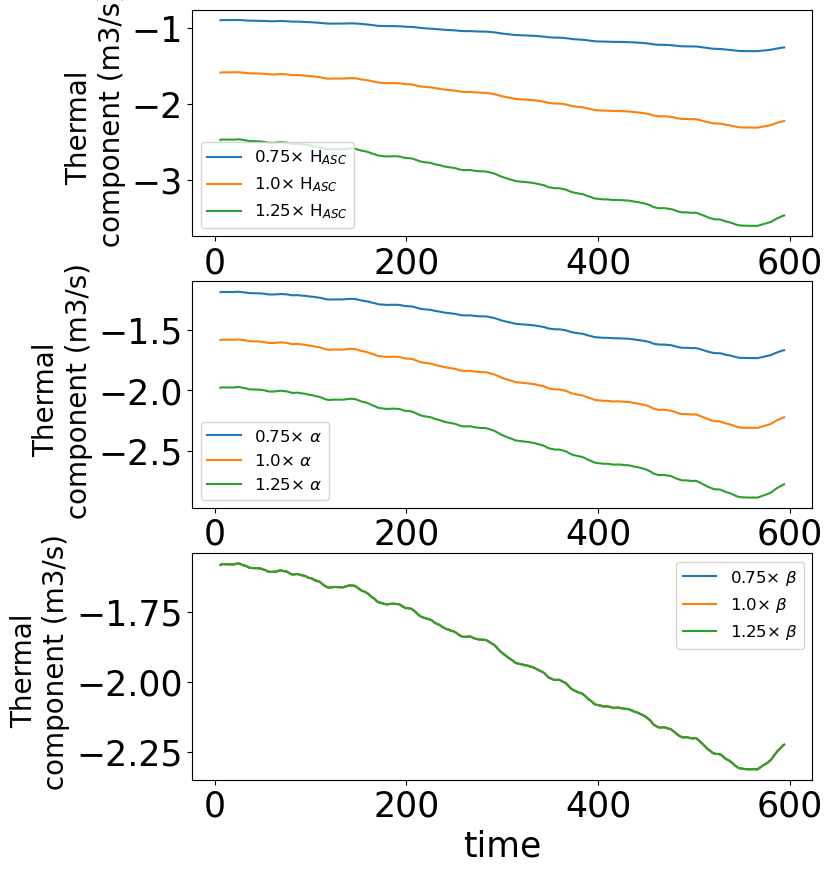

In [37]:
fig, ax = plt.subplots(nrows = 3, figsize = (8,10))

for i in np.arange(0.75,1.5,0.25):
    (-param_thermal_calc(g,H_ASC*i,alpha,beta, f)/1e6).rolling(time = 12, center = True).mean().plot(ax = ax[0], label = str(i) + r'$\times$ H$_{ASC}$')
    (-param_thermal_calc(g,H_ASC,alpha*i,beta, f)/1e6).rolling(time = 12, center = True).mean().plot(ax = ax[1], label = str(i) + r'$\times$ $\alpha$')
    (-param_thermal_calc(g,H_ASC,alpha,beta*i, f)/1e6).rolling(time = 12, center = True).mean().plot(ax = ax[2], label = str(i) + r'$\times$ $\beta$')
    #(-param_test_calc(g,H_ASC,alpha,beta, f*i)/1e6).rolling(time = 12, center = True).mean().plot(ax = ax[3], label = str(i) + r'$\times$ f')

for row in range(3):
    ax[row].set_ylabel('Thermal \n component (m3/s)', fontsize = 20)
    ax[row].legend(fontsize = 12)


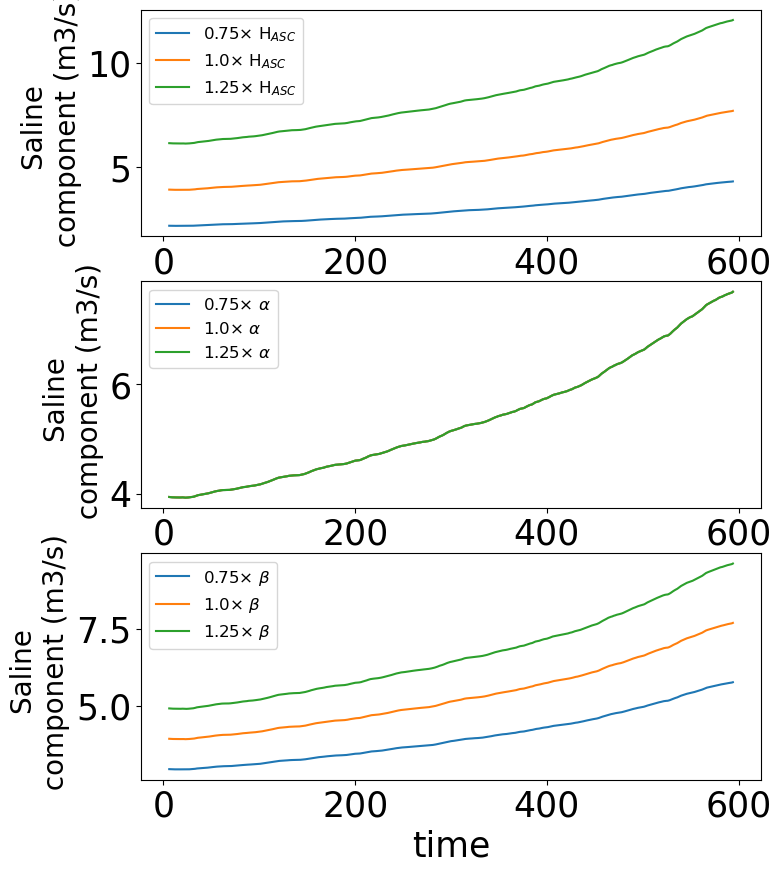

In [51]:
fig, ax = plt.subplots(nrows = 3, figsize = (8,10))

for i in np.arange(0.75,1.5,0.25):
    (-param_salt_calc(g,H_ASC*i,alpha,beta, f)/1e6).rolling(time = 12, center = True).mean().plot(ax = ax[0], label = str(i) + r'$\times$ H$_{ASC}$')
    (-param_salt_calc(g,H_ASC,alpha*i,beta, f)/1e6).rolling(time = 12, center = True).mean().plot(ax = ax[1], label = str(i) + r'$\times$ $\alpha$')
    (-param_salt_calc(g,H_ASC,alpha,beta*i, f)/1e6).rolling(time = 12, center = True).mean().plot(ax = ax[2], label = str(i) + r'$\times$ $\beta$')
    #(-param_test_calc(g,H_ASC,alpha,beta, f*i)/1e6).rolling(time = 12, center = True).mean().plot(ax = ax[3], label = str(i) + r'$\times$ f')

for row in range(3):
    ax[row].set_ylabel('Saline \n component (m3/s)', fontsize = 20)
    ax[row].legend(fontsize = 12)


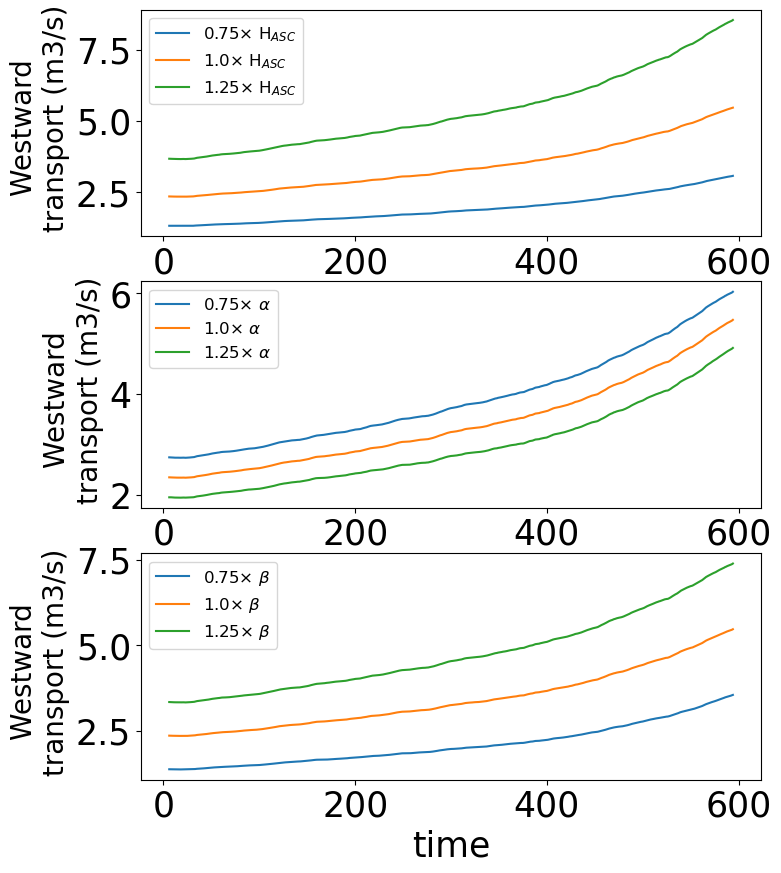

In [52]:
fig, ax = plt.subplots(nrows = 3, figsize = (8,10))

for i in np.arange(0.75,1.5,0.25):
    (-param_test_calc(g,H_ASC*i,alpha,beta, f)/1e6).rolling(time = 12, center = True).mean().plot(ax = ax[0], label = str(i) + r'$\times$ H$_{ASC}$')
    (-param_test_calc(g,H_ASC,alpha*i,beta, f)/1e6).rolling(time = 12, center = True).mean().plot(ax = ax[1], label = str(i) + r'$\times$ $\alpha$')
    (-param_test_calc(g,H_ASC,alpha,beta*i, f)/1e6).rolling(time = 12, center = True).mean().plot(ax = ax[2], label = str(i) + r'$\times$ $\beta$')
    #(-param_test_calc(g,H_ASC,alpha,beta, f*i)/1e6).rolling(time = 12, center = True).mean().plot(ax = ax[3], label = str(i) + r'$\times$ f')

for row in range(3):
    ax[row].set_ylabel('Westward \n transport (m3/s)', fontsize = 20)
    ax[row].legend(fontsize = 12)


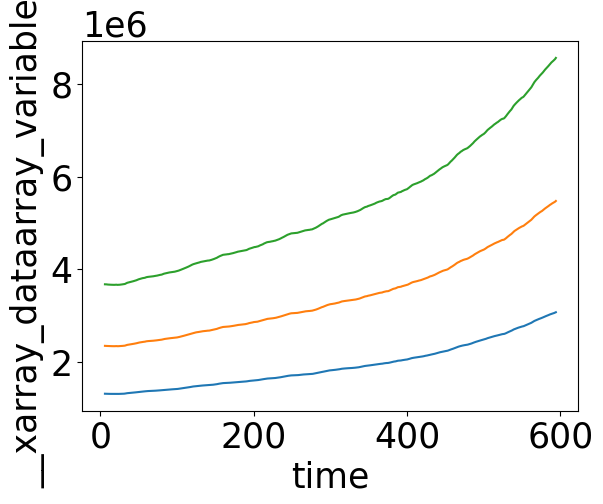

In [53]:
T_ASC_750 = g*750**2/f *(-alpha  * -diff_temp_ASC_t + beta * -diff_salt_ASC_t)
T_ASC_1000 = g*1000**2/f *(-alpha  * -diff_temp_ASC_t + beta * -diff_salt_ASC_t)
T_ASC_1250 = g*1250**2/f *(-alpha  * -diff_temp_ASC_t + beta * -diff_salt_ASC_t)
(-T_ASC_750).rolling(time = 12, center = True).mean().plot()
(-T_ASC_1000).rolling(time = 12, center = True).mean().plot()
(-T_ASC_1250).rolling(time = 12, center = True).mean().plot()

alpha_ASC = 
alpha_ACoC = -1e-4
beta_ASC = 
beta_ACoC = 1e-4

## continue plotting

In [44]:
T_ASC = g*H_ASC**2/f *(-alpha  * -diff_temp_ASC_t + beta * -diff_salt_ASC_t)
T_ACoC = g*H_ACoC**2/f *(-alpha  * -diff_temp_ACoC_t + beta * -diff_salt_ACoC_t)
## salt diff calculates a S - N, minus signs to reverse
# in [Sv]

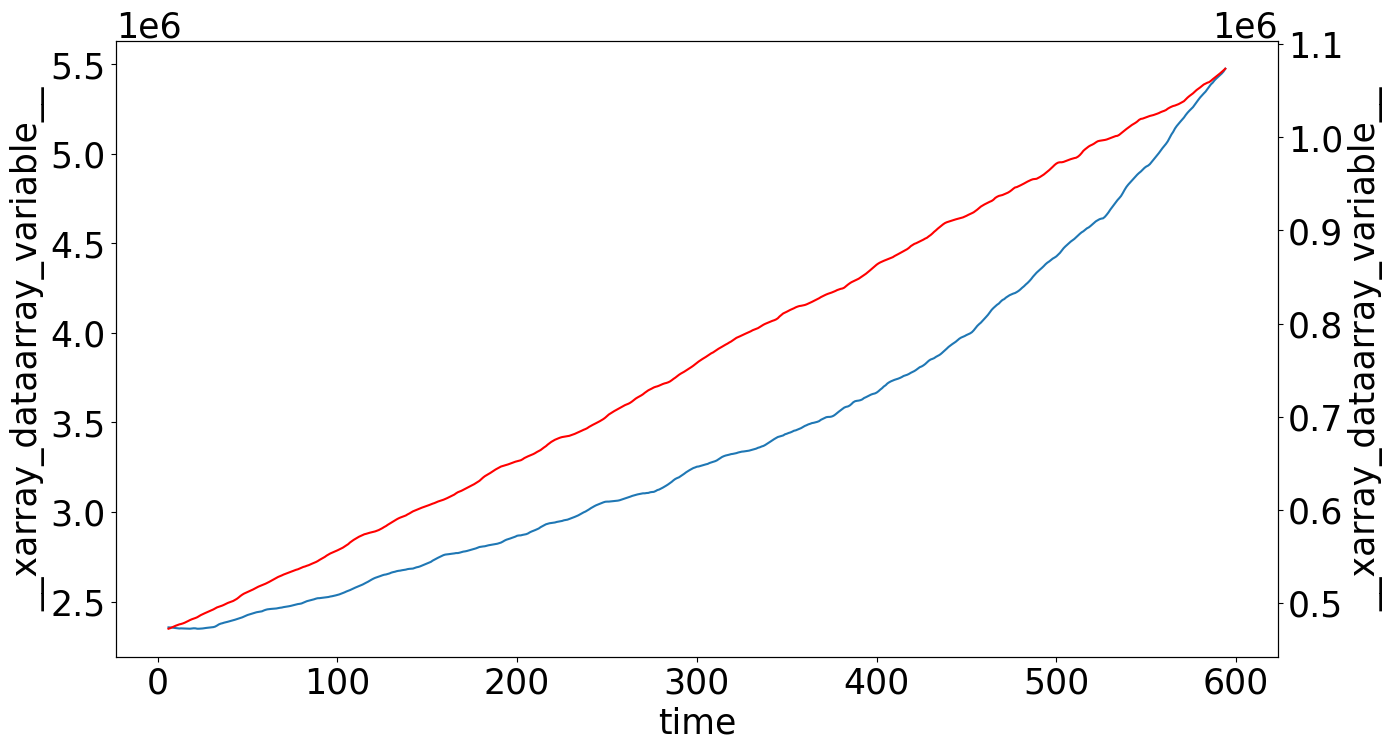

In [45]:
fig, ax = plt.subplots(figsize = (15,8))
(-T_ASC).rolling(time = 12, center = True).mean().plot()
#ax.set_ylim([5.92e8,5.98e8])
ax2 = ax.twinx()
(-T_ACoC).rolling(time = 12, center = True).mean().plot(color = 'r')
#ax2.set_ylim([2.56e6 ,2.56e6 + 0.06e8])


In [46]:
 temp_comp_ASC = g*H_ASC**2/f *(-alpha  * -diff_temp_ASC_t)
salt_comp_ASC = g*H_ASC**2/f *(beta * -diff_salt_ASC_t)
 temp_comp_ACoC = g*H_ACoC**2/f *(-alpha  * -diff_temp_ACoC_t)
salt_comp_ACoC = g*H_ACoC**2/f *(beta * -diff_salt_ACoC_t)

In [47]:
import cftime

In [48]:
from matplotlib.lines import Line2D
'''
legend_elements = [Line2D([0], [0], color=onshore_offshore_clr[0], lw=lw, label='Onshore ACoC'),
                  Line2D([0], [0], color=onshore_offshore_clr[1], lw=lw, label='ACoC and ASC boundary'),
                  Line2D([0], [0], color=onshore_offshore_clr[2], lw=lw, label='Offshore ASC')]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center')
'''

"\nlegend_elements = [Line2D([0], [0], color=onshore_offshore_clr[0], lw=lw, label='Onshore ACoC'),\n                  Line2D([0], [0], color=onshore_offshore_clr[1], lw=lw, label='ACoC and ASC boundary'),\n                  Line2D([0], [0], color=onshore_offshore_clr[2], lw=lw, label='Offshore ASC')]\n\n# Create the figure\nfig, ax = plt.subplots()\nax.legend(handles=legend_elements, loc='center')\n"

In [49]:
T_along_slope_wthmp = -xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/T_along_slope_mintime_' + exp_wthmp + '_masked_diagcorr_wcanyons.nc')/1e6
T_along_slope_wthp = -xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/T_along_slope_mintime_' + exp_wthp + '_masked_diagcorr_wcanyons.nc')/1e6
T_along_slope_ctrl = -xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/T_along_slope_mintime_' + exp_ctrl + '_masked_diagcorr_wcanyons.nc')/1e6
T_along_shelf_wthmp = -xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/T_along_shelf_mintime_' + exp_wthmp + '_diagcorr_wcanyons.nc')/1e6
T_along_shelf_wthp = -xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/T_along_shelf_mintime_' + exp_wthp + '_diagcorr_wcanyons.nc')/1e6
T_along_shelf_ctrl = -xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/T_along_shelf_mintime_' + exp_ctrl + '_diagcorr_wcanyons.nc')/1e6

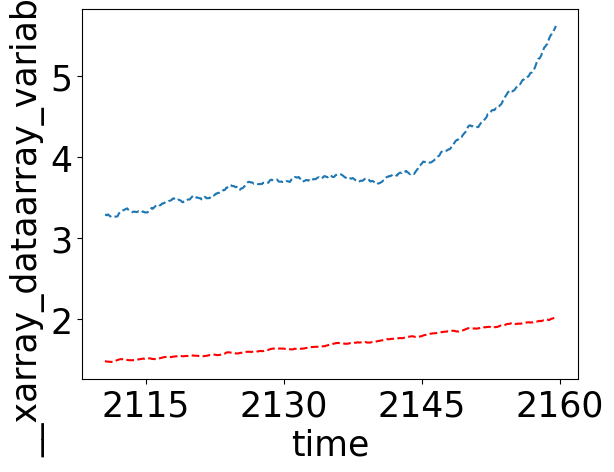

In [73]:
color_line = ['C0','r', 'C7']

T_along_slope_wthmp.__xarray_dataarray_variable__.rolling(time = 12, center = True).mean().plot(c = color_line[0], linestyle = 'dashed')
T_along_shelf_wthmp.__xarray_dataarray_variable__.rolling(time = 12, center = True).mean().plot(c = color_line[1], linestyle = 'dashed')
import matplotlib.lines as mlines

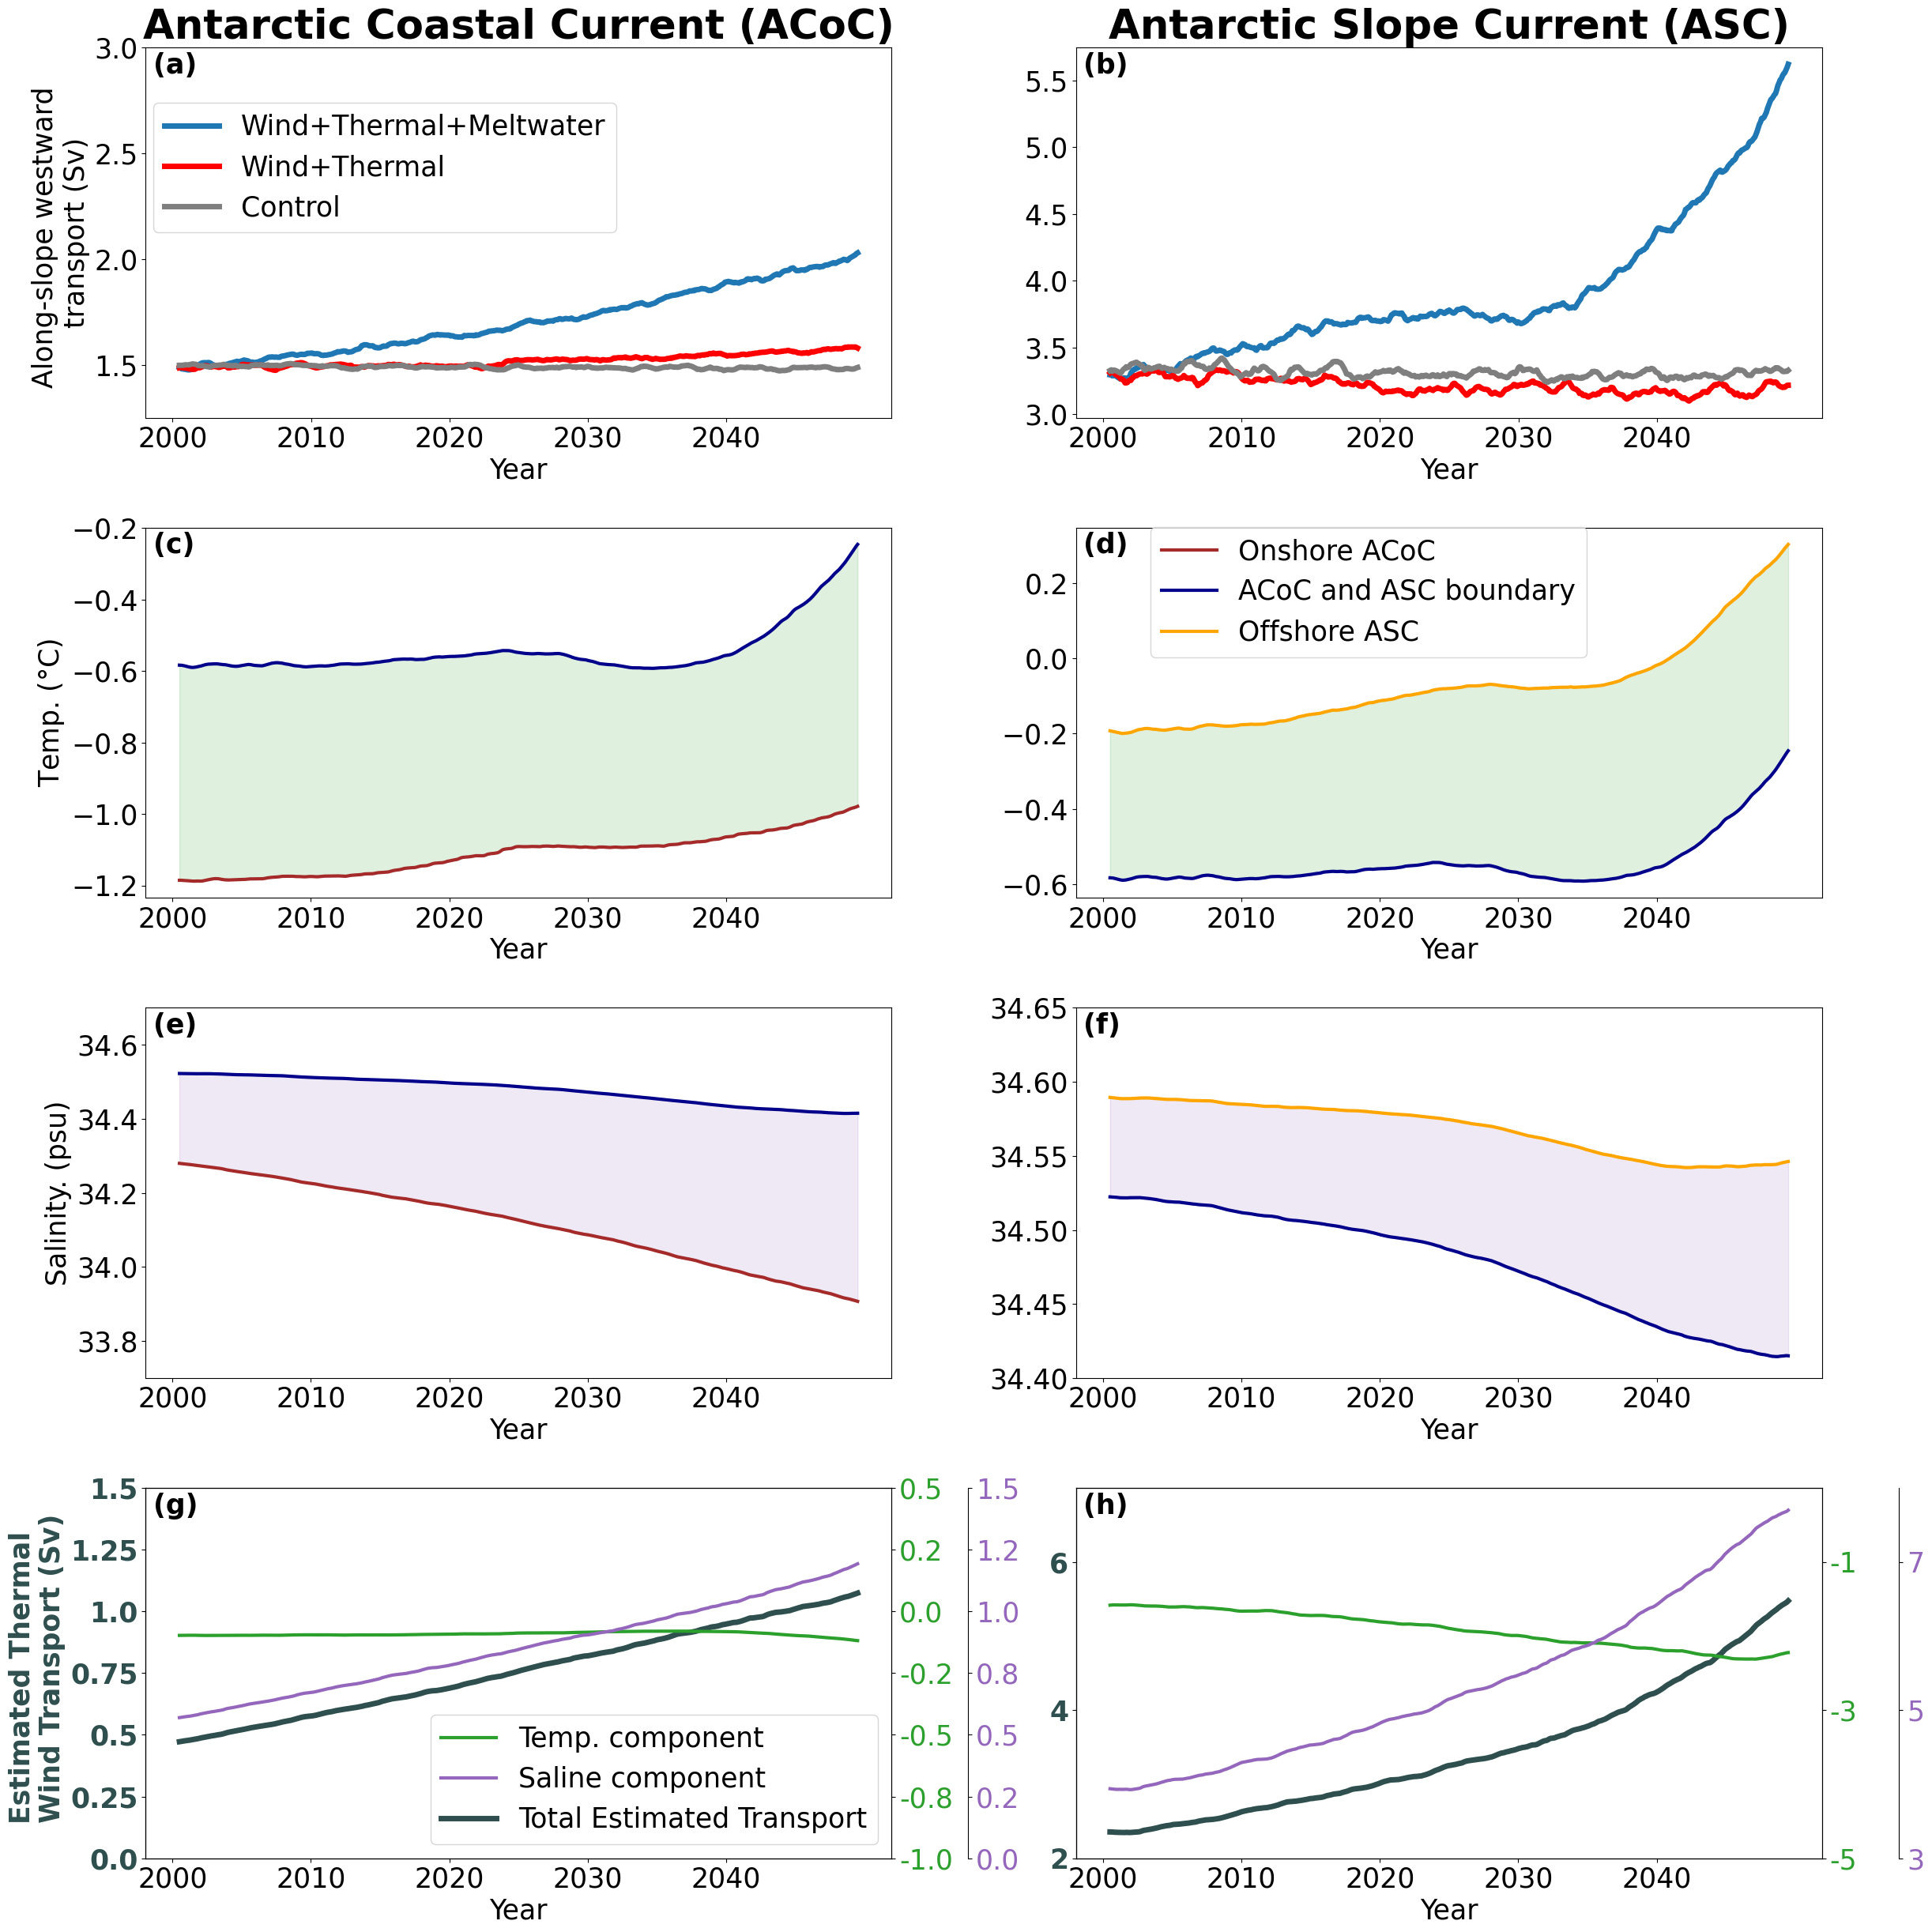

In [74]:
## master plot w exp transport
lw = 3
lw2= 5
#np.set_printoptions(precision=3)
from matplotlib.ticker import FormatStrFormatter

fig,ax = fig, ax = plt.subplot_mosaic("ab;cd;ef;gh", figsize = (25,25))

T_along_slope_wthmp.__xarray_dataarray_variable__.rolling(time = 12, center= True).mean().plot(c = color_line[0], lw = lw2,  ax=ax['b'])
T_along_slope_wthp.__xarray_dataarray_variable__.rolling(time = 12, center= True).mean().plot(c = color_line[1], lw = lw2,  ax=ax['b'])
T_along_slope_ctrl.__xarray_dataarray_variable__.rolling(time = 12, center= True).mean().plot(c = color_line[2], lw = lw2,   ax=ax['b'])

T_along_shelf_wthmp.__xarray_dataarray_variable__.rolling(time = 12, center= True).mean().plot(c = color_line[0], lw = lw2, ax=ax['a'])
T_along_shelf_wthp.__xarray_dataarray_variable__.rolling(time = 12, center= True).mean().plot(c = color_line[1],lw = lw2,  ax=ax['a'])
T_along_shelf_ctrl.__xarray_dataarray_variable__.rolling(time = 12, center= True).mean().plot(c = color_line[2],lw = lw2,   ax=ax['a'])
ax['a'].set_ylabel('Along-slope westward \ntransport (Sv)')
ax['b'].set_ylabel('')
ax['a'].set_ylim([1.25,3])
ax['a'].set_title('Antarctic Coastal Current (ACoC)', weight = 'bold', fontsize = 37)
ax['b'].set_title('Antarctic Slope Current (ASC)', weight = 'bold', fontsize = 37)
green_patch = mlines.Line2D([], [], color='C7', lw = lw2, linestyle='-', label='Control')
orange_patch = mlines.Line2D([], [], color='r',lw = lw2, linestyle='-', label='Wind+Thermal')
blue_patch = mlines.Line2D([], [], color='C0',lw = lw2, linestyle='-', label='Wind+Thermal+Meltwater')

# Creating the legend
ax['a'].legend(handles=[ blue_patch, orange_patch, green_patch], loc=(0.01,0.5))

## temp and saline components
onshore_offshore_clr = ['brown', 'darkblue', 'orange']
total_color= 'darkslategrey'
legend_elements = [Line2D([0], [0], color=onshore_offshore_clr[0], lw=lw, label='Onshore ACoC'),
                  Line2D([0], [0], color=onshore_offshore_clr[1], lw=lw, label='ACoC and ASC boundary'),
                  Line2D([0], [0], color=onshore_offshore_clr[2], lw=lw, label='Offshore ASC')]

(temp_ACoC_S - 273).rolling(time = 12, center = True).mean().plot(\
                                    color = onshore_offshore_clr[0], ax = ax['c'], lw = lw)
(temp_ASC_ACoC- 273).rolling(time = 12, center = True).mean().plot(  \
                                      color = onshore_offshore_clr[1], ax = ax['c'], lw = lw)
ax['c'].fill_between(salt_ACoC_S.time.values, \
                     (temp_ACoC_S- 273).rolling(time = 12, center = True).mean().values,\
                     (temp_ASC_ACoC- 273).rolling(time = 12, center = True).mean().values, \
                     alpha = 0.15, color = 'C2')
#ax['c'].set_ylim([-1.3,-0.3])
ax['c'].set_ylabel(r'Temp. ($\degree$C)')
ax['d'].legend(handles=legend_elements, loc = (0.1,0.65))

(temp_ASC_ACoC- 273).rolling(time = 12, center = True).mean()\
    .plot( color = onshore_offshore_clr[1], ax = ax['d'], lw = lw)
(temp_ASC_N- 273).rolling(time = 12, center = True).mean()\
    .plot( color = onshore_offshore_clr[2],ax = ax['d'], lw = lw)

ax['d'].fill_between(temp_ASC_ACoC.time.values, \
                     (temp_ASC_ACoC- 273).rolling(time = 12, center = True).mean().values,\
                     (temp_ASC_N- 273).rolling(time = 12, center = True).mean().values,\
                     alpha = 0.15, color = 'C2')

#ax['d'].set_ylim([-0.7,0.5])
ax['d'].set_ylabel('')
  
salt_ACoC_S.rolling(time = 12, center = True).mean().plot( color = onshore_offshore_clr[0],ax = ax['e'], lw = lw)
salt_ASC_ACoC.rolling(time = 12, center = True).mean().plot( color = onshore_offshore_clr[1],ax = ax['e'], lw = lw)
ax['e'].fill_between(salt_ACoC_S.time.values, salt_ACoC_S.rolling(time = 12, center = True).mean().values,\
                     salt_ASC_ACoC.rolling(time = 12, center = True).mean().values, alpha = 0.15, color = 'C4')
ax['e'].set_ylim([33.7,34.7])
ax['e'].set_ylabel('Salinity. (psu)')

salt_ASC_ACoC.rolling(time = 12, center = True).mean()\
    .plot( color = onshore_offshore_clr[1],ax = ax['f'], lw = lw)
salt_ASC_N.rolling(time = 12, center = True).mean()\
    .plot( color = onshore_offshore_clr[2], ax = ax['f'], lw = lw)
ax['f'].fill_between(salt_ASC_N.time.values, \
                     salt_ASC_N.rolling(time = 12, center = True).mean().values,\
                     salt_ASC_ACoC.rolling(time = 12, center = True).mean().values, alpha = 0.15, color = 'C4')
ax['f'].set_ylim([34.4,34.65])
ax['f'].set_ylabel('')


(-T_ACoC/1e6).rolling(time = 12, center = True).mean()\
    .plot(ax = ax['g'], label = 'Total Estimated Transport', color = total_color, lw = 5)
ax2 = ax['g'].twinx()
ax['g'].set_ylim([0,1.5])

ax2.spines['right']
(-temp_comp_ACoC/1e6).rolling(time = 12, center = True).mean()\
    .plot( color = 'C2', ax = ax2, lw = lw, label = 'Temp. component')
ax2.set_ylim([-1,0.5])
ax2.set_yticklabels(labels = ax2.get_yticks(), color = 'C2')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.set_ylabel('')

ax3 = ax['g'].twinx()
ax3.spines['right'].set_position(('outward', 70))
ax3.set_ylim([0,1.5])
(-salt_comp_ACoC/1e6).rolling(time = 12, center = True).mean()\
    .plot( color = 'C4', ax = ax3, lw = lw, label = 'Saline component')
ax3.set_yticklabels(labels = ax3.get_yticks(), color = 'C4')
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax3.set_ylabel('', color= 'C4')

ax['g'].set_yticklabels(labels = ax['g'].get_yticks(), color = total_color, fontweight = 'bold')
ax['g'].set_ylabel('Estimated Thermal \n Wind Transport (Sv)', color = total_color, fontweight = 'bold')

### Do everything for plot4 as before
handles4g,labels4g = ax['g'].get_legend_handles_labels()

handles4,labels4 = ax2.get_legend_handles_labels()
### Do everything for plot4a
handles4a,labels4a = ax3.get_legend_handles_labels()
### Combine the legend handles and labels to make a new legend object
handles = handles4 + handles4a + handles4g
labels = labels4 + labels4a+ labels4g


(-T_ASC/1e6).rolling(time = 12, center = True).mean()\
    .plot( label = 'ASC depth-av', ax = ax['h'], lw = 5,color = total_color,ylim = (2,7))
ax['h'].set_yticks(range(2,7,2))
ax['h'].set_yticklabels(labels =  ax['h'].get_yticks(), color = total_color, fontweight = 'bold')
ax['h'].set_ylabel('')

ax4 = ax['h'].twinx()
(-temp_comp_ASC/1e6).rolling(time = 12, center = True).mean()\
    .plot( color = 'C2', ax = ax4, lw = lw, ylim = (-5,0))
ax4.set_yticks(range(-5,0,2))
ax4.set_yticklabels(labels = ax4.get_yticks(), color = 'C2')
ax4.set_ylabel('')

ax5 = ax['h'].twinx()
ax5.spines['right'].set_position(('outward', 70))
ax5.set_yticks(range(3,8,2))
(-salt_comp_ASC/1e6).rolling(time = 12, center = True).mean()\
    .plot( color = 'C4', ax = ax5, lw = lw, ylim = (3,8))
ax5.set_yticklabels(labels = ax5.get_yticks(), color = 'C4')
ax5.set_ylabel('')

for letter in map(chr, range(ord('a'), ord('b')+1)):
        ax[letter].set_xticks(T_along_slope_wthmp.time[::120].values)
        ax[letter].set_xticklabels(np.arange(2000,2050,10))
        ax[letter].set_xlabel('Year')
        ax[letter].text(0.01,0.93,'(' + letter + ')', \
                        transform=ax[letter].transAxes, fontweight = 'bold')
    
for letter in map(chr, range(ord('c'), ord('h')+1)):
        ax[letter].set_xticks(salt_ASC_N.time[::120].values)
        ax[letter].set_xticklabels(np.arange(2000,2050,10))
        ax[letter].set_xlabel('Year')
        ax[letter].text(0.01,0.93,'(' + letter + ')', \
                        transform=ax[letter].transAxes, fontweight = 'bold')
ax['g'].legend(handles, labels, loc = 'lower right')

plt.tight_layout()

In [79]:
import string

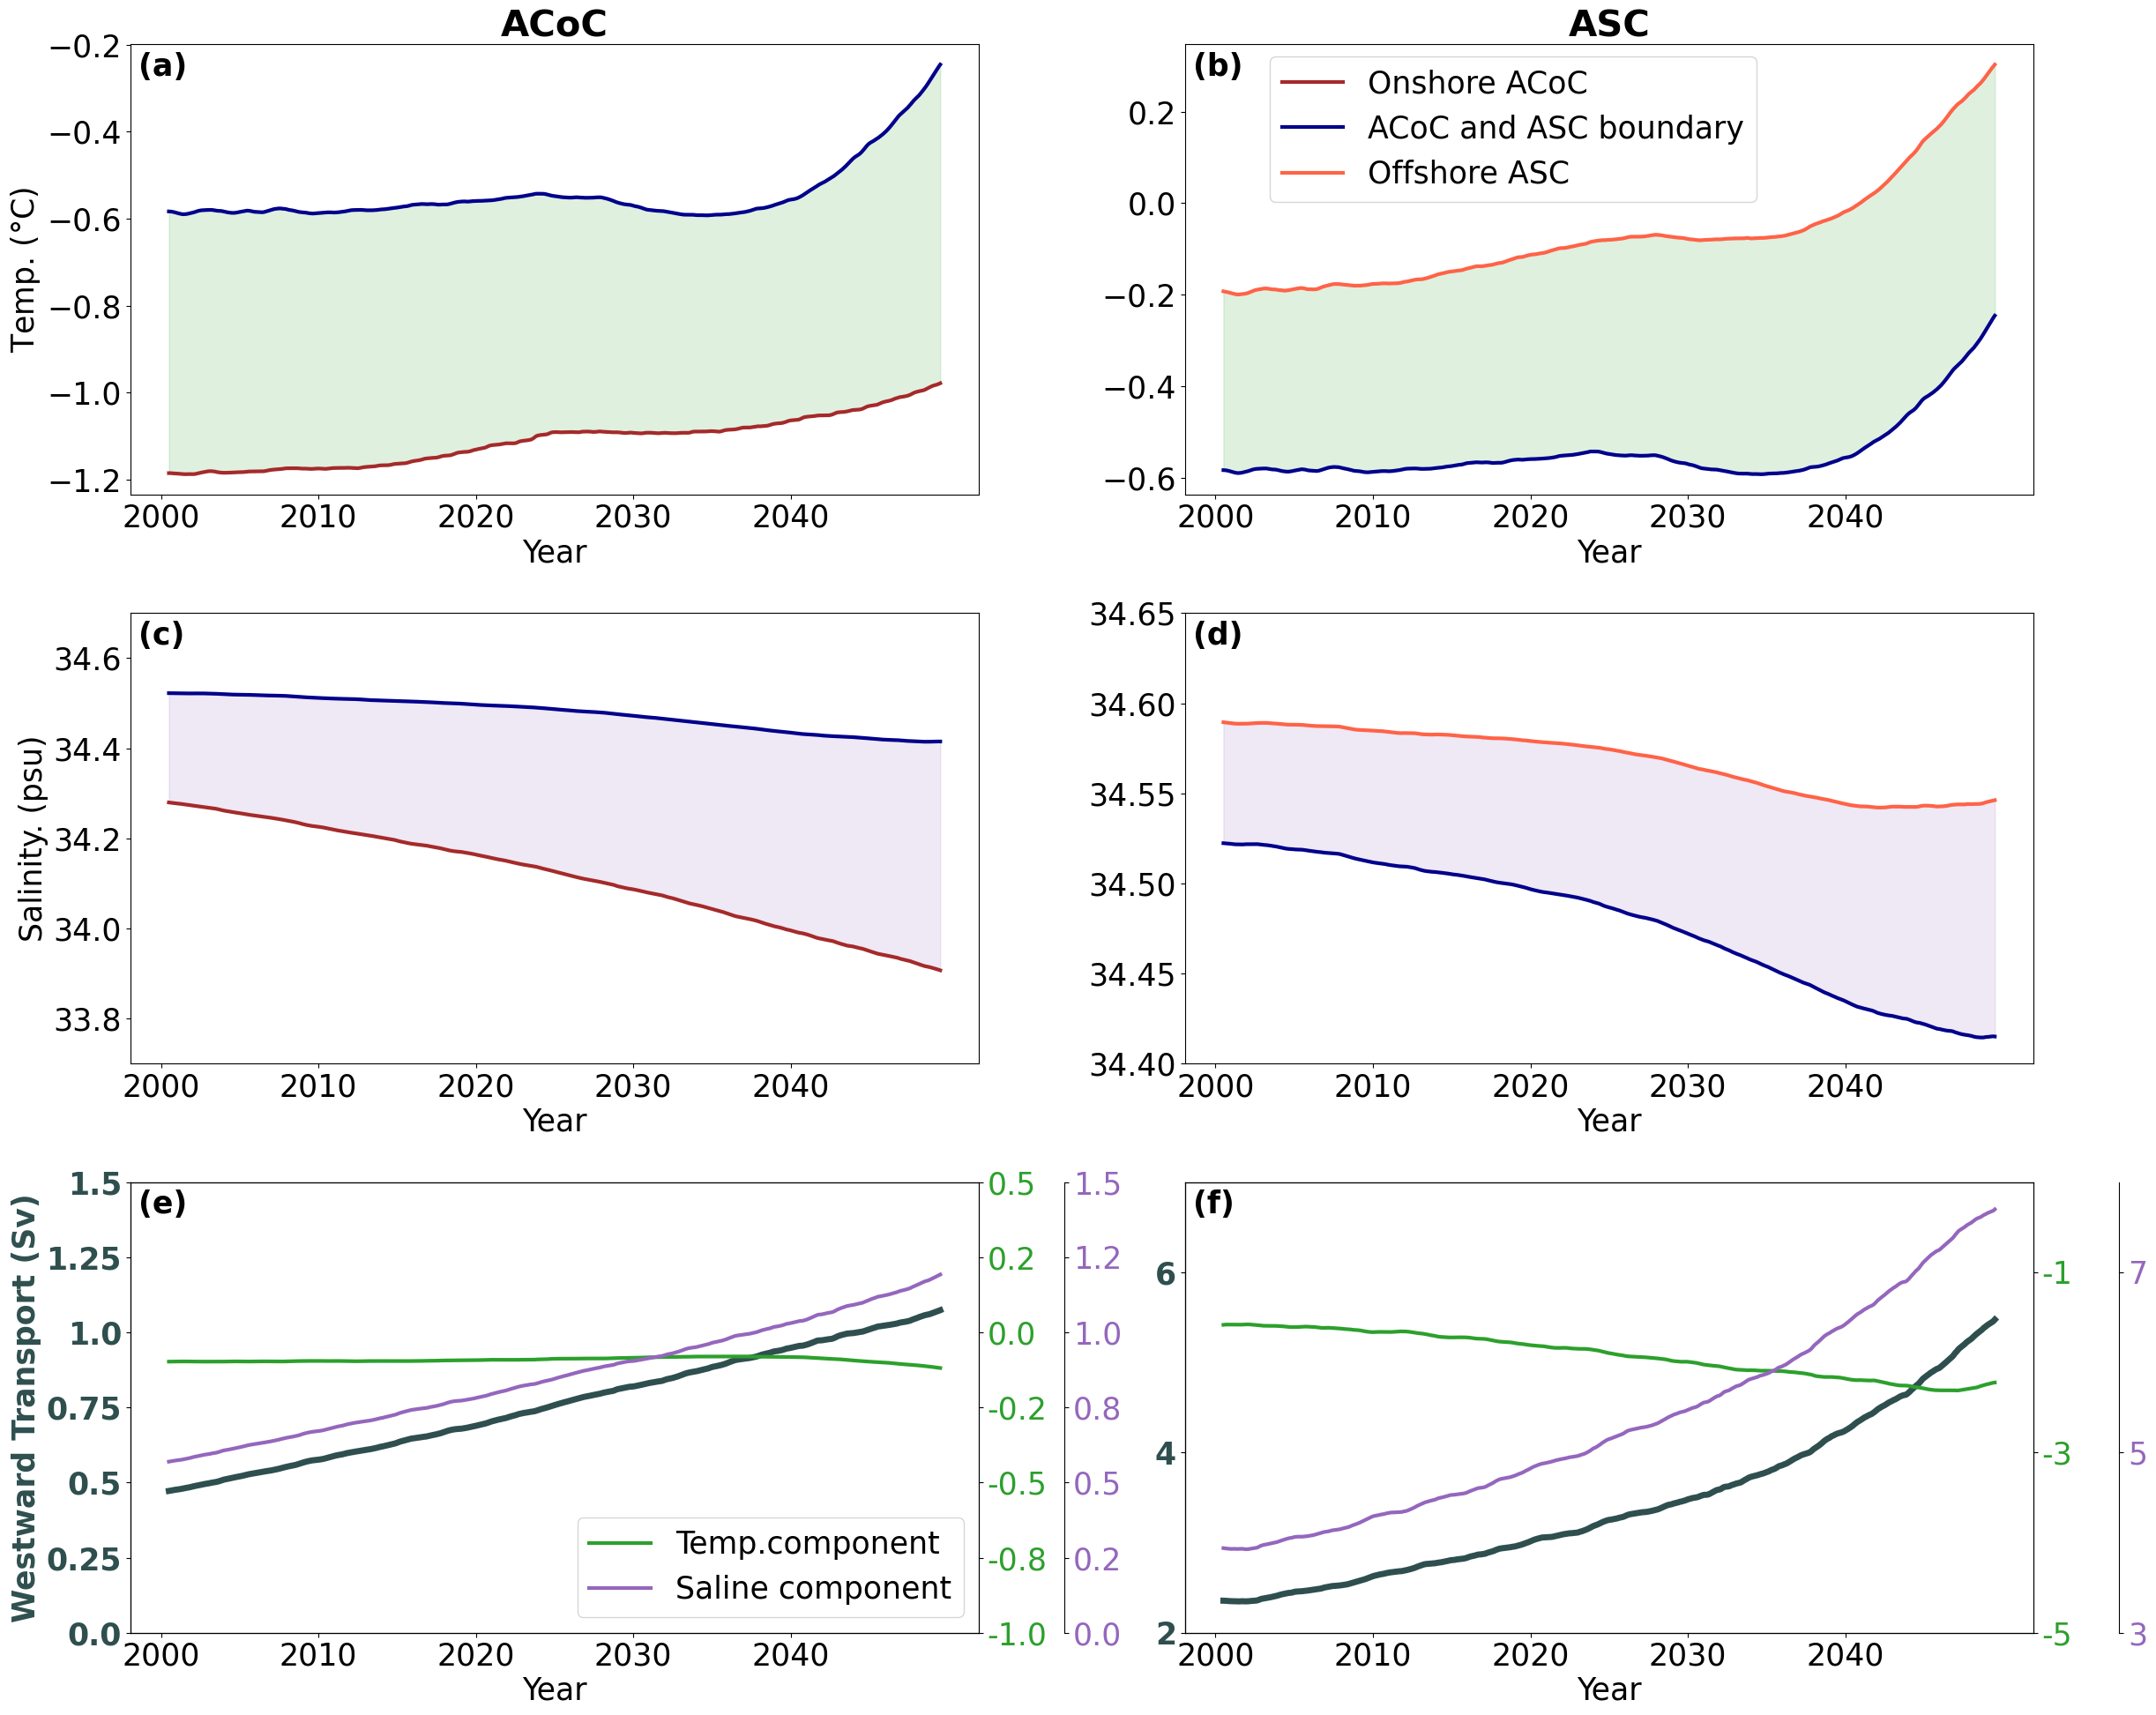

In [61]:
## master plot
lw = 3
#np.set_printoptions(precision=3)
from matplotlib.ticker import FormatStrFormatter

fig,ax = fig, ax = plt.subplot_mosaic("ab;cd;ef", figsize = (25,20))

onshore_offshore_clr = ['brown', 'darkblue', 'tomato']
total_color= 'darkslategrey'
legend_elements = [Line2D([0], [0], color=onshore_offshore_clr[0], lw=lw, label='Onshore ACoC'),
                  Line2D([0], [0], color=onshore_offshore_clr[1], lw=lw, label='ACoC and ASC boundary'),
                  Line2D([0], [0], color=onshore_offshore_clr[2], lw=lw, label='Offshore ASC')]

(temp_ACoC_S - 273).rolling(time = 12, center = True).mean().plot(\
                                    color = onshore_offshore_clr[0], ax = ax['a'], lw = lw)
(temp_ASC_ACoC- 273).rolling(time = 12, center = True).mean().plot(  \
                                      color = onshore_offshore_clr[1], ax = ax['a'], lw = lw)
ax['a'].fill_between(salt_ACoC_S.time.values, \
                     (temp_ACoC_S- 273).rolling(time = 12, center = True).mean().values,\
                     (temp_ASC_ACoC- 273).rolling(time = 12, center = True).mean().values, \
                     alpha = 0.15, color = 'C2')
ax['a'].set_title('ACoC', weight = 'bold', fontsize = 30)
#ax['a'].set_ylim([-1.3,-0.3])
ax['a'].set_ylabel(r'Temp. ($\degree$C)')
ax['b'].legend(handles=legend_elements, loc = (0.1,0.65))

(temp_ASC_ACoC- 273).rolling(time = 12, center = True).mean()\
    .plot( color = onshore_offshore_clr[1], ax = ax['b'], lw = lw)
(temp_ASC_N- 273).rolling(time = 12, center = True).mean()\
    .plot( color = onshore_offshore_clr[2],ax = ax['b'], lw = lw)

ax['b'].fill_between(temp_ASC_ACoC.time.values, \
                     (temp_ASC_ACoC- 273).rolling(time = 12, center = True).mean().values,\
                     (temp_ASC_N- 273).rolling(time = 12, center = True).mean().values,\
                     alpha = 0.15, color = 'C2')

ax['b'].set_title('ASC', weight = 'bold', fontsize = 30)

#ax['b'].set_ylim([-0.7,0.5])
ax['b'].set_ylabel('')
  
salt_ACoC_S.rolling(time = 12, center = True).mean().plot( color = onshore_offshore_clr[0],ax = ax['c'], lw = lw)
salt_ASC_ACoC.rolling(time = 12, center = True).mean().plot( color = onshore_offshore_clr[1],ax = ax['c'], lw = lw)
ax['c'].fill_between(salt_ACoC_S.time.values, salt_ACoC_S.rolling(time = 12, center = True).mean().values,\
                     salt_ASC_ACoC.rolling(time = 12, center = True).mean().values, alpha = 0.15, color = 'C4')
ax['c'].set_ylim([33.7,34.7])
ax['c'].set_ylabel('Salinity. (psu)')

salt_ASC_ACoC.rolling(time = 12, center = True).mean()\
    .plot( color = onshore_offshore_clr[1],ax = ax['d'], lw = lw)
salt_ASC_N.rolling(time = 12, center = True).mean()\
    .plot( color = onshore_offshore_clr[2], ax = ax['d'], lw = lw)
ax['d'].fill_between(salt_ASC_N.time.values, \
                     salt_ASC_N.rolling(time = 12, center = True).mean().values,\
                     salt_ASC_ACoC.rolling(time = 12, center = True).mean().values, alpha = 0.15, color = 'C4')
ax['d'].set_ylim([34.4,34.65])
ax['d'].set_ylabel('')


(-T_ACoC/1e6).rolling(time = 12, center = True).mean()\
    .plot(ax = ax['e'], label = 'ACoC depth-av', color = total_color, lw = 5)
ax2 = ax['e'].twinx()
ax['e'].set_ylim([0,1.5])

ax2.spines['right']
(-temp_comp_ACoC/1e6).rolling(time = 12, center = True).mean()\
    .plot( color = 'C2', ax = ax2, lw = lw, label = 'Temp.component')
ax2.set_ylim([-1,0.5])
ax2.set_yticklabels(labels = ax2.get_yticks(), color = 'C2')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.set_ylabel('')

ax3 = ax['e'].twinx()
ax3.spines['right'].set_position(('outward', 70))
ax3.set_ylim([0,1.5])
(-salt_comp_ACoC/1e6).rolling(time = 12, center = True).mean()\
    .plot( color = 'C4', ax = ax3, lw = lw, label = 'Saline component')
ax3.set_yticklabels(labels = ax3.get_yticks(), color = 'C4')
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax3.set_ylabel('', color= 'C4')

ax['e'].set_yticklabels(labels = ax['e'].get_yticks(), color = total_color, fontweight = 'bold')
ax['e'].set_ylabel('Westward Transport (Sv)', color = total_color, fontweight = 'bold')

### Do everything for plot4 as before
handles4,labels4 = ax2.get_legend_handles_labels()
### Do everything for plot4a
handles4a,labels4a = ax3.get_legend_handles_labels()
### Combine the legend handles and labels to make a new legend object
handles = handles4 + handles4a
labels = labels4 + labels4a


(-T_ASC/1e6).rolling(time = 12, center = True).mean()\
    .plot( label = 'ASC depth-av', ax = ax['f'], lw = 5,color = total_color,ylim = (2,7))
ax['f'].set_yticks(range(2,7,2))
ax['f'].set_yticklabels(labels =  ax['f'].get_yticks(), color = total_color, fontweight = 'bold')
ax['f'].set_ylabel('')

ax4 = ax['f'].twinx()
(-temp_comp_ASC/1e6).rolling(time = 12, center = True).mean()\
    .plot( color = 'C2', ax = ax4, lw = lw, ylim = (-5,0))
ax4.set_yticks(range(-5,0,2))
ax4.set_yticklabels(labels = ax4.get_yticks(), color = 'C2')
ax4.set_ylabel('')

ax5 = ax['f'].twinx()
ax5.spines['right'].set_position(('outward', 70))
ax5.set_yticks(range(3,8,2))
(-salt_comp_ASC/1e6).rolling(time = 12, center = True).mean()\
    .plot( color = 'C4', ax = ax5, lw = lw, ylim = (3,8))
ax5.set_yticklabels(labels = ax5.get_yticks(), color = 'C4')
ax5.set_ylabel('')

for letter in list(map(chr, range(ord('a'), ord('f')+1))):
        ax[letter].set_xticks(salt_ASC_N.time[::120].values)
        ax[letter].set_xticklabels(np.arange(2000,2050,10))
        ax[letter].set_xlabel('Year')
        ax[letter].text(0.01,0.93,'(' + letter + ')', \
                        transform=ax[letter].transAxes, fontweight = 'bold')
ax['e'].legend(handles, labels, loc = 'lower right')

plt.tight_layout()